# Using Multi-layer Perceptron and Convolutional Neural Networks for Satellite image classification - 2025

Antonio Fonseca

Packages to be installed:

```
conda install -c conda-forge umap-learn
pip install phate
conda install -c conda-forge imageio
pip install wandb
```

In [1]:
import numpy as np
import codecs
import copy
import json
import scipy.io
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn import manifold
import os
# import phate
# import umap
import pandas as pd 
# import scprep
from torch.nn import functional as F


import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
# import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

import wandb
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


cuda


Now that we have an autoencoder working on MNIST, let's use this model to visualize some geodata. For the next section we will use the SAT-6 (https://csc.lsu.edu/~saikat/deepsat/)

SAT-6 consists of a total of 405,000 image patches each of size 28x28 and covering <span style="color:red"> 6 landcover classes - barren land, trees, grassland, roads, buildings and water bodies</span>. 324,000 images (comprising of four-fifths of the total dataset) were chosen as the training dataset and 81,000 (one fifths) were chosen as the testing dataset. Similar to SAT-4, the training and test sets were selected from disjoint NAIP tiles. Once generated, the images in the dataset were randomized in the same way as that for SAT-4. The specifications for the various landcover classes of SAT-4 and SAT-6 were adopted from those used in the National Land Cover Data (NLCD) algorithm. 

The datasets are encoded as MATLAB .mat files that can be read using the standard load command in MATLAB.  <span style="color:red">Each sample image is 28x28 pixels and consists of 4 bands - red, green, blue and near infrared </span>. The training and test labels are 1x4 and 1x6 vectors for SAT-4 and SAT-6 respectively having a single 1 indexing a particular class from 0 through 4 or 6 and 0 values at all other indices.

The MAT file for the SAT-6 dataset contains the following variables:

- train_x	28x28x4x324000 uint8 (containing 324000 training samples of 28x28 images each with 4 channels)
- train_y	324000x6 uint8 (containing 6x1 vectors having labels for the 324000 training samples)
- test_x	28x28x4x81000 uint8 (containing 81000 test samples of 28x28 images each with 4 channels)
- test_y	81000x6 uint8 (containing 6x1 vectors having labels for the 81000 test samples)

Labels:
- Building = 0
- Barren_land = 1
- Tree=2
- Grassland=3
- Road = 4
- Water = 5


In [3]:
# Using the satelite images dataset
###############################################################################
#load the data
data = scipy.io.loadmat("./SAT-4_and_SAT-6_datasets/sat-6-full.mat")
train_images = data['train_x']
train_labels = data['train_y']

test_images = data['test_x']
test_labels = data['test_y']

In [4]:
####################################################################
#Checkout the data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

Training data shape :  (28, 28, 4, 324000) (6, 324000)
Testing data shape :  (28, 28, 4, 81000) (6, 81000)


In [5]:
#Change the dimension to fit into the model
x_train = train_images.transpose(3,0,1,2)
t_train = train_labels.transpose()

# x_test = test_images.transpose(3,0,1,2)
# t_test = test_labels.transpose()
print('Training data shape : ', x_train.shape, t_train.shape)
# print('Testing data shape : ', x_test.shape, t_test.shape)

Training data shape :  (324000, 28, 28, 4) (324000, 6)


count, t_train[count,:]: 0, [0 0 1 0 0 0]
count, t_train[count,:]: 1, [0 1 0 0 0 0]
count, t_train[count,:]: 2, [0 0 0 0 0 1]
count, t_train[count,:]: 3, [0 0 0 0 0 1]
count, t_train[count,:]: 4, [0 0 0 0 0 1]
count, t_train[count,:]: 5, [1 0 0 0 0 0]
count, t_train[count,:]: 6, [1 0 0 0 0 0]
count, t_train[count,:]: 7, [0 0 0 0 0 1]
count, t_train[count,:]: 8, [0 1 0 0 0 0]
count, t_train[count,:]: 9, [0 0 1 0 0 0]
count, t_train[count,:]: 10, [0 0 0 0 0 1]
count, t_train[count,:]: 11, [0 1 0 0 0 0]
count, t_train[count,:]: 12, [0 1 0 0 0 0]
count, t_train[count,:]: 13, [0 0 0 0 1 0]
count, t_train[count,:]: 14, [0 0 0 0 0 1]
count, t_train[count,:]: 15, [0 0 1 0 0 0]


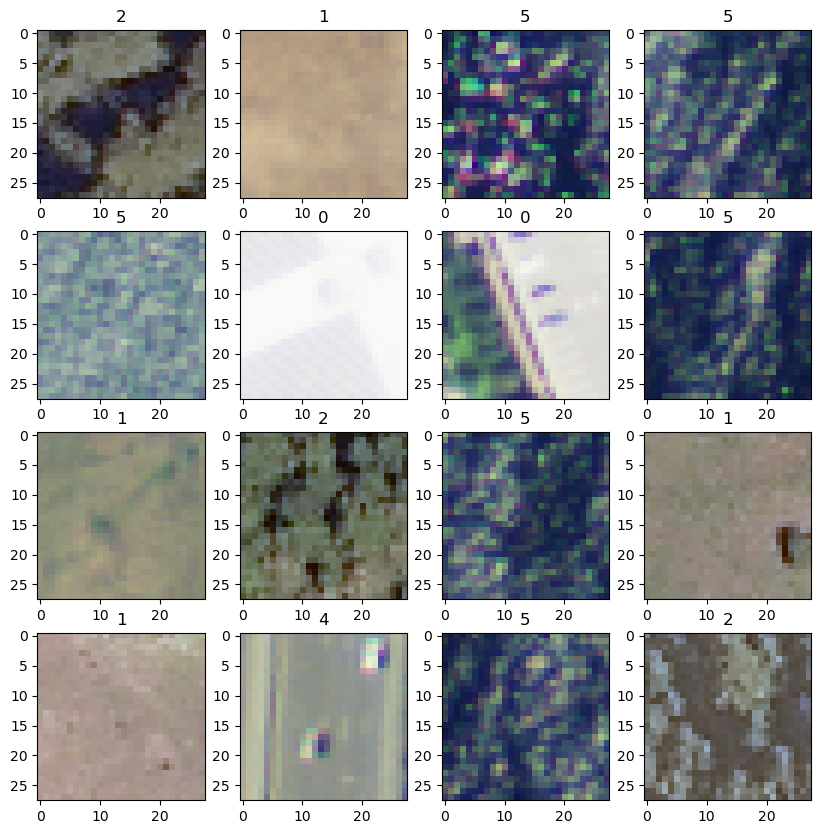

In [6]:
#Check what is in each channel
fig,ax = plt.subplots(4,4, figsize=(10,10))
ax = ax.ravel()
list_idx = np.linspace(0,100,num=16,dtype=np.int64)
for count, idx in enumerate(list_idx):
#     print(idx)
    print('count, t_train[count,:]: {}, {}'.format(count, t_train[count,:]))
#     print(x_train[idx,:,:,0:3])
    ax[count].imshow(x_train[count,:,:,0:3])
    ax[count].set_title(str(np.argmax(t_train[count,:])))

In [7]:
# split in training and testing
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from scipy.ndimage import zoom


class MyDataset(Dataset):
    def __init__(self, data, target):
        print('data.dtype: {}'.format(data.dtype))
        print('target.dtype: {}'.format(target.dtype))
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

print('x_train.shape: {}'.format(x_train.shape))
n_samples = 50000
dataset = MyDataset(x_train[:n_samples,:,:,:], np.argmax(t_train[:n_samples],axis=1))
del x_train, t_train
dataset_size  = len(dataset)
print('dataset_size: {}'.format(dataset_size))
test_split=0.2

batch_size=1024 

# -- split dataset
indices       = list(range(dataset_size))
split         = int(np.floor(test_split*dataset_size))
print('split: {}'.format(split))
# np.random.shuffle(indices) # Randomizing the indices is not a good idea if you want to model the sequence
train_indices, val_indices = indices[split:], indices[:split]

# -- create dataloaders
# #Original
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders   = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler),
    'all': torch.utils.data.DataLoader(dataset,  batch_size=5000, shuffle=False),
    }

x_train.shape: (324000, 28, 28, 4)
data.dtype: uint8
target.dtype: int64
dataset_size: 50000
split: 10000


In [14]:
class FFnet(nn.Module):
    '''
    Linear activation in the middle (instead of an activation function)
    '''
    def __init__(self):
        super(FFnet, self).__init__()
        self.enc_lin1 = nn.Linear(3136, 1000) # 28 x 28 x 4
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 6)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.relu(x)
        x = self.enc_lin2(x)
        x = self.relu(x)
        x = self.enc_lin3(x)
        x = self.relu(x)
        output = self.enc_lin4(x)
        return output

    def forward(self, x):
        z = self.encode(x)
        return z

In [15]:
## Second routine for training and evaluation (using the )
# Training and Evaluation routines
import time
def train(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss or Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100 
    print('n. of epochs: {}'.format(num_epochs))
    for epoch in range(num_epochs+1):
        start = time.time()
        # loop through each data point in the training set
        for data, targets in train_loader:
            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose: print('model_input.shape: {}'.format(model_input.shape))
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out = model(model_input) # The second output is the latent representation
            if verbose:
                print('targets.shape: {}'.format(targets.shape))
                print('targets: {}'.format(targets))
                print('out.shape: {}'.format(out.shape))
                print('out: {}'.format(out))

            # Calculate the loss
            targets = targets.type(torch.LongTensor).to(device) # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,targets)
            if verbose: print('loss: {}'.format(loss))
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        loss_train, acc_train = evaluate(model,train_loader,verbose)
        loss_test, acc_test = evaluate(model,test_loader,verbose)
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(" Train loss: {:.4f}. Train Acc: {:.4f}, Test loss: {:.4f}. Test Acc: {:.4f}. Time/epoch: {:.4f}".format(loss_train, acc_train, loss_test, acc_test, (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

        wandb.log({
            "Loss/train": loss_train,
            "Loss/val": loss_test,
            "Accuracy/train": acc_train,
            "Accuracy/val": acc_test,
            "epoch": epoch
        }, step=epoch)

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0
        
        for data, targets in evaluation_set:
            targets= targets.to(device)
            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out = model(model_input)
            targets = targets.type(torch.LongTensor).to(device)
            loss = loss_fn(out,targets)
        
            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100 * correct / total    
        loss = loss_all/total
    return loss, acc


In [17]:
lr_range = [0.01,0.005,0.001, 0.0001]

for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model, loss_fn, optimizer
    model = FFnet().to(device)
    DATETIME = datetime.datetime.now().strftime('%Y-%m-%d-%H_%M_%S')
    wandb.init(project="GeoComp_Matera2023", entity="ahof1704", name="CNN_sat_FFnet_{}".format(DATETIME))
    wandb.watch(model, log="all", log_freq=1)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    loss_fn = nn.CrossEntropyLoss().to(device)
    train(model,loss_fn, optimizer, dataloaders['train'], dataloaders['test'],verbose=False)

Deleting previous model


Accuracy/train,▄▆▆▇▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▄▆▆▇▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▂▂▂▁▁▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Loss/val,█▂▂▁▁▁▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.00154
Loss/val,0.00153
epoch,58


optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0008. Train Acc: 66.3475, Test loss: 0.0008. Test Acc: 66.8600. Time/epoch: 4.3759
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 81.9250, Test loss: 0.0004. Test Acc: 81.8900. Time/epoch: 3.9911
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 89.1425, Test loss: 0.0003. Test Acc: 88.6500. Time/epoch: 3.9714
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0002. Train Acc: 93.1425, Test loss: 0.0002. Test Acc: 92.5700. Time/epoch: 3.7580
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0.0015. Test Acc: 37.5400. Time/epoch: 3.8162
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0.0015. Test Acc: 37.5400. Time/epoch: 3.9956
 EPOCH 60. Progress: 60.0%. 
 Tra

Accuracy/train,▅▇▇█▇▇▅████▇██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▅▇▇█▇▇▅████▇██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.00154
Loss/val,0.00153
epoch,100


optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 75.6150, Test loss: 0.0005. Test Acc: 75.5200. Time/epoch: 4.0944
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 84.7850, Test loss: 0.0003. Test Acc: 84.7500. Time/epoch: 3.9586
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 92.3075, Test loss: 0.0002. Test Acc: 91.8300. Time/epoch: 3.8414
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0002. Train Acc: 93.0650, Test loss: 0.0002. Test Acc: 92.7300. Time/epoch: 4.0199
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.0002. Train Acc: 89.9625, Test loss: 0.0002. Test Acc: 89.8600. Time/epoch: 4.3224
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.0002. Train Acc: 90.8100, Test loss: 0.0002. Test Acc: 90.1700. Time/epoch: 4.3020
 EPOCH 60. Progress: 60.0%. 
 Tr

Accuracy/train,▁▁▄▇▄▇▇▅▇▇▇▇█▇▇▆▇███▇▃▄▂▆▆▅▆▇▅▇▇▆▇▇▇▇▇██
Accuracy/val,▁▁▄▇▅▇▇▅▇▇▇▇█▇▇▆▇███▇▃▄▂▆▆▅▆▇▅▇▇▆▇▇▇▇▇▇▇
Loss/train,▇█▄▂▄▂▂▄▂▂▂▂▁▂▃▃▂▁▁▁▁█▄▆▃▃▄▃▂▃▂▂▂▂▂▁▂▂▁▁
Loss/val,▇█▄▂▄▂▂▄▂▂▂▂▁▂▃▃▂▁▁▁▁█▄▆▃▃▄▃▂▃▂▂▂▂▂▂▂▂▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,92.7275
Accuracy/val,92.24
Loss/train,0.00016
Loss/val,0.00017
epoch,100


optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 78.5275, Test loss: 0.0005. Test Acc: 78.4300. Time/epoch: 4.0875
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 88.7000, Test loss: 0.0003. Test Acc: 88.5600. Time/epoch: 3.8260
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 92.8550, Test loss: 0.0002. Test Acc: 92.3100. Time/epoch: 3.9107
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0003. Train Acc: 85.9700, Test loss: 0.0003. Test Acc: 85.9500. Time/epoch: 3.7582
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.0002. Train Acc: 92.8800, Test loss: 0.0002. Test Acc: 92.4900. Time/epoch: 3.9415
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.0001. Train Acc: 94.0175, Test loss: 0.0002. Test Acc: 93.3500. Time/epoch: 3.8053
 EPOCH 60. Progress: 60.0%. 
 Tr

Accuracy/train,▁▁▁▁▅▃▇▇▇▇▆▇▄▆▇▆▇█▅▇▇▇▇▄▇▅▇▇▆▆▇▇▇▇▇▇▇██▇
Accuracy/val,▁▂▂▂▅▃▇▇▇▇▆▇▄▆▇▆▇█▅▇▇█▇▄█▆▇▇▆▆▇▇▇▇▇▇███▇
Loss/train,▇█▅█▄▅▃▃▂▃▂▂▄▃▂▃▂▁▃▂▂▂▂▄▁▃▂▂▃▃▂▂▁▂▁▂▁▁▁▂
Loss/val,▇█▅█▄▅▃▂▂▂▂▂▄▂▂▂▂▁▃▁▂▂▂▄▁▃▂▂▃▃▂▂▁▂▁▂▁▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,93.8075
Accuracy/val,92.59
Loss/train,0.00015
Loss/val,0.00018
epoch,100


optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 81.5800, Test loss: 0.0004. Test Acc: 81.4000. Time/epoch: 4.6343
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 91.4275, Test loss: 0.0002. Test Acc: 91.2600. Time/epoch: 3.9659
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0003. Train Acc: 86.6925, Test loss: 0.0003. Test Acc: 86.5700. Time/epoch: 4.0900
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0002. Train Acc: 93.3275, Test loss: 0.0002. Test Acc: 93.0000. Time/epoch: 3.7836
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.0003. Train Acc: 86.7875, Test loss: 0.0003. Test Acc: 86.6300. Time/epoch: 3.9666
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.0003. Train Acc: 86.1525, Test loss: 0.0003. Test Acc: 86.0300. Time/epoch: 4.4136
 EPOCH 60. Progress: 60.0%. 
 T

# Using CNNs for a image dataset 

In [12]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNNet()

In [13]:
# Training and Evaluation routines
import time
def train(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
        
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100
    print('n. of epochs: {}'.format(num_epochs))
    for epoch in range(num_epochs+1):
        start = time.time()
        # loop through each data point in the training set
        for data, targets in train_loader:
            
            # run the model on the data
            model_input = data.permute(0, 3, 2, 1).to(device)
            if verbose: print('model_input.shape: {}'.format(model_input.shape))
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out = model(model_input) # The second output is the latent representation
            if verbose:
                print('targets.shape: {}'.format(targets.shape))
                print('targets: {}'.format(targets))
                print('out.shape: {}'.format(out.shape))
                print('out: {}'.format(out))

            # Calculate the loss
            targets = targets.type(torch.LongTensor).to(device) # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,targets)
            if verbose: print('loss: {}'.format(loss))
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            loss_train, acc_train = evaluate(model,train_loader,verbose)
            loss_test, acc_test = evaluate(model,test_loader,verbose)
            print(" Train loss: {:.4f}. Train Acc: {:.4f}, Test loss: {:.4f}. Test Acc: {:.4f}. Time/epoch: {:.4f}".format(loss_train, acc_train, loss_test, acc_test, (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.
            

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0
        
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.permute(0, 3, 2, 1).to(device)
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out = model(model_input)
            targets = targets.type(torch.LongTensor)
            loss = loss_fn(out,targets)
        
            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100 * correct / total    
        loss = loss_all/total
    return loss, acc


In [14]:
lr_range = [0.01,0.005,0.001]

for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model, loss_fn, optimizer
    model = CNNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 

    loss_fn = nn.CrossEntropyLoss().to(device)
    train(model,loss_fn, optimizer, dataloaders['train'], dataloaders['test'],verbose=False)

Deleting previous model


NameError: name 'loss_fn' is not defined

## Define Your Neural Network
Before we can run the sweep, let's define a function that creates and trains our neural network.

In the function below, we define a simple CNN in Pytorch, and add the following lines of code to log models metrics, visualize performance and output and track our experiments easily:

- wandb.init() – Initialize a new W&B run. Each run is single execution of the training script.
- wandb.config – Save all your hyperparameters in a config object. This lets you use our app to sort and compare your runs by hyperparameter values.
- callbacks=[WandbCallback()] – Fetch all layer dimensions, model parameters and log them automatically to your W&B dashboard.
- wandb.log() – Logs custom objects – these can be images, videos, audio files, HTML, plots, point clouds etc. Here we use wandb.log to log images of Simpson characters overlaid with actual and predicted labels.

# Sweeping with WandB

In [56]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random, bayes
    'metric': {
      'name': 'Accuracy/val',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [10, 20, 50]
        },
        'batch_size': {
            'values': [32,64,128]
        },
        'weight_decay': {
            'values': [0.0005, 0.005, 0.05]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        }
    }
}


In [57]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="ahof1704", project="CNN_Sat_sweep")

Create sweep with ID: 4bmop0um
Sweep URL: https://wandb.ai/ahof1704/CNN_Sat_sweep/sweeps/4bmop0um


In [58]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNNet()

In [59]:
# Training and Evaluation routines for Sweeping 
import time

loss_fn = nn.CrossEntropyLoss().to(device)

def train(config=None):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    
    with wandb.init(config=config):
        verbose=False
        model = CNNet().to(device)
        model.train()

        # Config is a variable that holds and saves hyperparameters and inputs
        config = wandb.config

        print('optimizer: {}'.format(config.optimizer))
        # Define the optimizer
        if config.optimizer=='sgd':
            optimizer =  torch.optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9, nesterov=True)
        elif config.optimizer=='rmsprop':
            optimizer =  torch.optim.RMSprop(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        elif config.optimizer=='adam':
            optimizer =  torch.optim.Adam(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.999))

        # -- create dataloaders
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        dataloaders   = {
            'train': torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=train_sampler),
            'test': torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=valid_sampler),
            'all': torch.utils.data.DataLoader(dataset,  batch_size=5000, shuffle=False),
            }
        train_loader = dataloaders['train']
        test_loader = dataloaders['test']

        for epoch in range(config.epochs+1):
            start = time.time()
            # loop through each data point in the training set
            for data, targets in train_loader:

                # run the model on the data
                model_input = data.permute(0, 3, 2, 1).to(device)
                if verbose: print('model_input.shape: {}'.format(model_input.shape))

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                out = model(model_input) # The second output is the latent representation
                if verbose:
                    print('targets.shape: {}'.format(targets.shape))
                    print('targets: {}'.format(targets))
                    print('out.shape: {}'.format(out.shape))
                    print('out: {}'.format(out))

                # Calculate the loss
                targets = targets.type(torch.LongTensor).to(device) # add an extra dimension to keep CrossEntropy happy.
                if verbose: print('targets.shape: {}'.format(targets.shape))
                loss = loss_fn(out,targets)
                if verbose: print('loss: {}'.format(loss))

                # Find the gradients of our loss via backpropogation
                loss.backward()

                # Adjust accordingly with the optimizer
                optimizer.step()

            loss_train, acc_train = evaluate(model,train_loader,verbose)
            loss_test, acc_test = evaluate(model,test_loader,verbose) 
            
            # Give status reports every 100 epochs
            if epoch % 10==0:
                print(f" EPOCH {epoch}. Progress: {epoch/config.epochs*100}%. ")
                print(" Train loss: {:.4f}. Train Acc: {:.4f}, Test loss: {:.4f}. Test Acc: {:.4f}. Time/epoch: {:.4f}".format(loss_train, acc_train, loss_test, acc_test, (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

            wandb.log({
                "Loss/train": loss_train,
                "Loss/val": loss_test,
                "Accuracy/train": acc_train,
                "Accuracy/val": acc_test,
                "epoch": epoch
            }, step=epoch)

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    model.eval()
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0

        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.permute(0, 3, 2, 1).to(device)
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out = model(model_input)
            targets = targets.type(torch.LongTensor).to(device)
            loss = loss_fn(out,targets)

            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100 * correct / total    
        loss = loss_all/total
    return loss, acc


In [60]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: zzam8458 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0088. Train Acc: 83.1675, Test loss: 0.0088. Test Acc: 83.3300. Time/epoch: 3.3380
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0028. Train Acc: 92.3525, Test loss: 0.0029. Test Acc: 92.4100. Time/epoch: 3.2960


Accuracy/train,▁▅▅▆▆▇▇▇▇██
Accuracy/val,▁▄▅▆▆▇▇▇███
Loss/train,█▃▂▂▂▂▁▁▁▁▁
Loss/val,█▃▂▂▂▂▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,92.3525
Accuracy/val,92.41
Loss/train,0.00284
Loss/val,0.00293
epoch,10


wandb: Agent Starting Run: oft3pjvq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0099. Train Acc: 87.1850, Test loss: 0.0103. Test Acc: 86.9400. Time/epoch: 4.9065
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0049. Train Acc: 94.0975, Test loss: 0.0054. Test Acc: 93.6300. Time/epoch: 4.8879
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0035. Train Acc: 95.4450, Test loss: 0.0042. Test Acc: 94.4000. Time/epoch: 4.8633
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0038. Train Acc: 95.4750, Test loss: 0.0047. Test Acc: 94.5100. Time/epoch: 4.6823
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0052. Train Acc: 93.3300, Test loss: 0.0058. Test Acc: 92.8400. Time/epoch: 4.6711
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0033. Train Acc: 96.1875, Test loss: 0.0042. Test Acc: 95.2100. Time/epoch: 4.8509


Accuracy/train,▁▅▅▆▆▇▆▇▆▇▇▆▇▇▇▆▇▇▆█▇█▇▅▇▇▆█▇▆███▇██▇███
Accuracy/val,▁▅▆▆▇▇▇▇▆█▇▇▇█▇▅▇▇▆█▇██▄▇█▆█▇▆█▇█▇██▇███
Loss/train,█▅▄▄▃▂▃▂▃▂▂▃▂▂▂▃▂▂▂▁▂▂▂▅▂▁▃▁▂▃▁▁▁▂▁▁▂▁▁▁
Loss/val,█▄▃▃▂▂▂▂▃▂▂▃▂▁▂▄▂▂▂▁▂▂▁▅▂▁▃▁▃▃▁▂▁▂▁▁▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.1875
Accuracy/val,95.21
Loss/train,0.00333
Loss/val,0.00418
epoch,50


wandb: Agent Starting Run: 5l40buem with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0067. Train Acc: 91.3225, Test loss: 0.0069. Test Acc: 91.1800. Time/epoch: 4.6403
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0040. Train Acc: 94.8575, Test loss: 0.0042. Test Acc: 94.8800. Time/epoch: 4.6858
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0036. Train Acc: 95.1500, Test loss: 0.0038. Test Acc: 95.2500. Time/epoch: 4.6908
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0034. Train Acc: 95.7000, Test loss: 0.0035. Test Acc: 95.7100. Time/epoch: 4.5836
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0035. Train Acc: 95.5450, Test loss: 0.0036. Test Acc: 95.4700. Time/epoch: 4.5669
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0033. Train Acc: 95.9025, Test loss: 0.0035. Test Acc: 95.9200. Time/epoch: 4.6939


Accuracy/train,▁▂▅▅▄▇▆▇▆▆▆▇▇▆█▄▇▇▇▇█▇██████▇▇█▇▇█▇▇████
Accuracy/val,▁▃▅▅▅▇▆▇▆▇▆▇▇▆█▅▇▇▇▆▇▇▇█████▇▇█▇▇█▇█████
Loss/train,█▆▄▄▅▃▃▃▂▂▃▂▂▃▂▄▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
Loss/val,█▆▄▄▅▃▃▃▃▂▂▂▂▃▂▄▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.9025
Accuracy/val,95.92
Loss/train,0.00333
Loss/val,0.00346
epoch,50


wandb: Agent Starting Run: ycw8i34p with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.6145
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 4.7618


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▆▄▃█▆▂▂▂▂▃▁
Loss/val,▆▅▃█▃▃▁▂▂▃▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04804
Loss/val,0.04794
epoch,10


wandb: Agent Starting Run: jc5xf3r3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.5855
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7293


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▄█▁▃▄▁▂▆█▂▃
Loss/val,▃█▁▃▃▂▄▆█▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.0481
Loss/val,0.04798
epoch,10


wandb: Agent Starting Run: i7nmk94y with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0065. Train Acc: 73.8450, Test loss: 0.0065. Test Acc: 73.8100. Time/epoch: 2.1962
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 90.5125, Test loss: 0.0020. Test Acc: 90.4400. Time/epoch: 2.3259


Accuracy/train,▁▄▅▆▆▇▇▇███
Accuracy/val,▁▄▅▆▆▇▇▇███
Loss/train,█▅▃▃▂▂▂▁▁▁▁
Loss/val,█▅▃▃▂▂▂▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,90.5125
Accuracy/val,90.44
Loss/train,0.00192
Loss/val,0.00196
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8e2wk0j2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0068. Train Acc: 85.0775, Test loss: 0.0068. Test Acc: 85.7200. Time/epoch: 3.0562
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0025. Train Acc: 93.6550, Test loss: 0.0027. Test Acc: 93.5200. Time/epoch: 3.1775
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0022. Train Acc: 94.7350, Test loss: 0.0023. Test Acc: 94.4900. Time/epoch: 3.1338


Accuracy/train,▁▄▅▆▆▇▇▇▇▇▇▇█████████
Accuracy/val,▁▄▅▆▆▇▇▇▇▇▇██████████
Loss/train,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,94.735
Accuracy/val,94.49
Loss/train,0.00217
Loss/val,0.0023
epoch,20


wandb: Agent Starting Run: 9olidkws with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0068. Train Acc: 91.0925, Test loss: 0.0069. Test Acc: 90.8100. Time/epoch: 4.7435
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0047. Train Acc: 93.6450, Test loss: 0.0048. Test Acc: 93.8200. Time/epoch: 4.8731
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0039. Train Acc: 94.9900, Test loss: 0.0040. Test Acc: 95.1200. Time/epoch: 4.8602
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0052. Train Acc: 92.5125, Test loss: 0.0053. Test Acc: 92.6600. Time/epoch: 4.6839
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0036. Train Acc: 95.6250, Test loss: 0.0037. Test Acc: 95.6400. Time/epoch: 4.8334
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0036. Train Acc: 95.3300, Test loss: 0.0037. Test Acc: 95.5700. Time/epoch: 4.8268


Accuracy/train,▁▃▃▅▄▄▆▅▅▆▅▆▇▇▆▇▆▇▇▇▆▆▇█▃▇▇▇▇▆█▇█▆████▇▇
Accuracy/val,▁▃▄▅▅▅▆▅▅▆▄▇▇▇▆▇▇▇▇▇▆▆▇█▃▇▇▇▇▆█▇█▇████▇▇
Loss/train,█▆▅▄▄▄▃▄▄▃▄▃▂▂▃▂▂▂▂▂▃▂▁▁▅▂▂▂▂▃▁▂▁▃▁▁▁▁▂▂
Loss/val,█▆▅▄▄▄▃▄▄▃▄▂▂▂▃▂▂▂▂▂▃▂▁▁▅▂▂▂▂▃▁▂▁▂▁▁▁▁▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.33
Accuracy/val,95.57
Loss/train,0.00357
Loss/val,0.00366
epoch,50


wandb: Agent Starting Run: xwgaxq12 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0018. Train Acc: 90.3100, Test loss: 0.0019. Test Acc: 90.2400. Time/epoch: 2.3505
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0012. Train Acc: 93.2350, Test loss: 0.0013. Test Acc: 93.2100. Time/epoch: 2.3292
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0009. Train Acc: 95.3875, Test loss: 0.0011. Test Acc: 94.9800. Time/epoch: 2.1884
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0006. Train Acc: 96.9850, Test loss: 0.0007. Test Acc: 96.5600. Time/epoch: 2.3183
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0006. Train Acc: 97.2925, Test loss: 0.0007. Test Acc: 96.8100. Time/epoch: 2.3052
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 97.6450, Test loss: 0.0006. Test Acc: 97.1600. Time/epoch: 2.1686


Accuracy/train,▁▃▄▅▅▆▆▆▄▆▆▇▅▆▆▇▆▇▇▇▅▇▆▇▇▇▇▇███▇███▇▇███
Accuracy/val,▁▃▄▅▅▆▆▆▄▆▆▇▅▆▆▇▆▇▇▇▅▇▆▇▇▇▇▇▇██▇█▇█▇▇█▇█
Loss/train,█▆▅▄▄▃▃▃▅▃▃▂▄▃▃▂▃▂▂▂▃▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁
Loss/val,█▆▅▄▄▃▃▃▅▃▃▂▄▃▃▂▃▂▂▂▃▂▂▂▁▂▂▂▁▁▁▂▁▁▁▂▃▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.645
Accuracy/val,97.16
Loss/train,0.00049
Loss/val,0.00063
epoch,50


wandb: Agent Starting Run: 3qr8irec with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0119. Train Acc: 88.0000, Test loss: 0.0122. Test Acc: 87.8200. Time/epoch: 4.7784
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0055. Train Acc: 92.7175, Test loss: 0.0056. Test Acc: 92.7200. Time/epoch: 4.6236
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0050. Train Acc: 93.7725, Test loss: 0.0052. Test Acc: 93.5600. Time/epoch: 4.5725
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0047. Train Acc: 93.7725, Test loss: 0.0049. Test Acc: 93.9700. Time/epoch: 4.7329
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0040. Train Acc: 95.1700, Test loss: 0.0042. Test Acc: 95.1100. Time/epoch: 4.7364
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0041. Train Acc: 95.0375, Test loss: 0.0043. Test Acc: 94.8900. Time/epoch: 4.7085


Accuracy/train,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇████▇█▇█▇████▆█
Accuracy/val,▁▄▄▅▅▆▆▆▆▇▆▇▇▇▇▇▆▇▇▇▇▇█▇▇████▇█▇█▇████▆█
Loss/train,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
Loss/val,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.0375
Accuracy/val,94.89
Loss/train,0.0041
Loss/val,0.00427
epoch,50


wandb: Agent Starting Run: t4osxxhb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0016. Train Acc: 91.7150, Test loss: 0.0016. Test Acc: 91.6600. Time/epoch: 2.3046
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0007. Train Acc: 96.3875, Test loss: 0.0008. Test Acc: 95.9900. Time/epoch: 2.4241
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0004. Train Acc: 97.8550, Test loss: 0.0006. Test Acc: 97.0100. Time/epoch: 2.4088


Accuracy/train,▁▃▄▅▅▆▆▆▇▆▆▆▇▆▇▇███▇█
Accuracy/val,▁▄▄▆▅▇▆▇▇▇▇▆▇▆█▇███▇█
Loss/train,█▅▅▄▄▃▃▃▂▃▃▃▂▃▂▂▁▁▁▂▁
Loss/val,█▅▄▃▃▂▃▂▂▂▂▃▁▃▁▂▁▁▁▃▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.855
Accuracy/val,97.01
Loss/train,0.00044
Loss/val,0.00063
epoch,20


wandb: Agent Starting Run: 3d41qa4k with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.1893
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.1383
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 5.1727


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▆▅▄▄▄▆▅▅▂▆▂▂▁▇▄█▅▄▅▇▂
Loss/val,▅█▂▁▃▇▆▇▄▆▅▅▂█▅▆▅▆▅▄▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04805
Loss/val,0.04793
epoch,20


wandb: Agent Starting Run: xvc9j71t with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0060. Train Acc: 91.9650, Test loss: 0.0062. Test Acc: 91.7200. Time/epoch: 4.8781
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0121. Train Acc: 84.9550, Test loss: 0.0121. Test Acc: 85.3500. Time/epoch: 4.8153
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0035. Train Acc: 95.7625, Test loss: 0.0036. Test Acc: 95.7500. Time/epoch: 4.8847


Accuracy/train,▆▆▆▆▇▇▇▇▇█▁▇███▇█▇███
Accuracy/val,▅▅▆▆▇▇▇▇▇█▁▇▇████▇███
Loss/train,▃▃▂▂▂▂▂▁▂▂█▂▁▁▁▁▁▂▁▁▁
Loss/val,▃▃▂▂▂▂▂▁▂▂█▂▁▁▁▁▁▂▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.7625
Accuracy/val,95.75
Loss/train,0.00353
Loss/val,0.0036
epoch,20


wandb: Agent Starting Run: w3ttjtb4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0018. Train Acc: 90.5200, Test loss: 0.0019. Test Acc: 90.5500. Time/epoch: 2.3806
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0010. Train Acc: 95.0050, Test loss: 0.0011. Test Acc: 94.8300. Time/epoch: 2.3062
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0009. Train Acc: 95.5125, Test loss: 0.0009. Test Acc: 95.4000. Time/epoch: 2.1862
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0008. Train Acc: 96.2875, Test loss: 0.0008. Test Acc: 96.1700. Time/epoch: 2.3307
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 95.3725, Test loss: 0.0010. Test Acc: 95.1500. Time/epoch: 2.3377
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 95.3175, Test loss: 0.0009. Test Acc: 95.4600. Time/epoch: 2.3253


Accuracy/train,▁▅▁▅▆▃▆▅▆▇▆▅▆▇▇▆▇▇▇▅▇▇█▇█▆▆▆▇█▇█▇█▇██▇▅▇
Accuracy/val,▁▅▂▅▆▃▆▆▆▆▆▅▆▇▇▆▇▇▇▅▇▇█▇█▆▇▆▇███▇█▇██▇▅▇
Loss/train,█▅▇▄▃▅▃▄▃▂▃▄▃▂▂▂▂▂▂▃▂▂▁▂▁▃▂▃▂▁▁▁▂▁▂▁▁▂▃▂
Loss/val,█▅▇▄▃▅▃▃▃▃▂▄▃▂▂▂▂▂▂▃▂▂▁▂▁▃▂▃▁▁▁▁▂▁▂▁▁▂▃▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.3175
Accuracy/val,95.46
Loss/train,0.0009
Loss/val,0.00093
epoch,50


wandb: Agent Starting Run: 6kgluzmq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0046. Train Acc: 93.9450, Test loss: 0.0048. Test Acc: 93.8200. Time/epoch: 4.6201
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0035. Train Acc: 95.2925, Test loss: 0.0039. Test Acc: 95.0600. Time/epoch: 4.7475


Accuracy/train,▄▁▄▆▇▄▇▇██▆
Accuracy/val,▄▁▄▆▇▃▇▇██▆
Loss/train,▅█▅▃▂▅▂▃▁▁▃
Loss/val,▅█▆▃▂▅▂▃▁▁▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.2925
Accuracy/val,95.06
Loss/train,0.0035
Loss/val,0.00385
epoch,10


wandb: Agent Starting Run: vn8tnx3k with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0042. Train Acc: 76.6925, Test loss: 0.0043. Test Acc: 76.9400. Time/epoch: 2.2380
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0169. Train Acc: 58.1875, Test loss: 0.0170. Test Acc: 58.5100. Time/epoch: 2.3528


Accuracy/train,▆▇▇█▅▆██▅█▁
Accuracy/val,▆▇██▅▆██▅█▁
Loss/train,▂▂▁▂▂▂▁▁▂▁█
Loss/val,▂▂▁▂▂▂▁▁▂▁█
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,58.1875
Accuracy/val,58.51
Loss/train,0.0169
Loss/val,0.01697
epoch,10


wandb: Agent Starting Run: 7m5xr9i9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.0138
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9350
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0977
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.1260
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.1197
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.0731


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▃▂▂▁▅▂▁▃▅▁█▅▁▄▃▃▇▂▃▅▂▂▂▁▁▃▁▂▃▁▂▁▁▄▃▂▁▁▃▂
Loss/val,▃▃▂▂▆▄▂▆▅▂█▅▂▅▄▄▄▂▃▅▅▆▃▄▂▆▁▃▃▄▃▂▄▄▂▃▃▄▃▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02402
Loss/val,0.02403
epoch,50


wandb: Agent Starting Run: do2ct7u1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0021. Train Acc: 90.2725, Test loss: 0.0022. Test Acc: 90.5000. Time/epoch: 2.4773
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0009. Train Acc: 95.6300, Test loss: 0.0009. Test Acc: 95.6800. Time/epoch: 2.4208
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0007. Train Acc: 96.4575, Test loss: 0.0008. Test Acc: 96.4900. Time/epoch: 2.4178
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0006. Train Acc: 96.9950, Test loss: 0.0007. Test Acc: 96.5600. Time/epoch: 2.2943
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0006. Train Acc: 97.2800, Test loss: 0.0006. Test Acc: 96.9200. Time/epoch: 2.4210
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 97.6825, Test loss: 0.0006. Test Acc: 97.2500. Time/epoch: 2.4330


Accuracy/train,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇████████
Accuracy/val,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▆▇▇▇▇██▇▇██████████
Loss/train,█▅▅▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.6825
Accuracy/val,97.25
Loss/train,0.00051
Loss/val,0.00062
epoch,50


wandb: Agent Starting Run: uchsrn45 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0176. Train Acc: 55.3525, Test loss: 0.0178. Test Acc: 55.5500. Time/epoch: 3.2013
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1492
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1419
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0273
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1642
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1493


Accuracy/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▁███████████████████████████████████████
Loss/val,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02405
Loss/val,0.02409
epoch,50


wandb: Agent Starting Run: oc0l1pdk with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0018. Train Acc: 88.6375, Test loss: 0.0018. Test Acc: 88.6900. Time/epoch: 2.2337
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0008. Train Acc: 96.1925, Test loss: 0.0008. Test Acc: 96.0400. Time/epoch: 2.3739
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0005. Train Acc: 97.7425, Test loss: 0.0006. Test Acc: 97.5600. Time/epoch: 2.3606
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0004. Train Acc: 98.0750, Test loss: 0.0006. Test Acc: 97.5400. Time/epoch: 2.3336
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0003. Train Acc: 98.4550, Test loss: 0.0005. Test Acc: 97.6800. Time/epoch: 2.2281
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0003. Train Acc: 98.6000, Test loss: 0.0006. Test Acc: 97.7000. Time/epoch: 2.3394


Accuracy/train,▁▂▂▅▆▆▆▆▆▆▇▆▅▆▆▇▇▇▇▇▇▇▅▇███▇█▇████████▇█
Accuracy/val,▁▂▂▅▆▆▆▆▇▆▇▆▅▆▇▇███▇▇▇▅▇███▇█▇███▇▇███▇█
Loss/train,███▅▄▄▃▃▃▃▃▄▄▃▃▂▂▂▂▂▂▂▅▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁
Loss/val,███▅▃▃▃▃▃▃▂▃▄▃▂▂▂▁▁▂▂▂▅▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.6
Accuracy/val,97.7
Loss/train,0.0003
Loss/val,0.00055
epoch,50


wandb: Agent Starting Run: xdwakrae with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0104. Train Acc: 70.3125, Test loss: 0.0103. Test Acc: 70.9600. Time/epoch: 3.0324
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0019. Train Acc: 95.6000, Test loss: 0.0021. Test Acc: 95.4500. Time/epoch: 3.1860
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0016. Train Acc: 95.8350, Test loss: 0.0021. Test Acc: 95.1400. Time/epoch: 3.1535


Accuracy/train,▁▃▅▇▇▇▆▆▇██▇███████▇█
Accuracy/val,▁▃▅▇▇▇▆▆▇██▇███████▇█
Loss/train,█▆▄▂▂▂█▃▂▂▁▂▁▁▁▁▁▁▁▂▁
Loss/val,▇▅▄▂▂▂█▃▂▁▁▁▁▁▁▁▁▁▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.835
Accuracy/val,95.14
Loss/train,0.00164
Loss/val,0.00205
epoch,20


wandb: Agent Starting Run: cr02yzq9 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0045. Train Acc: 94.1700, Test loss: 0.0047. Test Acc: 94.2100. Time/epoch: 5.1689
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0025. Train Acc: 97.0225, Test loss: 0.0027. Test Acc: 96.5200. Time/epoch: 5.1706


Accuracy/train,▁▄▃▅▇▆▅▅▇▇█
Accuracy/val,▁▄▃▅▇▇▅▅▇▇█
Loss/train,█▅▆▃▂▃▃▄▂▂▁
Loss/val,█▆▆▄▂▃▃▅▂▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,97.0225
Accuracy/val,96.52
Loss/train,0.00246
Loss/val,0.00275
epoch,10


wandb: Agent Starting Run: cmkt7j2h with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0034. Train Acc: 90.8500, Test loss: 0.0035. Test Acc: 91.1100. Time/epoch: 3.2042
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0014. Train Acc: 96.5125, Test loss: 0.0016. Test Acc: 96.3200. Time/epoch: 3.1972
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0009. Train Acc: 97.7800, Test loss: 0.0011. Test Acc: 97.3000. Time/epoch: 3.1353
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 97.5925, Test loss: 0.0012. Test Acc: 97.0900. Time/epoch: 3.0095
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0005. Train Acc: 98.8900, Test loss: 0.0009. Test Acc: 98.0400. Time/epoch: 2.9984
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 98.8875, Test loss: 0.0010. Test Acc: 97.9200. Time/epoch: 3.1653


Accuracy/train,▁▃▄▄▅▄▃▅▆▆▆▆▆▆▇▄▇▇▇▇▇▇▇▇▇▇▆▇▇██▇████████
Accuracy/val,▁▄▄▄▅▄▃▆▆▆▇▇▆▆▇▄▇▇▇▇▇▇██▇▇▆▇▆██▇█████▇▇█
Loss/train,█▆▅▅▄▅▆▄▃▃▃▃▃▄▂▅▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁
Loss/val,█▅▅▅▄▄▆▃▃▃▂▂▃▃▂▅▂▂▂▂▂▂▁▁▂▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.8875
Accuracy/val,97.92
Loss/train,0.00047
Loss/val,0.001
epoch,50


wandb: Agent Starting Run: mq1zs0j2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0015. Train Acc: 91.7725, Test loss: 0.0015. Test Acc: 92.0400. Time/epoch: 2.2943
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 96.0750, Test loss: 0.0009. Test Acc: 95.9700. Time/epoch: 2.3073


Accuracy/train,▃▁▅▄▆▆▇▆██▇
Accuracy/val,▄▁▆▄▆▆▇▇██▇
Loss/train,▆█▄▆▄▃▂▃▁▁▂
Loss/val,▆█▃▆▄▃▂▃▁▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.075
Accuracy/val,95.97
Loss/train,0.00077
Loss/val,0.00085
epoch,10


wandb: Agent Starting Run: t25nlhl0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0017. Train Acc: 90.7050, Test loss: 0.0018. Test Acc: 90.5800. Time/epoch: 2.3931
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0029. Train Acc: 85.2775, Test loss: 0.0030. Test Acc: 85.6400. Time/epoch: 2.2056
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0011. Train Acc: 93.8225, Test loss: 0.0011. Test Acc: 94.1100. Time/epoch: 2.3408
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0015. Train Acc: 91.7100, Test loss: 0.0016. Test Acc: 91.5500. Time/epoch: 2.3471
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0010. Train Acc: 94.9125, Test loss: 0.0010. Test Acc: 95.0100. Time/epoch: 2.3499
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 94.4100, Test loss: 0.0011. Test Acc: 94.7400. Time/epoch: 2.2061


Accuracy/train,▆▆▅▅▇▃▇▇▃█▅▇▅▆▆▁▇█▇▆▇█▅▆▆▆█▇█▇██████████
Accuracy/val,▅▆▅▅▇▃▇▇▃█▅▇▅▆▆▁▇█▇▆▇█▅▆▆▆█▇█▇██████████
Loss/train,▃▃▃▃▂▆▂▂▆▁▄▂▄▂▃█▁▁▂▂▂▁▃▃▃▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
Loss/val,▃▃▃▃▃▆▂▂▆▁▄▂▄▃▃█▁▁▂▂▂▁▃▃▃▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,94.41
Accuracy/val,94.74
Loss/train,0.00108
Loss/val,0.0011
epoch,50


wandb: Agent Starting Run: xiqj6i11 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0075. Train Acc: 77.7025, Test loss: 0.0074. Test Acc: 78.1000. Time/epoch: 3.1311
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0031. Train Acc: 92.9450, Test loss: 0.0034. Test Acc: 92.3900. Time/epoch: 3.0820


Accuracy/train,▁▃▄▅▅▅▄▇▆██
Accuracy/val,▁▂▄▅▅▅▄▆▆██
Loss/train,█▅▅▆▄▄▄▃▄▂▁
Loss/val,█▅▅▆▄▄▄▃▄▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,92.945
Accuracy/val,92.39
Loss/train,0.00312
Loss/val,0.00339
epoch,10


wandb: Agent Starting Run: famk9f31 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0062. Train Acc: 90.5375, Test loss: 0.0063. Test Acc: 90.7300. Time/epoch: 4.9297
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0032. Train Acc: 96.3000, Test loss: 0.0034. Test Acc: 96.2200. Time/epoch: 4.8901


Accuracy/train,▃▂▁▇▆█▅██▇█
Accuracy/val,▃▂▁▇▆█▅██▇█
Loss/train,▆█▇▂▃▁▄▁▁▂▂
Loss/val,▆█▇▂▃▁▄▁▁▂▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.3
Accuracy/val,96.22
Loss/train,0.0032
Loss/val,0.00339
epoch,10


wandb: Agent Starting Run: ytk8g35l with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0082. Train Acc: 89.1525, Test loss: 0.0083. Test Acc: 89.5100. Time/epoch: 5.2215
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0031. Train Acc: 96.1425, Test loss: 0.0042. Test Acc: 94.8700. Time/epoch: 5.1365


Accuracy/train,▁▃▆▅▆▅▇████
Accuracy/val,▁▃▆▅▆▅▇█▇█▇
Loss/train,█▆▄▄▃▄▂▁▁▁▁
Loss/val,█▆▃▃▃▄▂▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.1425
Accuracy/val,94.87
Loss/train,0.00307
Loss/val,0.00423
epoch,10


wandb: Agent Starting Run: aec4ug5t with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 90.2800, Test loss: 0.0020. Test Acc: 90.5100. Time/epoch: 2.3997
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0012. Train Acc: 94.1325, Test loss: 0.0012. Test Acc: 94.1300. Time/epoch: 2.3393
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 94.0325, Test loss: 0.0012. Test Acc: 94.1000. Time/epoch: 2.3384


Accuracy/train,▁▂▃▁▆▆▇▆▆▆▆▇▇███▇▇▆█▆
Accuracy/val,▁▂▃▁▆▆▇▆▆▇▆▇▇███▇▇▇█▆
Loss/train,█▆▅▇▃▂▂▃▃▂▃▂▂▂▁▁▂▂▂▁▂
Loss/val,█▆▅▇▃▂▂▃▃▂▃▂▂▂▁▁▂▂▂▁▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,94.0325
Accuracy/val,94.1
Loss/train,0.00116
Loss/val,0.00121
epoch,20


wandb: Agent Starting Run: pjh7m7v6 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0039. Train Acc: 89.7025, Test loss: 0.0041. Test Acc: 89.3400. Time/epoch: 3.3796
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0016. Train Acc: 96.1050, Test loss: 0.0018. Test Acc: 96.0800. Time/epoch: 3.3007
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 96.8500, Test loss: 0.0015. Test Acc: 96.6600. Time/epoch: 3.3318


Accuracy/train,▁▃▄▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇█
Accuracy/val,▁▄▄▆▆▆▇▇▇▇▇▇▇██▇▇▇▇██
Loss/train,█▅▅▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▁
Loss/val,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.85
Accuracy/val,96.66
Loss/train,0.00132
Loss/val,0.00147
epoch,20


wandb: Agent Starting Run: k19vq8g3 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0031. Train Acc: 87.0525, Test loss: 0.0031. Test Acc: 86.9800. Time/epoch: 2.3651
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0012. Train Acc: 93.9275, Test loss: 0.0013. Test Acc: 94.1100. Time/epoch: 2.3194
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0011. Train Acc: 94.6950, Test loss: 0.0011. Test Acc: 94.6200. Time/epoch: 2.3236
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0011. Train Acc: 93.9350, Test loss: 0.0012. Test Acc: 94.1100. Time/epoch: 2.1896
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 95.4750, Test loss: 0.0010. Test Acc: 95.4700. Time/epoch: 2.3240
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 95.7675, Test loss: 0.0010. Test Acc: 95.7500. Time/epoch: 2.3105


Accuracy/train,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇█▇███████████████
Accuracy/val,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
Loss/train,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.7675
Accuracy/val,95.75
Loss/train,0.00091
Loss/val,0.00097
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 41ow5vvs with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0013. Train Acc: 92.6025, Test loss: 0.0014. Test Acc: 92.5400. Time/epoch: 2.4629
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0008. Train Acc: 96.0200, Test loss: 0.0010. Test Acc: 95.3400. Time/epoch: 2.4240
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0005. Train Acc: 97.5950, Test loss: 0.0009. Test Acc: 96.1700. Time/epoch: 2.3089
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0004. Train Acc: 97.9350, Test loss: 0.0010. Test Acc: 96.0000. Time/epoch: 2.2992
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0004. Train Acc: 98.0250, Test loss: 0.0011. Test Acc: 95.8700. Time/epoch: 2.4359
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.9100, Test loss: 0.0016. Test Acc: 94.9100. Time/epoch: 2.4494


Accuracy/train,▁▃▂▃▄▅▆▄▅▆▆▆▆▃▆▆▇▆▅▇▇▇▇▇▇▇▇▇▆▇█▇▇██▆▇█▇▆
Accuracy/val,▁▄▂▄▅▇▇▅▆▇▇█▇▃▇▇▇▆▅▇█▇▇▇▇▇▇█▆▇█▆▆██▅▇▇▆▅
Loss/train,█▇▇▇▆▄▄▅▄▃▃▃▃▆▃▃▂▃▄▂▂▂▂▂▂▂▂▂▄▂▁▃▂▁▁▄▂▁▂▄
Loss/val,▆▄▅▄▄▂▁▃▂▁▁▁▁▅▁▂▁▃▄▂▂▂▂▂▂▃▄▂▅▄▂▅▅▄▃▆▄▅▆█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.91
Accuracy/val,94.91
Loss/train,0.0007
Loss/val,0.00165
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rma15prl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0021. Train Acc: 88.6875, Test loss: 0.0021. Test Acc: 88.5300. Time/epoch: 2.2395
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0010. Train Acc: 94.8100, Test loss: 0.0011. Test Acc: 94.8900. Time/epoch: 2.3652
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0006. Train Acc: 97.1975, Test loss: 0.0007. Test Acc: 96.8800. Time/epoch: 2.3607
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0005. Train Acc: 97.9025, Test loss: 0.0006. Test Acc: 97.4800. Time/epoch: 2.3467
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0004. Train Acc: 97.8625, Test loss: 0.0006. Test Acc: 97.2900. Time/epoch: 2.2306
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0015. Train Acc: 92.9100, Test loss: 0.0017. Test Acc: 92.7400. Time/epoch: 2.2342


Accuracy/train,▁▃▅▄▄▆▄▆▅▇▄▇▆▇▇▇▇▇▆▇▇▇█▇█▇▇█▇███▇▇██▆▇▇▄
Accuracy/val,▁▃▅▄▅▇▄▆▆▇▄▇▆▇▇▇▇▇▆▇▇▇█▇█▇██▇▇██▇▇██▆▇▇▄
Loss/train,█▆▄▅▅▃▅▃▄▃▅▂▃▂▂▂▂▂▃▂▂▂▁▂▁▂▂▁▂▂▁▁▂▂▁▁▄▂▁▅
Loss/val,█▆▄▄▅▃▅▃▃▂▅▂▃▂▂▂▂▂▃▂▂▂▁▂▁▂▂▁▂▂▁▁▂▂▁▁▄▂▂▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,92.91
Accuracy/val,92.74
Loss/train,0.00147
Loss/val,0.00167
epoch,50


wandb: Agent Starting Run: 9g0xstpx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 93.3225, Test loss: 0.0025. Test Acc: 93.3200. Time/epoch: 3.3641
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0016. Train Acc: 95.8700, Test loss: 0.0019. Test Acc: 95.5100. Time/epoch: 3.1685
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0013. Train Acc: 96.5725, Test loss: 0.0018. Test Acc: 96.1900. Time/epoch: 3.1581
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0014. Train Acc: 96.4300, Test loss: 0.0021. Test Acc: 95.7500. Time/epoch: 3.3234
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0011. Train Acc: 96.9625, Test loss: 0.0018. Test Acc: 96.0000. Time/epoch: 3.3414
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 98.0200, Test loss: 0.0022. Test Acc: 96.9100. Time/epoch: 3.3105


Accuracy/train,▂▂▄▂▃▄▄▅▅▅▆▄▅▅▆▅▆▆▆▇▆▇▇▇▆▇█▇▇▇▇▇▇▁▇▅▆█▆█
Accuracy/val,▃▃▅▃▄▄▅▅▆▆▆▅▅▅▆▆▇▇▇▇▆█▇▇▆▇██▇█▇▇▇▁█▆▆█▆█
Loss/train,██▆█▇▆▆▅▄▅▄▆▅▄▄▅▃▃▃▂▃▂▃▂▃▂▁▂▂▂▂▂▂█▂▅▃▁▆▁
Loss/val,▆▆▄▆▅▅▅▃▃▃▂▅▄▃▃▃▂▂▃▂▃▁▁▂▄▂▁▂▂▂▂▁▂█▂▅▅▂▇▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.02
Accuracy/val,96.91
Loss/train,0.00087
Loss/val,0.00223
epoch,50


wandb: Agent Starting Run: hljjsi11 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0017. Train Acc: 90.4575, Test loss: 0.0017. Test Acc: 90.5300. Time/epoch: 2.2875
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0008. Train Acc: 95.6600, Test loss: 0.0009. Test Acc: 95.4700. Time/epoch: 2.4250
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0006. Train Acc: 96.7150, Test loss: 0.0008. Test Acc: 95.9700. Time/epoch: 2.4188
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0003. Train Acc: 98.7750, Test loss: 0.0005. Test Acc: 97.8700. Time/epoch: 2.2719
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0003. Train Acc: 98.6125, Test loss: 0.0006. Test Acc: 97.6300. Time/epoch: 2.2986
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0002. Train Acc: 98.8025, Test loss: 0.0007. Test Acc: 97.2700. Time/epoch: 2.4233


Accuracy/train,▁▄▄▅▆▆▆▆▅▇▆▇▇▆▇▇▆▇▇▇▇█▇▇█▆▇█▇██▇█▇██▇███
Accuracy/val,▁▄▅▅▆▆▇▇▆▇▇▇▇▆▇▇▆█▇▇▇█▇▇█▆▇█▇██▇█▇██▇▇█▇
Loss/train,█▆▅▅▄▄▃▃▄▂▃▂▂▃▃▃▃▂▂▂▂▂▂▂▁▃▂▁▂▁▁▂▁▂▁▁▂▁▁▁
Loss/val,█▅▄▄▃▃▂▂▃▂▂▁▁▂▂▂▂▁▁▂▂▁▂▃▁▄▁▁▂▁▁▂▁▂▁▁▂▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.8025
Accuracy/val,97.27
Loss/train,0.00024
Loss/val,0.00066
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nt3b11pr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0111. Train Acc: 86.6875, Test loss: 0.0114. Test Acc: 86.5300. Time/epoch: 4.6194
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0052. Train Acc: 93.3725, Test loss: 0.0054. Test Acc: 93.3400. Time/epoch: 4.7821


Accuracy/train,▁▃▄▅▆▇▇▄▇▇█
Accuracy/val,▁▃▄▅▆▇▇▄█▇█
Loss/train,█▅▄▃▂▂▂▄▁▂▁
Loss/val,█▅▄▃▂▂▂▄▁▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.3725
Accuracy/val,93.34
Loss/train,0.00515
Loss/val,0.00545
epoch,10


wandb: Agent Starting Run: zvbsrho9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0242. Train Acc: 36.8250, Test loss: 0.0243. Test Acc: 37.5400. Time/epoch: 3.0688
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0244. Train Acc: 36.8250, Test loss: 0.0244. Test Acc: 37.5400. Time/epoch: 3.0125


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▂█▂▁▆▄▇▁▇▆▇
Loss/val,▂█▂▁▅▄▇▁▆▆▇
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02439
Loss/val,0.02443
epoch,10


wandb: Agent Starting Run: js3qtjb0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0067. Train Acc: 85.3000, Test loss: 0.0068. Test Acc: 85.8900. Time/epoch: 2.9926
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0017. Train Acc: 95.5425, Test loss: 0.0018. Test Acc: 95.5200. Time/epoch: 2.9669
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0018. Train Acc: 95.4600, Test loss: 0.0020. Test Acc: 95.2000. Time/epoch: 3.1107
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0016. Train Acc: 96.0800, Test loss: 0.0017. Test Acc: 95.7800. Time/epoch: 3.0781
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0013. Train Acc: 96.7250, Test loss: 0.0015. Test Acc: 96.4200. Time/epoch: 3.1107
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 97.1975, Test loss: 0.0014. Test Acc: 96.9500. Time/epoch: 3.0805


Accuracy/train,▁▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇██████████▇████
Accuracy/val,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇█▇▇█████████▇████
Loss/train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
Loss/val,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.1975
Accuracy/val,96.95
Loss/train,0.00116
Loss/val,0.00137
epoch,50


wandb: Agent Starting Run: 2svh3oa2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0060. Train Acc: 92.1275, Test loss: 0.0061. Test Acc: 91.9300. Time/epoch: 4.8761
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0027. Train Acc: 96.5675, Test loss: 0.0030. Test Acc: 96.0500. Time/epoch: 4.8464


Accuracy/train,▃▁▅▇▇█▇▇▇██
Accuracy/val,▃▁▅▇▇█▇█▇█▇
Loss/train,▇█▄▂▂▁▂▁▂▁▁
Loss/val,▇█▄▂▂▁▂▁▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.5675
Accuracy/val,96.05
Loss/train,0.00269
Loss/val,0.00296
epoch,10


wandb: Agent Starting Run: pcr7q62f with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0039. Train Acc: 88.8100, Test loss: 0.0039. Test Acc: 89.1000. Time/epoch: 3.0240
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0017. Train Acc: 95.9075, Test loss: 0.0018. Test Acc: 95.7000. Time/epoch: 3.1668
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0014. Train Acc: 96.3800, Test loss: 0.0016. Test Acc: 96.1700. Time/epoch: 3.0218
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0011. Train Acc: 97.4375, Test loss: 0.0013. Test Acc: 97.1200. Time/epoch: 2.9951
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0010. Train Acc: 97.6875, Test loss: 0.0012. Test Acc: 97.4000. Time/epoch: 3.1581
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 97.8525, Test loss: 0.0011. Test Acc: 97.5400. Time/epoch: 3.1793


Accuracy/train,▁▄▅▅▂▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇▇█▆▇█▇▆█▇██████████
Accuracy/val,▁▄▅▅▁▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇▇█▆███▆█▇██████████
Loss/train,█▅▄▄▇▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▁▃▂▁▂▃▁▃▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▄▇▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▁▃▂▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.8525
Accuracy/val,97.54
Loss/train,0.00087
Loss/val,0.0011
epoch,50


wandb: Agent Starting Run: tq2yb5rq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0269. Train Acc: 62.7025, Test loss: 0.0267. Test Acc: 63.3500. Time/epoch: 4.7851
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0141. Train Acc: 79.1350, Test loss: 0.0141. Test Acc: 79.7000. Time/epoch: 4.7103


Accuracy/train,▂▁▂▄▇█▇████
Accuracy/val,▂▁▂▄▇█▇█▇██
Loss/train,██▇▇▃▁▂▁▂▁▁
Loss/val,██▇▇▃▁▂▁▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,79.135
Accuracy/val,79.7
Loss/train,0.01414
Loss/val,0.01411
epoch,10


wandb: Agent Starting Run: xm0g4eyc with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0983
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1080
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9523


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▂▂▃▃▄▂▃▃▂█▇▇▂▂▁▁▃▅▃▁▃
Loss/val,▅▇▃▄▅▅▃▅▅▇▅█▅▅▁▄▅▆▅▃█
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02403
Loss/val,0.02408
epoch,20


wandb: Agent Starting Run: oibs8tj5 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.1351
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1293
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9743
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9681
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0801
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1191


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,██████████████████████████▁█████████████
Loss/val,██████████████████████████▁█████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02402
Loss/val,0.02406
epoch,50


wandb: Agent Starting Run: td3idvxx with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0060. Train Acc: 80.2150, Test loss: 0.0060. Test Acc: 80.0600. Time/epoch: 2.3139
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0013. Train Acc: 93.2350, Test loss: 0.0014. Test Acc: 93.0400. Time/epoch: 2.4386
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 93.9750, Test loss: 0.0012. Test Acc: 94.0900. Time/epoch: 2.4276


Accuracy/train,▁▅▆▆▇▇▇▇▇▇███████████
Accuracy/val,▁▅▆▆▇▇▇▇▇█▇██████████
Loss/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.975
Accuracy/val,94.09
Loss/train,0.00114
Loss/val,0.0012
epoch,20


wandb: Agent Starting Run: cet2jps7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0066. Train Acc: 91.0700, Test loss: 0.0067. Test Acc: 91.1100. Time/epoch: 5.0446
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0029. Train Acc: 96.4875, Test loss: 0.0034. Test Acc: 96.0800. Time/epoch: 5.1598
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0022. Train Acc: 97.2775, Test loss: 0.0034. Test Acc: 96.4800. Time/epoch: 5.1723
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 99.0950, Test loss: 0.0022. Test Acc: 97.9000. Time/epoch: 5.1286
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0011. Train Acc: 98.7550, Test loss: 0.0031. Test Acc: 97.5600. Time/epoch: 5.1539
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 99.1825, Test loss: 0.0029. Test Acc: 97.8000. Time/epoch: 5.0007


Accuracy/train,▁▄▃▄▄▄▅▆▆▆▆▇▆▄▇▅▆▇▅▇▇▆▇▇█▇█▇▇▇█▇▇█▇▆▇███
Accuracy/val,▁▄▄▄▅▄▆▇▆▆▇▇▇▄▇▅▆▇▅▇▇▆▇▇█▇█▇▇▇█▇▇█▇▆▇███
Loss/train,█▅▅▅▅▅▄▃▄▃▃▃▃▅▃▄▃▂▄▂▂▃▃▃▁▂▁▂▂▂▁▂▃▁▃▃▂▁▁▁
Loss/val,█▄▅▅▄▅▃▁▃▂▂▂▂▅▂▅▃▂▅▁▂▃▃▃▁▂▁▂▂▂▁▂▃▁▄▅▂▁▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,99.1825
Accuracy/val,97.8
Loss/train,0.00071
Loss/val,0.00285
epoch,50


wandb: Agent Starting Run: wgxc0r89 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0057. Train Acc: 88.1100, Test loss: 0.0058. Test Acc: 87.8200. Time/epoch: 3.1096
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0025. Train Acc: 93.7300, Test loss: 0.0026. Test Acc: 93.8200. Time/epoch: 2.9596
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0022. Train Acc: 94.6750, Test loss: 0.0023. Test Acc: 94.5100. Time/epoch: 2.9497
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0020. Train Acc: 95.2350, Test loss: 0.0021. Test Acc: 95.1200. Time/epoch: 3.0862
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0019. Train Acc: 95.4075, Test loss: 0.0020. Test Acc: 95.2700. Time/epoch: 3.0906
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0018. Train Acc: 95.4550, Test loss: 0.0019. Test Acc: 95.4600. Time/epoch: 2.9645


Accuracy/train,▁▃▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████▇██████▇▇█████
Accuracy/val,▁▃▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██████▇▇█████
Loss/train,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.455
Accuracy/val,95.46
Loss/train,0.0018
Loss/val,0.00191
epoch,50


wandb: Agent Starting Run: wpego9ua with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0150. Train Acc: 58.0100, Test loss: 0.0149. Test Acc: 58.5900. Time/epoch: 3.1601
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0320


Accuracy/train,█▁▁▁▁▁▁▁▁▁▁
Accuracy/val,█▁▁▁▁▁▁▁▁▁▁
Loss/train,▁██████████
Loss/val,▁██████████
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02403
Loss/val,0.02405
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ntymp54i with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0062. Train Acc: 75.4750, Test loss: 0.0063. Test Acc: 75.7900. Time/epoch: 2.4605
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0018. Train Acc: 89.3325, Test loss: 0.0019. Test Acc: 89.1500. Time/epoch: 2.4217
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0014. Train Acc: 92.4650, Test loss: 0.0015. Test Acc: 92.3500. Time/epoch: 2.2873
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0011. Train Acc: 94.1775, Test loss: 0.0012. Test Acc: 94.1200. Time/epoch: 2.2804
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0010. Train Acc: 95.0900, Test loss: 0.0010. Test Acc: 95.1300. Time/epoch: 2.4266
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 95.5025, Test loss: 0.0010. Test Acc: 95.5600. Time/epoch: 2.4387


Accuracy/train,▁▃▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████
Accuracy/val,▁▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.5025
Accuracy/val,95.56
Loss/train,0.0009
Loss/val,0.00096
epoch,50


wandb: Agent Starting Run: 8e8t06bq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0130. Train Acc: 72.5800, Test loss: 0.0128. Test Acc: 72.8100. Time/epoch: 3.1799
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0030. Train Acc: 92.1975, Test loss: 0.0032. Test Acc: 91.9100. Time/epoch: 3.1378
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0027. Train Acc: 93.4900, Test loss: 0.0028. Test Acc: 93.1500. Time/epoch: 3.1438
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0021. Train Acc: 95.3625, Test loss: 0.0023. Test Acc: 95.0000. Time/epoch: 3.0164
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0020. Train Acc: 95.2875, Test loss: 0.0022. Test Acc: 94.8700. Time/epoch: 3.1641
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0020. Train Acc: 95.5525, Test loss: 0.0022. Test Acc: 95.2500. Time/epoch: 3.1630


Accuracy/train,▁▃▆▇▂▄▅▆▇▇▇▇▇▇█▇▇▇██▇████████████▇██████
Accuracy/val,▁▃▇▇▂▄▅▆▇▇▇▇▇▇█▇▇▇██▇████████████▇██████
Loss/train,█▄▃▂▅▃▃▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▅▄▃▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.5525
Accuracy/val,95.25
Loss/train,0.00197
Loss/val,0.00217
epoch,50


wandb: Agent Starting Run: rvcbs4dg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0038. Train Acc: 82.9650, Test loss: 0.0038. Test Acc: 82.7400. Time/epoch: 2.1988
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0013. Train Acc: 93.0050, Test loss: 0.0013. Test Acc: 93.0800. Time/epoch: 2.3553
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 95.3475, Test loss: 0.0010. Test Acc: 95.1500. Time/epoch: 2.3193
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0010. Train Acc: 94.9400, Test loss: 0.0010. Test Acc: 94.9600. Time/epoch: 2.3394
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 95.6050, Test loss: 0.0009. Test Acc: 95.5400. Time/epoch: 2.1788
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 95.0950, Test loss: 0.0010. Test Acc: 95.0300. Time/epoch: 2.1963


Accuracy/train,▁▇▇▇▇▇▇▆▇██▅███▇██▇▇███████▇▇█▇▇██▇█████
Accuracy/val,▁▇▇▇█▇▇▆▇██▅▇█████▇▇█████▇█▇▇█▇▇████████
Loss/train,█▂▂▂▁▁▁▂▂▁▁▃▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁
Loss/val,█▂▂▂▁▁▁▃▂▁▁▃▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.095
Accuracy/val,95.03
Loss/train,0.00097
Loss/val,0.001
epoch,50


wandb: Agent Starting Run: ykrhvl2b with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 92.3400, Test loss: 0.0014. Test Acc: 92.4800. Time/epoch: 2.4528
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0008. Train Acc: 95.9200, Test loss: 0.0010. Test Acc: 95.4400. Time/epoch: 2.4371
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 97.6450, Test loss: 0.0008. Test Acc: 96.5700. Time/epoch: 2.2827


Accuracy/train,▂▃▂▄▅▁▆▆▆▅▆▆▆▅▆▇▇▅▇██
Accuracy/val,▂▃▂▄▆▁▇▆▆▅▆▆▆▆▆▇▇▅▇██
Loss/train,▇▇▇▅▅█▃▃▃▅▄▃▄▄▄▂▂▄▃▁▁
Loss/val,▇▆▇▄▄█▂▂▂▄▃▄▃▄▄▂▂▄▃▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.645
Accuracy/val,96.57
Loss/train,0.00049
Loss/val,0.00079
epoch,20


wandb: Agent Starting Run: ru1sh0ei with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0076. Train Acc: 77.3225, Test loss: 0.0075. Test Acc: 78.0900. Time/epoch: 3.1420
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0026. Train Acc: 93.9200, Test loss: 0.0029. Test Acc: 93.4000. Time/epoch: 3.1229
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0020. Train Acc: 95.1150, Test loss: 0.0024. Test Acc: 94.2000. Time/epoch: 2.9649
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0017. Train Acc: 96.0825, Test loss: 0.0023. Test Acc: 95.0600. Time/epoch: 2.9383
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0017. Train Acc: 96.3525, Test loss: 0.0022. Test Acc: 95.1500. Time/epoch: 3.1102
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0016. Train Acc: 95.8775, Test loss: 0.0022. Test Acc: 94.9000. Time/epoch: 3.0799


Accuracy/train,▁▅▅▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇████▇████▇██████▇████
Accuracy/val,▁▅▅▆▇▇▇▇▇▇▇▇▇██▇▇█▇████▇████▇██████▇████
Loss/train,█▄▄▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁
Loss/val,█▄▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.8775
Accuracy/val,94.9
Loss/train,0.00158
Loss/val,0.00222
epoch,50


wandb: Agent Starting Run: pxhxw92y with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0042. Train Acc: 87.8425, Test loss: 0.0043. Test Acc: 87.7200. Time/epoch: 3.0504
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0023. Train Acc: 94.3600, Test loss: 0.0024. Test Acc: 94.1600. Time/epoch: 3.1346


Accuracy/train,▁▄▆▆▆▅▆▆█▇█
Accuracy/val,▁▄▆▅▆▆▆▆█▇█
Loss/train,█▅▄▄▃▄▃▃▂▂▁
Loss/val,█▅▄▄▃▄▃▃▁▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,94.36
Accuracy/val,94.16
Loss/train,0.00226
Loss/val,0.00243
epoch,10


wandb: Agent Starting Run: um2tdmbb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0174. Train Acc: 60.3375, Test loss: 0.0172. Test Acc: 60.8500. Time/epoch: 3.0297
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0046. Train Acc: 87.9275, Test loss: 0.0048. Test Acc: 87.9800. Time/epoch: 3.1036
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0024. Train Acc: 93.5025, Test loss: 0.0025. Test Acc: 93.5100. Time/epoch: 3.1106


Accuracy/train,▁▂▂▂▂▂▂▂▂▅▇▇█████████
Accuracy/val,▁▂▂▂▂▂▂▂▂▅▇▇█████████
Loss/train,█▇▇▇▇▆▆▆▆▃▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▇▇▇▇▆▆▆▆▃▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.5025
Accuracy/val,93.51
Loss/train,0.00244
Loss/val,0.00249
epoch,20


wandb: Agent Starting Run: hcn68694 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0060. Train Acc: 91.3650, Test loss: 0.0064. Test Acc: 91.2400. Time/epoch: 4.5928
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0039. Train Acc: 95.1425, Test loss: 0.0040. Test Acc: 95.1500. Time/epoch: 4.7674
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0026. Train Acc: 96.7850, Test loss: 0.0028. Test Acc: 96.5700. Time/epoch: 4.7427
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0034. Train Acc: 95.6125, Test loss: 0.0036. Test Acc: 95.4800. Time/epoch: 4.5831
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0026. Train Acc: 96.7900, Test loss: 0.0031. Test Acc: 96.3800. Time/epoch: 4.5847
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 97.6125, Test loss: 0.0024. Test Acc: 97.1300. Time/epoch: 4.5635


Accuracy/train,▁▁▃▅▅▆▅▅▅▆▇▇▆▆▆▇▇▇▇▇▇▇▆▇▆█▇█▇▆▇██▇▇█▇█▇█
Accuracy/val,▁▁▃▅▆▆▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▆▇▆███▇▇▇███▇█▇█▇█
Loss/train,▇█▆▄▄▃▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▃▂▂▁▂▃▂▁▁▁▂▁▂▁▂▁
Loss/val,██▆▄▄▃▄▄▄▃▂▂▃▃▂▂▂▂▂▂▂▁▃▂▃▁▁▁▂▃▂▁▁▁▂▁▂▁▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.6125
Accuracy/val,97.13
Loss/train,0.00193
Loss/val,0.00244
epoch,50


wandb: Agent Starting Run: 1j8th984 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 92.4975, Test loss: 0.0014. Test Acc: 92.5700. Time/epoch: 2.4395
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0006. Train Acc: 97.0575, Test loss: 0.0007. Test Acc: 96.7800. Time/epoch: 2.2884
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 97.5575, Test loss: 0.0006. Test Acc: 97.2100. Time/epoch: 2.4340


Accuracy/train,▁▄▄▅▅▆▆▅▇▆▇▇█▇█▇▇█▇▇█
Accuracy/val,▁▄▅▅▄▆▆▅▇▆▇▇████▇█▇▇█
Loss/train,█▆▅▄▅▃▃▄▂▃▂▂▁▁▁▂▂▁▂▂▁
Loss/val,█▆▅▄▅▃▃▄▂▂▂▂▁▁▁▂▂▁▂▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.5575
Accuracy/val,97.21
Loss/train,0.00052
Loss/val,0.0006
epoch,20


wandb: Agent Starting Run: qhzg268e with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0026. Train Acc: 93.4925, Test loss: 0.0026. Test Acc: 93.5700. Time/epoch: 3.1672
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0016. Train Acc: 96.0975, Test loss: 0.0018. Test Acc: 95.4600. Time/epoch: 3.1687
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 97.6525, Test loss: 0.0014. Test Acc: 97.0900. Time/epoch: 3.3189
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 98.3975, Test loss: 0.0013. Test Acc: 97.3400. Time/epoch: 3.3105
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0006. Train Acc: 98.4825, Test loss: 0.0015. Test Acc: 97.0300. Time/epoch: 3.3044
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0004. Train Acc: 99.1600, Test loss: 0.0013. Test Acc: 97.5900. Time/epoch: 3.3094


Accuracy/train,▁▂▃▄▄▅▅▅▄▆▆▅▆▆▆▆▆▄▆▆▇▇▇▆▇█▇▇▇██▇▇████▇██
Accuracy/val,▁▂▄▄▄▆▆▆▄▇▇▅▇▇▇▇▇▅▅▆▇██▇▇█▇█▆██▆▇█▇██▇██
Loss/train,█▇▅▅▅▄▄▄▅▃▃▄▃▃▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁
Loss/val,█▆▄▄▅▃▃▂▄▂▂▄▂▂▂▂▂▄▄▂▁▁▁▂▂▁▂▂▃▂▂▄▄▂▂▂▂▃▃▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,99.16
Accuracy/val,97.59
Loss/train,0.00038
Loss/val,0.00129
epoch,50


wandb: Agent Starting Run: a1co11pt with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0025. Train Acc: 87.2775, Test loss: 0.0025. Test Acc: 87.2400. Time/epoch: 2.4782
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0011. Train Acc: 94.2025, Test loss: 0.0012. Test Acc: 93.7700. Time/epoch: 2.4222
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 94.8650, Test loss: 0.0011. Test Acc: 94.3300. Time/epoch: 2.4377
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0008. Train Acc: 96.0625, Test loss: 0.0009. Test Acc: 95.4800. Time/epoch: 2.3026
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0007. Train Acc: 96.4650, Test loss: 0.0008. Test Acc: 95.9900. Time/epoch: 2.4351
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 97.0775, Test loss: 0.0008. Test Acc: 96.6400. Time/epoch: 2.4276


Accuracy/train,▁▃▃▄▅▅▅▅▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇██████▇███████
Accuracy/val,▁▃▄▄▅▅▅▅▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇████▇▇███████
Loss/train,█▆▅▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
Loss/val,█▆▅▅▃▃▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.0775
Accuracy/val,96.64
Loss/train,0.00062
Loss/val,0.00075
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8lbqnae6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0481. Test Acc: 37.5400. Time/epoch: 4.9159
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.9081


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▇█▄▂▁▅▄▄█▂▂
Loss/val,▇█▃▁▁▂▃▄▅▃▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04806
Loss/val,0.04796
epoch,10


wandb: Agent Starting Run: 8lxesosr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.1360. Train Acc: 45.6450, Test loss: 0.1391. Test Acc: 45.3500. Time/epoch: 4.7017
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0040. Train Acc: 95.3500, Test loss: 0.0046. Test Acc: 94.9800. Time/epoch: 4.6806
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0043. Train Acc: 95.4000, Test loss: 0.0054. Test Acc: 94.7700. Time/epoch: 4.8745


Accuracy/train,▁▇▆██▇▇█████████▇████
Accuracy/val,▁▇▆██▇██████████▇████
Loss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.4
Accuracy/val,94.77
Loss/train,0.00427
Loss/val,0.00538
epoch,20


wandb: Agent Starting Run: 24buqjcp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0036. Train Acc: 89.9200, Test loss: 0.0037. Test Acc: 89.8600. Time/epoch: 3.1996
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0018. Train Acc: 95.2600, Test loss: 0.0019. Test Acc: 95.3200. Time/epoch: 3.3460
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0016. Train Acc: 96.1525, Test loss: 0.0017. Test Acc: 95.7300. Time/epoch: 3.3045


Accuracy/train,▁▃▄▅▅▆▆▇▇▆▇▇██▇▇█████
Accuracy/val,▁▄▄▅▆▆▇▇▇▇▇███▇▇█████
Loss/train,█▆▅▄▃▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁
Loss/val,█▆▅▄▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.1525
Accuracy/val,95.73
Loss/train,0.00157
Loss/val,0.00169
epoch,20


wandb: Agent Starting Run: t7ub61uh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0074. Train Acc: 89.7000, Test loss: 0.0076. Test Acc: 89.8600. Time/epoch: 4.9325
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0042. Train Acc: 94.5575, Test loss: 0.0043. Test Acc: 94.6700. Time/epoch: 4.8575
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0039. Train Acc: 94.9975, Test loss: 0.0040. Test Acc: 95.0800. Time/epoch: 4.8236


Accuracy/train,▁▄▄▆▆▆▆▇▆▆▇▇▆▆█▇█▇██▇
Accuracy/val,▁▄▄▆▆▆▆▇▆▆▇▇▆▆█▇█▇█▇█
Loss/train,█▅▅▃▃▃▃▂▃▃▂▂▃▃▁▂▁▁▁▂▁
Loss/val,█▅▅▃▃▃▃▂▃▃▂▂▃▃▁▂▁▁▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,94.9975
Accuracy/val,95.08
Loss/train,0.00388
Loss/val,0.00399
epoch,20


wandb: Agent Starting Run: dlyi88g3 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0025. Train Acc: 87.0400, Test loss: 0.0025. Test Acc: 86.9100. Time/epoch: 2.3753
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 93.8025, Test loss: 0.0011. Test Acc: 93.9700. Time/epoch: 2.3173


Accuracy/train,▁▃▁▄▇▅▆█▇█▇
Accuracy/val,▁▃▁▅▇▆▆█▇█▇
Loss/train,█▅▆▄▂▃▃▁▂▁▁
Loss/val,█▅▆▄▂▃▃▁▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.8025
Accuracy/val,93.97
Loss/train,0.00112
Loss/val,0.00113
epoch,10


wandb: Agent Starting Run: ak4nng79 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0119. Train Acc: 82.9050, Test loss: 0.0118. Test Acc: 83.2500. Time/epoch: 5.0588
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0042. Train Acc: 94.6050, Test loss: 0.0044. Test Acc: 94.5800. Time/epoch: 5.1459
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0034. Train Acc: 95.9725, Test loss: 0.0035. Test Acc: 95.8900. Time/epoch: 5.1579
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0031. Train Acc: 96.1425, Test loss: 0.0034. Test Acc: 95.9500. Time/epoch: 5.0730
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0027. Train Acc: 96.7825, Test loss: 0.0030. Test Acc: 96.4700. Time/epoch: 4.9959
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0025. Train Acc: 97.0150, Test loss: 0.0028. Test Acc: 96.8200. Time/epoch: 5.0264


Accuracy/train,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████▇█▇█████████████
Accuracy/val,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇███████████████
Loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.015
Accuracy/val,96.82
Loss/train,0.00253
Loss/val,0.0028
epoch,50


wandb: Agent Starting Run: 9605oqnw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0122. Train Acc: 36.8250, Test loss: 0.0123. Test Acc: 37.5400. Time/epoch: 2.2035
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0122. Train Acc: 36.8250, Test loss: 0.0122. Test Acc: 37.5400. Time/epoch: 2.1998


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▄▂▁▁▁▅▃▃▃▃
Loss/val,█▄▁▁▃▂▇▂▂▃▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01216
Loss/val,0.01224
epoch,10


wandb: Agent Starting Run: 32wrwz33 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.2372
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.1972
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1618
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.3073
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.3188
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.3351


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▂▂▅▃▁▂▂▁▂▃▂▂▂▂▁▂▂▃▁▂▃▂▁▂▂▂▃▁▁▁▂▁▃▂▂▂▁▁▂
Loss/val,█▂▂▅▄▃▂▃▂▃▃▃▅▃▃▂▃▃▂▃▃▆▃▂▂▃▃▃▂▂▁▃▃▃▃▅▁▃▁▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02403
Loss/val,0.02406
epoch,50


wandb: Agent Starting Run: ould8q90 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0051. Train Acc: 77.3275, Test loss: 0.0052. Test Acc: 77.4300. Time/epoch: 2.4906
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0012. Train Acc: 94.1025, Test loss: 0.0012. Test Acc: 94.1800. Time/epoch: 2.4152
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 94.8325, Test loss: 0.0010. Test Acc: 95.0300. Time/epoch: 2.2949
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 95.5700, Test loss: 0.0009. Test Acc: 95.6500. Time/epoch: 2.2816
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0008. Train Acc: 95.9950, Test loss: 0.0008. Test Acc: 95.9600. Time/epoch: 2.4423
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.2450, Test loss: 0.0008. Test Acc: 96.1800. Time/epoch: 2.4232


Accuracy/train,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
Accuracy/val,▁▄▄▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████
Loss/train,█▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.245
Accuracy/val,96.18
Loss/train,0.00073
Loss/val,0.00079
epoch,50


wandb: Agent Starting Run: 7fx470wl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7811
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7463
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7215


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▄▄▃▁▁▁▅▃▁▄▄▁▂▆▆▆█▁▅▄▃
Loss/val,▆▃▃▂▂▂▆▄▁▆▃▂▄▅██▇▁▄▆▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04808
Loss/val,0.04795
epoch,20


wandb: Agent Starting Run: 5wjouk0d with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0013. Train Acc: 92.9325, Test loss: 0.0013. Test Acc: 92.8700. Time/epoch: 2.4512
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0006. Train Acc: 96.8700, Test loss: 0.0007. Test Acc: 96.4300. Time/epoch: 2.4318
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.5075, Test loss: 0.0008. Test Acc: 96.0000. Time/epoch: 2.4348


Accuracy/train,▁▂▄▁▆▅▆▆▇▇▇█▇█▇▇█▇▆▇▇
Accuracy/val,▁▂▄▁▅▅▇▇▇▇▇██▇▇▇█▇▅▇▆
Loss/train,█▇▅█▄▄▂▂▂▂▂▁▂▁▁▁▁▁▃▁▂
Loss/val,█▇▆█▄▄▂▂▂▂▂▁▂▁▂▂▁▂▃▂▃
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.5075
Accuracy/val,96.0
Loss/train,0.00069
Loss/val,0.00085
epoch,20


wandb: Agent Starting Run: ualodyxv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0121. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4980
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4229
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4428
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.3018
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.2865
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.2946


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▄▂▄▃▅▂▅▃▂▃▁▃▇▂▁▂▄▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▃▂▁▂▁▁
Loss/val,▅▄▃▃▃▆▄▄▄█▄▃▅▄▄▂▃▅▃▃▆▂▂▅▄▄▄▃▃▄▃▃▄▃▃▂▆▂▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01203
Loss/val,0.01208
epoch,50


wandb: Agent Starting Run: aica9whg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0047. Train Acc: 78.7500, Test loss: 0.0047. Test Acc: 78.8200. Time/epoch: 2.3694
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0017. Train Acc: 89.8825, Test loss: 0.0018. Test Acc: 89.6000. Time/epoch: 2.2194
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0014. Train Acc: 92.1825, Test loss: 0.0015. Test Acc: 91.9300. Time/epoch: 2.3605
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0013. Train Acc: 93.3900, Test loss: 0.0013. Test Acc: 93.2300. Time/epoch: 2.3704
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0012. Train Acc: 93.8375, Test loss: 0.0012. Test Acc: 93.8600. Time/epoch: 2.2167
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 94.0700, Test loss: 0.0012. Test Acc: 94.1000. Time/epoch: 2.2159


Accuracy/train,▁▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
Accuracy/val,▁▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Loss/train,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,94.07
Accuracy/val,94.1
Loss/train,0.00113
Loss/val,0.00118
epoch,50


wandb: Agent Starting Run: ye109ifx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0037. Train Acc: 89.5775, Test loss: 0.0039. Test Acc: 89.3200. Time/epoch: 3.1174
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0017. Train Acc: 95.9275, Test loss: 0.0018. Test Acc: 95.7400. Time/epoch: 3.0752
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0014. Train Acc: 96.5225, Test loss: 0.0016. Test Acc: 96.3300. Time/epoch: 2.9782
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0013. Train Acc: 96.7325, Test loss: 0.0015. Test Acc: 96.3300. Time/epoch: 3.1177
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0012. Train Acc: 96.8750, Test loss: 0.0014. Test Acc: 96.6700. Time/epoch: 3.0941
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 97.8125, Test loss: 0.0011. Test Acc: 97.4300. Time/epoch: 3.0942


Accuracy/train,▁▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇█████
Accuracy/val,▁▄▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇█████
Loss/train,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁
Loss/val,█▆▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.8125
Accuracy/val,97.43
Loss/train,0.00092
Loss/val,0.00108
epoch,50


wandb: Agent Starting Run: k6x3u2n4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0143. Train Acc: 80.5825, Test loss: 0.0144. Test Acc: 80.4000. Time/epoch: 4.7606
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0045. Train Acc: 94.2575, Test loss: 0.0047. Test Acc: 94.1900. Time/epoch: 4.7643
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0041. Train Acc: 94.9200, Test loss: 0.0043. Test Acc: 94.8200. Time/epoch: 4.7542
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0038. Train Acc: 95.3125, Test loss: 0.0039. Test Acc: 95.0100. Time/epoch: 4.6119
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0038. Train Acc: 95.4925, Test loss: 0.0039. Test Acc: 95.3200. Time/epoch: 4.6420
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0035. Train Acc: 95.5825, Test loss: 0.0037. Test Acc: 95.3700. Time/epoch: 4.6310


Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇█▇█▇▇█████▇█▇████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇▇▇███▇▇█████▇█▇██████▇█████████
Loss/train,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.5825
Accuracy/val,95.37
Loss/train,0.00352
Loss/val,0.00369
epoch,50


wandb: Agent Starting Run: mty627wj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0068. Train Acc: 91.9800, Test loss: 0.0069. Test Acc: 91.9300. Time/epoch: 5.1930
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0018. Train Acc: 97.8925, Test loss: 0.0023. Test Acc: 97.3300. Time/epoch: 5.0212
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0024. Train Acc: 97.1275, Test loss: 0.0032. Test Acc: 96.6400. Time/epoch: 5.1637
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0014. Train Acc: 98.3925, Test loss: 0.0028. Test Acc: 97.4600. Time/epoch: 5.1462
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 98.9500, Test loss: 0.0025. Test Acc: 97.5800. Time/epoch: 5.1569
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 98.6050, Test loss: 0.0037. Test Acc: 97.0200. Time/epoch: 5.0122


Accuracy/train,▁▅▅▂▄▅▅▄▇▆▆▆▆▇▆▄▆▆▇▆▆▇▇█▇█▇▇██▇██▇██▆▇██
Accuracy/val,▁▅▅▂▄▅▅▄▇▆▆▇▆▇▇▄▆▆▇▆▆█▇█▇█▇▇▇█▇█▇▇█▇▆▇▇▇
Loss/train,█▄▄▆▅▄▄▄▂▃▃▃▃▂▂▅▃▂▂▃▃▂▂▁▂▁▂▂▁▁▃▁▁▂▁▁▃▁▁▁
Loss/val,█▄▃▆▅▃▃▄▁▂▃▂▂▁▂▅▃▂▂▃▃▁▂▁▂▁▂▃▂▂▅▂▃▃▂▃▅▄▃▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.605
Accuracy/val,97.02
Loss/train,0.00118
Loss/val,0.00372
epoch,50


wandb: Agent Starting Run: yjbe5i0g with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0078. Train Acc: 84.5950, Test loss: 0.0078. Test Acc: 84.4300. Time/epoch: 3.3518
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0025. Train Acc: 93.1525, Test loss: 0.0026. Test Acc: 93.2400. Time/epoch: 3.1908


Accuracy/train,▁▅▆▆▇▇▇▇███
Accuracy/val,▁▅▆▆▇▇▇▇███
Loss/train,█▄▃▂▂▂▁▁▁▁▁
Loss/val,█▄▃▂▂▂▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.1525
Accuracy/val,93.24
Loss/train,0.00253
Loss/val,0.00261
epoch,10


wandb: Agent Starting Run: 6048t5bg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 90.9550, Test loss: 0.0020. Test Acc: 91.2400. Time/epoch: 2.4864
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 95.1750, Test loss: 0.0010. Test Acc: 95.1600. Time/epoch: 2.4245


Accuracy/train,▁▄▅▆▆▇▇▇▇▇█
Accuracy/val,▁▄▅▆▆▇▇▇▇▇█
Loss/train,█▅▄▃▂▂▂▂▁▂▁
Loss/val,█▄▃▃▂▂▂▂▁▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.175
Accuracy/val,95.16
Loss/train,0.00097
Loss/val,0.00101
epoch,10


wandb: Agent Starting Run: mgan5bka with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0055. Train Acc: 85.7550, Test loss: 0.0055. Test Acc: 86.4100. Time/epoch: 3.1400
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0028. Train Acc: 93.4300, Test loss: 0.0029. Test Acc: 93.2700. Time/epoch: 3.1073
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0024. Train Acc: 94.1525, Test loss: 0.0025. Test Acc: 94.1400. Time/epoch: 3.0903
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0022. Train Acc: 94.7525, Test loss: 0.0023. Test Acc: 94.7300. Time/epoch: 2.9781
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0020. Train Acc: 95.3200, Test loss: 0.0021. Test Acc: 95.2500. Time/epoch: 2.9601
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 95.0275, Test loss: 0.0020. Test Acc: 95.1000. Time/epoch: 2.9362


Accuracy/train,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████▇████████
Accuracy/val,▁▃▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇█▇█▇█▇█████████████
Loss/train,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.0275
Accuracy/val,95.1
Loss/train,0.00194
Loss/val,0.00204
epoch,50


wandb: Agent Starting Run: 8yc0qcsu with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0021. Train Acc: 88.7475, Test loss: 0.0022. Test Acc: 88.9100. Time/epoch: 2.3702
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 93.6400, Test loss: 0.0012. Test Acc: 94.0300. Time/epoch: 2.2140


Accuracy/train,▁▃▄▆▇▄▃█▇▁█
Accuracy/val,▁▃▄▆▇▄▃▇▆▁█
Loss/train,█▅▄▃▂▃▅▂▃▇▁
Loss/val,█▅▄▃▂▃▅▂▃▇▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.64
Accuracy/val,94.03
Loss/train,0.00121
Loss/val,0.00124
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w3rprb9t with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.2045
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1797


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▁█▆▃▆▄▂▄▃▄▃
Loss/val,▁█▆▅▆▃▆▇▂▂▅
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02402
Loss/val,0.02407
epoch,10


wandb: Agent Starting Run: efloip58 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0044. Train Acc: 90.6625, Test loss: 0.0044. Test Acc: 90.9400. Time/epoch: 3.1424
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0024. Train Acc: 94.0600, Test loss: 0.0024. Test Acc: 94.2700. Time/epoch: 3.1304
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0018. Train Acc: 95.4925, Test loss: 0.0019. Test Acc: 95.5100. Time/epoch: 2.9462
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0016. Train Acc: 96.1650, Test loss: 0.0017. Test Acc: 96.1700. Time/epoch: 3.0749
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0016. Train Acc: 95.9875, Test loss: 0.0017. Test Acc: 95.9400. Time/epoch: 3.0883
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0016. Train Acc: 95.9375, Test loss: 0.0017. Test Acc: 95.6600. Time/epoch: 3.1140


Accuracy/train,▁▄▄▅▅▆▆▆▅▅▆▅▆▆▆▇▇▆▆▇▆▇▇▇▇▇▇█▇▇▇▇█▇█████▇
Accuracy/val,▁▄▄▅▅▆▅▆▅▅▆▅▆▆▆▇▇▆▆▇▆▇▇▇█▇▇█▇▇█▇█▇█████▇
Loss/train,█▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁
Loss/val,█▅▄▄▃▃▃▃▃▃▂▃▂▂▃▂▂▂▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.9375
Accuracy/val,95.66
Loss/train,0.00159
Loss/val,0.00169
epoch,50


wandb: Agent Starting Run: 58g5zuda with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.2325
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 5.1512


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▃▆▅▇▃█▄▁▃▁
Loss/val,█▂▆▄█▃▄▃▁▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04805
Loss/val,0.04794
epoch,10


wandb: Agent Starting Run: 69htsr9g with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0041. Train Acc: 76.7550, Test loss: 0.0041. Test Acc: 77.0200. Time/epoch: 2.2282
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 92.8875, Test loss: 0.0014. Test Acc: 92.7800. Time/epoch: 2.3363


Accuracy/train,▁▆▆▇▅▇▇███▇
Accuracy/val,▁▆▆▇▅▇▇███▇
Loss/train,█▃▃▂▄▂▂▁▁▁▁
Loss/val,█▃▃▂▅▂▂▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,92.8875
Accuracy/val,92.78
Loss/train,0.00131
Loss/val,0.00139
epoch,10


wandb: Agent Starting Run: zykk0qgn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0110. Train Acc: 86.2175, Test loss: 0.0112. Test Acc: 86.1000. Time/epoch: 5.0716
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0043. Train Acc: 94.6700, Test loss: 0.0045. Test Acc: 94.7200. Time/epoch: 5.0484
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0035. Train Acc: 95.6950, Test loss: 0.0037. Test Acc: 95.6200. Time/epoch: 5.1391


Accuracy/train,▁▃▄▅▆▆▆▇▇▇▇▇▇▇███▇█▇█
Accuracy/val,▁▃▄▅▆▆▆▇▇▇▇▇▇▇███▇█▇█
Loss/train,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Loss/val,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.695
Accuracy/val,95.62
Loss/train,0.00349
Loss/val,0.00367
epoch,20


wandb: Agent Starting Run: lpnx987r with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0029. Train Acc: 92.3125, Test loss: 0.0029. Test Acc: 92.3300. Time/epoch: 3.0446
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0023. Train Acc: 93.5900, Test loss: 0.0024. Test Acc: 93.7000. Time/epoch: 3.0265


Accuracy/train,▁▆▇▇▅▆▄█▄▄▆
Accuracy/val,▁▇▇▇▅▆▅█▃▄▆
Loss/train,█▅▄▅▃▃▄▁▄▄▃
Loss/val,█▄▄▄▃▃▄▁▄▄▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.59
Accuracy/val,93.7
Loss/train,0.00235
Loss/val,0.00236
epoch,10


wandb: Agent Starting Run: 1sytqfqj with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0019. Train Acc: 91.2225, Test loss: 0.0019. Test Acc: 91.1300. Time/epoch: 2.3752
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0010. Train Acc: 95.2700, Test loss: 0.0010. Test Acc: 95.0900. Time/epoch: 2.1876
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0008. Train Acc: 95.9575, Test loss: 0.0008. Test Acc: 95.9300. Time/epoch: 2.3217
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0008. Train Acc: 95.8325, Test loss: 0.0009. Test Acc: 95.5600. Time/epoch: 2.3351
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0007. Train Acc: 96.5900, Test loss: 0.0007. Test Acc: 96.3200. Time/epoch: 2.3392
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.2000, Test loss: 0.0008. Test Acc: 95.9700. Time/epoch: 2.1825


Accuracy/train,▂▁▅▂▆▆▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▆█▇██████▇█▇█▇
Accuracy/val,▂▁▅▂▆▆▆▆▆▅▆▇▆▇▇▇▇▇▇▇▇▇██▇▇▆█▇██████▇█▇█▇
Loss/train,█▇▄▆▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▂
Loss/val,█▇▄▆▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.2
Accuracy/val,95.97
Loss/train,0.00074
Loss/val,0.0008
epoch,50


wandb: Agent Starting Run: b6eyrf08 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0047. Train Acc: 86.9175, Test loss: 0.0047. Test Acc: 86.9200. Time/epoch: 3.2241
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0015. Train Acc: 96.1675, Test loss: 0.0016. Test Acc: 96.0600. Time/epoch: 3.0156
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 97.7150, Test loss: 0.0012. Test Acc: 97.2600. Time/epoch: 3.0039
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 98.4500, Test loss: 0.0009. Test Acc: 97.9400. Time/epoch: 3.1780
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0005. Train Acc: 98.8300, Test loss: 0.0009. Test Acc: 98.2600. Time/epoch: 3.1700
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 98.6625, Test loss: 0.0009. Test Acc: 97.7700. Time/epoch: 3.1696


Accuracy/train,▁▅▅▅▆▆▇▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇██▆▇██▇███▇██████
Accuracy/val,▁▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█████▆███▇██████████
Loss/train,█▅▄▄▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▃▂▁▁▂▁▂▁▂▁▁▁▁▁▁
Loss/val,█▄▄▄▃▃▂▃▂▂▂▂▂▂▂▃▁▁▂▂▁▁▁▁▁▃▁▁▁▂▁▁▁▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.6625
Accuracy/val,97.77
Loss/train,0.00057
Loss/val,0.00095
epoch,50


wandb: Agent Starting Run: w3vdhzz8 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0121. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4030
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0121. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.3531
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0121. Train Acc: 36.8250, Test loss: 0.0122. Test Acc: 37.5400. Time/epoch: 2.2054
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0121. Train Acc: 36.8250, Test loss: 0.0122. Test Acc: 37.5400. Time/epoch: 2.2200
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0121. Train Acc: 36.8250, Test loss: 0.0122. Test Acc: 37.5400. Time/epoch: 2.3810
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.3692


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▃▆▅█▆▅▅▅▂▇▂▆▂█▄▅▄▄▅▃▅▄▂▄▃▁▂▄▂▂▆▂▁▁▂▃▂▂▄▁
Loss/val,▂▆▆█▆▆▅▅▁▆▃▇▃█▄▅▄▄▅▄▅▄▂▅▅▂▂▄▁▂▆▂▂▁▃▄▃▂▃▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01205
Loss/val,0.01212
epoch,50


wandb: Agent Starting Run: eu9lai07 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0044. Train Acc: 75.5350, Test loss: 0.0044. Test Acc: 76.2800. Time/epoch: 2.2035
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 93.4050, Test loss: 0.0014. Test Acc: 93.2300. Time/epoch: 2.3293


Accuracy/train,▁▆▇▇█▇█████
Accuracy/val,▁▆▇▇█▇█████
Loss/train,█▃▂▂▁▂▁▁▁▁▁
Loss/val,█▃▂▂▁▂▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.405
Accuracy/val,93.23
Loss/train,0.00134
Loss/val,0.00142
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u7xrakak with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0033. Train Acc: 81.8575, Test loss: 0.0033. Test Acc: 81.8200. Time/epoch: 2.2008
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0013. Train Acc: 93.2875, Test loss: 0.0013. Test Acc: 93.1900. Time/epoch: 2.1925
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0013. Train Acc: 93.7175, Test loss: 0.0013. Test Acc: 93.5500. Time/epoch: 2.3314
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 95.6000, Test loss: 0.0010. Test Acc: 95.1500. Time/epoch: 2.3217
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0008. Train Acc: 96.1400, Test loss: 0.0009. Test Acc: 95.5400. Time/epoch: 2.2083
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.5650, Test loss: 0.0009. Test Acc: 95.7400. Time/epoch: 2.2010


Accuracy/train,▁▄▆▆▆▆▅▆▆▇▆▇▇▇▇▇▇▇▆▇██▇▇██████████▇█████
Accuracy/val,▁▄▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇█▇███████████████▇█████
Loss/train,█▆▄▃▃▃▄▃▃▂▂▂▂▂▂▂▃▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
Loss/val,█▆▃▃▂▂▄▃▂▂▂▂▂▂▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.565
Accuracy/val,95.74
Loss/train,0.0007
Loss/val,0.00088
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p4whnt5d with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4557
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.3005


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▃▂▁▄▇▄▆▅█▃▂
Loss/val,▄▄▁▄▆▅██▅▂▇
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01203
Loss/val,0.01213
epoch,10


wandb: Agent Starting Run: 9mzw55p6 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0041. Train Acc: 89.8300, Test loss: 0.0042. Test Acc: 89.6100. Time/epoch: 3.1495
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0020. Train Acc: 94.8225, Test loss: 0.0021. Test Acc: 94.7100. Time/epoch: 3.1173
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0017. Train Acc: 95.6725, Test loss: 0.0019. Test Acc: 95.5400. Time/epoch: 2.9793
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0017. Train Acc: 95.6575, Test loss: 0.0019. Test Acc: 95.4800. Time/epoch: 3.1003
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0022. Train Acc: 94.2775, Test loss: 0.0023. Test Acc: 94.3300. Time/epoch: 3.0977
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0015. Train Acc: 96.1125, Test loss: 0.0017. Test Acc: 95.9600. Time/epoch: 3.1133


Accuracy/train,▁▄▅▅▆▆▆▆▆▆▇▆▇▇▆▇▇▆▇▇█▇██▇▇█▇██▇██████▇██
Accuracy/val,▁▄▅▅▆▆▆▆▇▆▇▆▆▇▇▇▇▆▇▇████▇▇█▇█████████▇██
Loss/train,█▅▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▃▂▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁
Loss/val,█▅▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▃▂▂▁▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.1125
Accuracy/val,95.96
Loss/train,0.00151
Loss/val,0.00168
epoch,50


wandb: Agent Starting Run: migt86gf with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9943
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.1021
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0975


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▂▄▁▃▂▂▅▂▄▁▃▆▁▁▂▂▁▂▃▁
Loss/val,█▅▃▃▄▁▄▆▅▆▃▅▇▂▄▂▃▃▂▄▅
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02402
Loss/val,0.02407
epoch,20


wandb: Agent Starting Run: 3zun05t5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0106. Train Acc: 87.3925, Test loss: 0.0108. Test Acc: 86.9600. Time/epoch: 4.6284
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0048. Train Acc: 93.9650, Test loss: 0.0050. Test Acc: 93.9400. Time/epoch: 4.7316
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0058. Train Acc: 92.3425, Test loss: 0.0060. Test Acc: 92.1000. Time/epoch: 4.7718


Accuracy/train,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇████▆
Accuracy/val,▁▃▅▆▆▆▇▇▇▇▇▇▇▇█▇████▆
Loss/train,█▅▄▃▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▃
Loss/val,█▅▄▃▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▃
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,92.3425
Accuracy/val,92.1
Loss/train,0.00576
Loss/val,0.00596
epoch,20


wandb: Agent Starting Run: 6742a047 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.3244
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4324


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▂▅▁▇▂▁▃▄▂▂
Loss/val,█▃▇▁▅▆▅▄█▄▆
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01203
Loss/val,0.01212
epoch,10


wandb: Agent Starting Run: 7xfwvxrr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0151. Train Acc: 63.0500, Test loss: 0.0151. Test Acc: 63.6700. Time/epoch: 3.0093
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0048. Train Acc: 88.4175, Test loss: 0.0052. Test Acc: 88.3000. Time/epoch: 3.0877
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0036. Train Acc: 92.3075, Test loss: 0.0046. Test Acc: 90.6500. Time/epoch: 3.1176


Accuracy/train,▂▁▃▅▅▅▆▆▇▇▇▇▇▇██▇█▇██
Accuracy/val,▂▁▃▅▅▅▆▆▇▇▇▇▇▇████▇██
Loss/train,█▇▆▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▂▁▁
Loss/val,█▇▅▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▂▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,92.3075
Accuracy/val,90.65
Loss/train,0.00355
Loss/val,0.00455
epoch,20


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: agga0njv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0054. Train Acc: 75.3475, Test loss: 0.0054. Test Acc: 76.1300. Time/epoch: 2.3289
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0017. Train Acc: 91.4675, Test loss: 0.0017. Test Acc: 91.8000. Time/epoch: 2.4321
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 92.9650, Test loss: 0.0014. Test Acc: 92.8700. Time/epoch: 2.4259


Accuracy/train,▁▅▆▆▆▇▇▇▇▇▇▇█████████
Accuracy/val,▁▄▆▆▆▆▇▇▇▇█▇█████████
Loss/train,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,92.965
Accuracy/val,92.87
Loss/train,0.00135
Loss/val,0.00138
epoch,20


wandb: Agent Starting Run: tjhkbl9x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0072. Train Acc: 89.4800, Test loss: 0.0072. Test Acc: 89.7000. Time/epoch: 5.2330
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0038. Train Acc: 95.0225, Test loss: 0.0043. Test Acc: 94.7500. Time/epoch: 5.1294


Accuracy/train,▁▅▆▆▆▇▅█▇█▆
Accuracy/val,▁▅▆▆▆▇▅█▇▇▆
Loss/train,█▄▄▃▃▂▅▁▂▁▃
Loss/val,█▄▄▃▃▂▅▁▂▁▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.0225
Accuracy/val,94.75
Loss/train,0.00385
Loss/val,0.00431
epoch,10


wandb: Agent Starting Run: simxgk4b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.9203
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0482. Train Acc: 36.8250, Test loss: 0.0481. Test Acc: 37.5400. Time/epoch: 4.8459
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.8674


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▁▁▄▄▄▃▄▇▄▄▆▃▂▅▂█▃▃▃▄▂
Loss/val,▂▁▄▅▅▂▃█▃▂▇▂▃▅▃█▂▅▅▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04808
Loss/val,0.04796
epoch,20


wandb: Agent Starting Run: bv8vyks7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0106. Train Acc: 87.1825, Test loss: 0.0107. Test Acc: 87.0900. Time/epoch: 4.7402
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0047. Train Acc: 94.4275, Test loss: 0.0049. Test Acc: 94.4800. Time/epoch: 4.7193


Accuracy/train,▁▅▆▆▇▇▇▇█▇█
Accuracy/val,▁▅▆▆▇▇▇▇█▇█
Loss/train,█▄▃▂▂▂▂▁▁▂▁
Loss/val,█▄▃▃▂▂▂▁▁▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,94.4275
Accuracy/val,94.48
Loss/train,0.00474
Loss/val,0.00494
epoch,10


wandb: Agent Starting Run: uiatywb3 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0031. Train Acc: 82.7000, Test loss: 0.0031. Test Acc: 82.7900. Time/epoch: 2.2303
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0011. Train Acc: 93.6525, Test loss: 0.0011. Test Acc: 93.5700. Time/epoch: 2.3759
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0006. Train Acc: 96.8750, Test loss: 0.0007. Test Acc: 96.6500. Time/epoch: 2.3505
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 96.8975, Test loss: 0.0007. Test Acc: 96.6100. Time/epoch: 2.3367
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0014. Train Acc: 93.4575, Test loss: 0.0015. Test Acc: 93.1800. Time/epoch: 2.2386
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 96.0250, Test loss: 0.0008. Test Acc: 95.7100. Time/epoch: 2.2163


Accuracy/train,▁▅▄▆▅▅▆▇▆▇▇▇▇█▇▇▇▇▇█▄▇▇█▇██▅▅█▇▆█▇▆████▇
Accuracy/val,▁▆▄▆▅▅▆▇▆▇▇▇▇██▇█▇▇█▄▇▇████▅▅█▇▇█▇▆████▇
Loss/train,█▃▅▃▄▅▃▂▃▂▂▂▃▂▂▂▂▂▂▂▅▂▂▁▂▁▁▅▅▂▂▃▁▂▃▁▂▁▁▂
Loss/val,█▃▅▃▄▄▃▂▃▂▂▂▂▁▁▂▁▂▂▁▅▂▂▁▂▁▁▅▄▁▂▃▁▂▃▁▂▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.025
Accuracy/val,95.71
Loss/train,0.00076
Loss/val,0.00084
epoch,50


wandb: Agent Starting Run: zovc4bqy with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0035. Train Acc: 89.5725, Test loss: 0.0036. Test Acc: 89.5100. Time/epoch: 3.3588
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0017. Train Acc: 95.7350, Test loss: 0.0019. Test Acc: 95.2800. Time/epoch: 3.1717
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 97.8425, Test loss: 0.0014. Test Acc: 96.8700. Time/epoch: 3.1696


Accuracy/train,▁▄▅▅▅▆▁▆▇▇▆▇▇▆▇▇▅▇███
Accuracy/val,▁▅▅▅▆▆▁▇▇█▆▇▇▆█▇▅▇███
Loss/train,█▅▄▄▄▃█▃▂▂▃▃▃▃▂▂▇▂▂▁▁
Loss/val,█▄▃▃▃▂█▂▁▁▃▂▃▃▂▂█▂▂▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.8425
Accuracy/val,96.87
Loss/train,0.00089
Loss/val,0.00137
epoch,20


wandb: Agent Starting Run: z5r2tlkg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0026. Train Acc: 89.0050, Test loss: 0.0026. Test Acc: 88.8600. Time/epoch: 2.3906
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0011. Train Acc: 94.3475, Test loss: 0.0012. Test Acc: 94.2700. Time/epoch: 2.2251
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 95.2050, Test loss: 0.0011. Test Acc: 94.9500. Time/epoch: 2.2297
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 95.3600, Test loss: 0.0010. Test Acc: 95.2900. Time/epoch: 2.3617
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 95.7775, Test loss: 0.0009. Test Acc: 95.5500. Time/epoch: 2.3671
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 95.9625, Test loss: 0.0009. Test Acc: 95.7900. Time/epoch: 2.2033


Accuracy/train,▁▃▄▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████▇████
Accuracy/val,▁▄▅▅▅▆▅▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇█████▇█▇███
Loss/train,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▄▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.9625
Accuracy/val,95.79
Loss/train,0.00088
Loss/val,0.00092
epoch,50


wandb: Agent Starting Run: 9ogv0d1d with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0013. Train Acc: 93.2350, Test loss: 0.0014. Test Acc: 93.1000. Time/epoch: 2.3610
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0009. Train Acc: 95.3750, Test loss: 0.0010. Test Acc: 95.3200. Time/epoch: 2.3356
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0006. Train Acc: 97.2500, Test loss: 0.0006. Test Acc: 97.0500. Time/epoch: 2.1837
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0006. Train Acc: 96.9925, Test loss: 0.0007. Test Acc: 96.6600. Time/epoch: 2.3134
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0006. Train Acc: 96.8000, Test loss: 0.0007. Test Acc: 96.4400. Time/epoch: 2.3188
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 97.5625, Test loss: 0.0006. Test Acc: 97.2300. Time/epoch: 2.3414


Accuracy/train,▆▁▆▇▅▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇██████▇██████████
Accuracy/val,▆▁▆▇▅▇▇▇▇▇▇▇▇▇▇██▇▇▇█████████▇██████████
Loss/train,▃█▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Loss/val,▃█▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.5625
Accuracy/val,97.23
Loss/train,0.0005
Loss/val,0.00062
epoch,50


wandb: Agent Starting Run: vhvf0jcd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0047. Train Acc: 77.7925, Test loss: 0.0046. Test Acc: 78.7000. Time/epoch: 2.4174
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.3413


Accuracy/train,█▁▁▁▁▁▁▁▁▁▁
Accuracy/val,█▁▁▁▁▁▁▁▁▁▁
Loss/train,▁██████████
Loss/val,▁██████████
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01203
Loss/val,0.01214
epoch,10


wandb: Agent Starting Run: 5jzm4hd6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0195. Train Acc: 78.7525, Test loss: 0.0194. Test Acc: 79.0700. Time/epoch: 4.9323
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0050. Train Acc: 94.3575, Test loss: 0.0053. Test Acc: 93.9700. Time/epoch: 4.8345
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0047. Train Acc: 94.2750, Test loss: 0.0050. Test Acc: 93.8500. Time/epoch: 4.8189


Accuracy/train,▄▅▆▇▇▇██████▁▇█▇█████
Accuracy/val,▄▅▆▇▇▇██████▁▇█▇█████
Loss/train,▄▃▂▂▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
Loss/val,▄▃▂▂▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,94.275
Accuracy/val,93.85
Loss/train,0.0047
Loss/val,0.005
epoch,20


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5wzmb9m with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0136. Train Acc: 81.9050, Test loss: 0.0138. Test Acc: 81.6700. Time/epoch: 4.7866
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0047. Train Acc: 93.9850, Test loss: 0.0049. Test Acc: 94.1600. Time/epoch: 4.7301
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0041. Train Acc: 94.7500, Test loss: 0.0042. Test Acc: 95.0900. Time/epoch: 4.7042


Accuracy/train,▁▂▃▄▅▆▇▆▇▇███████▇███
Accuracy/val,▁▂▃▄▅▆▇▆▇▇███████▇███
Loss/train,█▆▆▄▄▃▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁
Loss/val,█▆▆▅▄▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,94.75
Accuracy/val,95.09
Loss/train,0.00407
Loss/val,0.00423
epoch,20


wandb: Agent Starting Run: jd4zr49s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0078. Train Acc: 89.4400, Test loss: 0.0081. Test Acc: 89.3800. Time/epoch: 5.2359
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0036. Train Acc: 95.1000, Test loss: 0.0038. Test Acc: 95.2400. Time/epoch: 5.1533
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0028. Train Acc: 96.6600, Test loss: 0.0032. Test Acc: 96.2400. Time/epoch: 5.1585


Accuracy/train,▁▂▃▂▆▆▆▆▆▆▆▇▆▆▇▇█▇█▇█
Accuracy/val,▁▂▄▂▆▆▆▇▇▇▇▇▆▇▇██▇█▇█
Loss/train,█▆▅▇▃▃▃▂▂▂▂▂▃▂▂▁▁▂▁▂▁
Loss/val,█▆▅▆▃▃▃▂▂▂▂▂▃▂▂▁▁▁▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.66
Accuracy/val,96.24
Loss/train,0.00278
Loss/val,0.00316
epoch,20


wandb: Agent Starting Run: p9k6cxx7 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0018. Train Acc: 88.2000, Test loss: 0.0018. Test Acc: 88.5900. Time/epoch: 2.3159
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0007. Train Acc: 96.4925, Test loss: 0.0008. Test Acc: 96.2200. Time/epoch: 2.4209
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 97.6750, Test loss: 0.0006. Test Acc: 97.1800. Time/epoch: 2.4273


Accuracy/train,▁▅▆▇▆▆▇▇▇▇▇▇█▇▇██████
Accuracy/val,▁▅▇▇▆▆▇▇▇▇▇▇█████████
Loss/train,█▅▄▃▄▄▃▂▃▂▂▃▁▂▁▁▁▁▁▁▁
Loss/val,█▄▃▃▄▄▂▂▃▂▂▂▁▂▁▁▁▁▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.675
Accuracy/val,97.18
Loss/train,0.00048
Loss/val,0.00061
epoch,20


wandb: Agent Starting Run: 9zx8scos with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 92.2725, Test loss: 0.0029. Test Acc: 92.2900. Time/epoch: 3.3926
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0018. Train Acc: 95.2300, Test loss: 0.0019. Test Acc: 95.0900. Time/epoch: 3.3430
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0011. Train Acc: 97.3800, Test loss: 0.0013. Test Acc: 96.9100. Time/epoch: 3.3288
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 97.5450, Test loss: 0.0013. Test Acc: 97.0000. Time/epoch: 3.1773
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0008. Train Acc: 98.1075, Test loss: 0.0012. Test Acc: 97.3100. Time/epoch: 3.2019
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 98.7525, Test loss: 0.0012. Test Acc: 97.6100. Time/epoch: 3.3130


Accuracy/train,▁▃▄▄▅▄▅▄▄▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇█▆█████
Accuracy/val,▁▃▄▅▆▄▅▅▄▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▆█████
Loss/train,█▆▆▅▄▅▅▅▅▃▃▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▃▁▁▁▁▁
Loss/val,█▆▅▅▃▅▄▄▄▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▂▂▁▃▁▁▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.7525
Accuracy/val,97.61
Loss/train,0.00054
Loss/val,0.0012
epoch,50


wandb: Agent Starting Run: zyau70g3 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0341
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.0451
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0080


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,████▁████████████████
Loss/val,████▁████████████████
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02402
Loss/val,0.02406
epoch,20


wandb: Agent Starting Run: 2luvylas with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0042. Train Acc: 89.3825, Test loss: 0.0043. Test Acc: 89.0800. Time/epoch: 3.3587
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 95.4400, Test loss: 0.0020. Test Acc: 95.3200. Time/epoch: 3.1627


Accuracy/train,▁▄▅▅▇▇▆▆▆▇█
Accuracy/val,▁▄▅▆▇▇▆▇▆▇█
Loss/train,█▅▄▃▂▂▃▂▂▁▁
Loss/val,█▅▄▃▂▂▃▂▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.44
Accuracy/val,95.32
Loss/train,0.00189
Loss/val,0.00202
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tvzq27e3 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0061. Train Acc: 86.3300, Test loss: 0.0062. Test Acc: 86.3900. Time/epoch: 3.2002
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0026. Train Acc: 93.7600, Test loss: 0.0027. Test Acc: 93.9700. Time/epoch: 3.1527


Accuracy/train,▁▃▄▅▅▆▆▆▇██
Accuracy/val,▁▃▄▅▅▆▆▆▇▇█
Loss/train,█▅▄▃▃▂▂▂▂▁▁
Loss/val,█▅▄▃▃▂▂▂▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.76
Accuracy/val,93.97
Loss/train,0.00261
Loss/val,0.00265
epoch,10


wandb: Agent Starting Run: p67cfog1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0026. Train Acc: 92.8100, Test loss: 0.0027. Test Acc: 92.8000. Time/epoch: 3.3845
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 94.9050, Test loss: 0.0021. Test Acc: 94.7100. Time/epoch: 3.3136


Accuracy/train,▁▅▆▅▅█▇▆▇█▄
Accuracy/val,▁▅▆▆▅█▇▆▇█▄
Loss/train,█▄▄▄▄▁▂▃▂▁▅
Loss/val,█▃▃▄▃▁▁▃▂▁▅
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,94.905
Accuracy/val,94.71
Loss/train,0.00194
Loss/val,0.00209
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dvziqyxq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0057. Train Acc: 92.3600, Test loss: 0.0058. Test Acc: 92.3700. Time/epoch: 4.8779
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0031. Train Acc: 95.9550, Test loss: 0.0034. Test Acc: 95.5800. Time/epoch: 4.8753
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0022. Train Acc: 97.1100, Test loss: 0.0026. Test Acc: 96.7300. Time/epoch: 4.8943
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0017. Train Acc: 98.1425, Test loss: 0.0021. Test Acc: 97.7400. Time/epoch: 4.7056
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0033. Train Acc: 96.1825, Test loss: 0.0037. Test Acc: 95.9100. Time/epoch: 4.6866
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 98.5625, Test loss: 0.0017. Test Acc: 98.2800. Time/epoch: 4.8479


Accuracy/train,▄▆▆▁▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇██▇██▇█▇██████
Accuracy/val,▅▆▆▁▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███▇██▇██▇█▇██████
Loss/train,▄▃▃█▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
Loss/val,▄▃▃█▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.5625
Accuracy/val,98.28
Loss/train,0.00128
Loss/val,0.00174
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cb4b5suj with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 89.2950, Test loss: 0.0021. Test Acc: 89.4500. Time/epoch: 2.2336
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0017. Train Acc: 90.8825, Test loss: 0.0018. Test Acc: 90.8000. Time/epoch: 2.3476
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0006. Train Acc: 96.9800, Test loss: 0.0007. Test Acc: 96.8900. Time/epoch: 2.3485
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0005. Train Acc: 97.8550, Test loss: 0.0005. Test Acc: 97.7900. Time/epoch: 2.3385
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0004. Train Acc: 98.0175, Test loss: 0.0005. Test Acc: 97.7300. Time/epoch: 2.2109
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 97.0625, Test loss: 0.0007. Test Acc: 96.8300. Time/epoch: 2.3406


Accuracy/train,▁▃▄▅▆▆▆▄▂▄▆▇▇▇▆▇▇▇█▇▇█▇▇███▇▅█▇██▇▆██▇▇▇
Accuracy/val,▁▃▄▅▆▆▆▄▂▄▇▇▇▇▆▇▇██▇▇█▇▇███▇▅█▇███▆██▇▇▇
Loss/train,█▆▅▄▃▃▃▅▇▅▃▂▂▂▃▂▂▂▁▂▂▂▂▂▁▁▁▂▄▁▂▁▁▂▃▁▁▂▂▂
Loss/val,█▆▅▄▃▃▃▅▇▅▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▄▁▂▁▁▁▃▁▁▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.0625
Accuracy/val,96.83
Loss/train,0.00061
Loss/val,0.00069
epoch,50


wandb: Agent Starting Run: 9vuy6t60 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0019. Train Acc: 89.9600, Test loss: 0.0020. Test Acc: 89.9600. Time/epoch: 2.2468
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0006. Train Acc: 96.7925, Test loss: 0.0007. Test Acc: 96.6300. Time/epoch: 2.2197
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0006. Train Acc: 96.9175, Test loss: 0.0007. Test Acc: 96.5100. Time/epoch: 2.3593
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0004. Train Acc: 98.1800, Test loss: 0.0005. Test Acc: 97.5100. Time/epoch: 2.3331
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0004. Train Acc: 97.9050, Test loss: 0.0006. Test Acc: 97.0400. Time/epoch: 2.3245
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0002. Train Acc: 98.9500, Test loss: 0.0005. Test Acc: 97.9400. Time/epoch: 2.2019


Accuracy/train,▃▄▅▁▆▆▃▇▇▇▆▆▆▅▇▇▇▇▇▇▇▇▇▇██▇▇▇▆▇▇▇█▇█████
Accuracy/val,▃▄▅▁▇▆▃▇▇▇▇▆▇▅▇▇▇▇▇▇▇▇█▇██▇▇█▆▇▇▇█▇█████
Loss/train,▆▄▄█▃▃▇▂▂▂▃▃▃▄▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▄▂▂▂▁▂▁▁▁▁▁
Loss/val,▅▄▃█▂▃▆▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▄▂▂▂▁▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.95
Accuracy/val,97.94
Loss/train,0.00024
Loss/val,0.0005
epoch,50


wandb: Agent Starting Run: huppqm1m with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0040. Train Acc: 88.9275, Test loss: 0.0041. Test Acc: 88.8800. Time/epoch: 3.1435
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0019. Train Acc: 95.1400, Test loss: 0.0020. Test Acc: 95.1000. Time/epoch: 2.9824
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0016. Train Acc: 95.7625, Test loss: 0.0017. Test Acc: 95.8300. Time/epoch: 2.9552


Accuracy/train,▁▆▄▆▇▄▇██▇▇█▇████▇█▇█
Accuracy/val,▁▆▄▆▇▄███▇▇▇▇████▇█▇█
Loss/train,█▃▅▃▂▆▁▁▁▂▂▁▁▁▁▁▁▂▁▂▁
Loss/val,█▃▅▃▂▆▁▁▁▂▂▁▁▁▁▁▁▂▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.7625
Accuracy/val,95.83
Loss/train,0.00164
Loss/val,0.00169
epoch,20


wandb: Agent Starting Run: jpoemwhv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0025. Train Acc: 85.6625, Test loss: 0.0026. Test Acc: 85.9400. Time/epoch: 2.3635
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 95.6950, Test loss: 0.0009. Test Acc: 95.4900. Time/epoch: 2.1930


Accuracy/train,▁▆▆▇▇▇█▇▇██
Accuracy/val,▁▆▅▇▇▇█▇▇██
Loss/train,█▃▃▂▂▂▁▂▂▁▁
Loss/val,█▃▃▂▂▂▁▂▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.695
Accuracy/val,95.49
Loss/train,0.00085
Loss/val,0.00091
epoch,10


wandb: Agent Starting Run: m2mggbud with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0044. Train Acc: 87.3125, Test loss: 0.0044. Test Acc: 87.4500. Time/epoch: 3.1746
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 95.3650, Test loss: 0.0019. Test Acc: 95.1000. Time/epoch: 3.1354


Accuracy/train,▁▆▆▇▇▇████▇
Accuracy/val,▁▆▇▇▇▇▇███▇
Loss/train,█▄▃▂▂▂▂▁▁▁▂
Loss/val,█▃▃▂▂▂▂▁▁▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.365
Accuracy/val,95.1
Loss/train,0.00186
Loss/val,0.00194
epoch,10


wandb: Agent Starting Run: 39ddzhco with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0085. Train Acc: 79.1825, Test loss: 0.0087. Test Acc: 78.7600. Time/epoch: 3.1127
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0029. Train Acc: 92.4450, Test loss: 0.0031. Test Acc: 92.1300. Time/epoch: 3.0869
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0025. Train Acc: 93.7350, Test loss: 0.0027. Test Acc: 93.3700. Time/epoch: 3.0732


Accuracy/train,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇██████
Accuracy/val,▁▃▅▆▆▆▇▇▇▇▇▇▇████████
Loss/train,█▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.735
Accuracy/val,93.37
Loss/train,0.0025
Loss/val,0.00266
epoch,20


wandb: Agent Starting Run: s9ih4ev0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0038. Train Acc: 91.0400, Test loss: 0.0039. Test Acc: 90.8100. Time/epoch: 3.3814
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0024. Train Acc: 93.5725, Test loss: 0.0026. Test Acc: 93.3100. Time/epoch: 3.2949
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0009. Train Acc: 98.0000, Test loss: 0.0013. Test Acc: 97.1200. Time/epoch: 3.2832
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0010. Train Acc: 97.7750, Test loss: 0.0016. Test Acc: 96.7800. Time/epoch: 3.1826
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0006. Train Acc: 98.6025, Test loss: 0.0017. Test Acc: 96.9600. Time/epoch: 3.2852
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 96.8175, Test loss: 0.0028. Test Acc: 95.3000. Time/epoch: 3.3088


Accuracy/train,▁▅▂▆▂▆▅▆▃▅▆▆▆▇▆▇▇▇▇▆▆▇▇▇▇▇▇▇█▇▇██▇██▇██▆
Accuracy/val,▁▆▃▇▂▇▆▇▄▆▇▆▆█▇▇█▇▇▆▆██▇█▇▇▇██▇█████▇██▆
Loss/train,█▄▆▃█▃▄▃▅▄▃▃▃▂▃▂▂▂▂▃▃▂▂▃▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▃
Loss/val,▇▂▅▂█▂▃▂▄▃▂▂▂▂▃▂▁▂▂▃▂▁▁▄▂▂▂▃▂▃▂▁▂▂▃▂▃▂▂▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.8175
Accuracy/val,95.3
Loss/train,0.0013
Loss/val,0.00278
epoch,50


wandb: Agent Starting Run: mfega71i with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0121. Train Acc: 37.4350, Test loss: 0.0122. Test Acc: 38.0400. Time/epoch: 2.2479
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0122. Train Acc: 36.8250, Test loss: 0.0123. Test Acc: 37.5400. Time/epoch: 2.1978
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0122. Train Acc: 36.8250, Test loss: 0.0122. Test Acc: 37.5400. Time/epoch: 2.3595


Accuracy/train,▆▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▅▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▁▃▁▆▅▆▆▇▇██▆▆▆▆▇▇█▆█▇
Loss/val,▁▃▁▆▆▇▅▆▅▇▇▆▅▅▆▇▆█▅█▇
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01216
Loss/val,0.01224
epoch,20


wandb: Agent Starting Run: sagxbth3 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.2179
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.3562


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▄▁▄█▄▂▃▄▂▃▂
Loss/val,▄▃▅█▆▃▃▆▄▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01203
Loss/val,0.01209
epoch,10


wandb: Agent Starting Run: eko31h9c with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.0831
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.9927
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.1511


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▂▂▄▄▄▁▅▁▁▂▃▂▂▁█▃▄▁▂▂▂
Loss/val,▂▂▄▃▃▁▄▁▂▃▂▂▂▁█▃▅▂▂▃▃
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04805
Loss/val,0.04797
epoch,20


wandb: Agent Starting Run: rc4w0al7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0059. Train Acc: 91.7375, Test loss: 0.0061. Test Acc: 91.7000. Time/epoch: 5.0144
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0025. Train Acc: 96.8450, Test loss: 0.0028. Test Acc: 96.5600. Time/epoch: 4.9937
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0015. Train Acc: 98.2525, Test loss: 0.0022. Test Acc: 97.6300. Time/epoch: 5.1812
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0027. Train Acc: 96.6925, Test loss: 0.0039. Test Acc: 96.0000. Time/epoch: 5.1661
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0015. Train Acc: 98.0425, Test loss: 0.0034. Test Acc: 96.6400. Time/epoch: 5.1761
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 98.9125, Test loss: 0.0035. Test Acc: 97.4000. Time/epoch: 5.0519


Accuracy/train,▁▃▃▅▂▄▅▅▆▆▇▅▆▆▆▆▇▇▅▅▇▆▆▇▆▇▇▇█▆▇▇███▇████
Accuracy/val,▁▄▃▆▂▅▆▆▆▇▇▅▇▇▇▆█▇▆▅▇▆▆█▆████▆█▇███▇▇██▇
Loss/train,█▆▆▅▇▅▄▄▃▃▃▄▃▃▃▄▂▂▄▄▂▃▄▂▄▂▂▂▂▃▁▂▁▁▁▂▁▁▁▁
Loss/val,█▅▅▃▇▄▃▃▂▂▁▃▂▂▂▃▁▁▄▄▂▃▄▁▄▂▂▁▁▅▁▂▂▂▂▃▃▁▂▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.9125
Accuracy/val,97.4
Loss/train,0.00089
Loss/val,0.00354
epoch,50


wandb: Agent Starting Run: 3hue7myw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0017. Train Acc: 90.8700, Test loss: 0.0018. Test Acc: 90.8500. Time/epoch: 2.4444
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0007. Train Acc: 96.5750, Test loss: 0.0008. Test Acc: 96.2600. Time/epoch: 2.4537
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 97.2350, Test loss: 0.0007. Test Acc: 96.7600. Time/epoch: 2.3120


Accuracy/train,▁▅▅▆▆▇▆▆▆▇▇▇▇█▇████▇█
Accuracy/val,▁▅▅▆▆▇▆▆▇▇▇▇██▇████▇█
Loss/train,█▅▄▄▃▂▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁
Loss/val,█▅▄▄▃▂▃▃▃▂▂▂▁▁▂▁▁▁▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.235
Accuracy/val,96.76
Loss/train,0.00056
Loss/val,0.00067
epoch,20


wandb: Agent Starting Run: g2qv1hr9 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0121. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4737
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0120. Train Acc: 36.8250, Test loss: 0.0121. Test Acc: 37.5400. Time/epoch: 2.4183


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▄▅▂▁▃▂▂▅▁▁
Loss/val,█▃▆▃▃▂▆▁▃▃▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.01203
Loss/val,0.0121
epoch,10


wandb: Agent Starting Run: 14i7qqb3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0076. Train Acc: 89.9925, Test loss: 0.0079. Test Acc: 89.6700. Time/epoch: 4.7964
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0032. Train Acc: 96.0875, Test loss: 0.0036. Test Acc: 95.7100. Time/epoch: 4.7119


Accuracy/train,▁▄▇▇▇▆█▇▇▇█
Accuracy/val,▁▅▇▇█▆█▇▇▇█
Loss/train,█▄▂▂▂▃▁▃▂▂▁
Loss/val,█▄▂▂▂▃▁▂▂▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.0875
Accuracy/val,95.71
Loss/train,0.00317
Loss/val,0.00357
epoch,10


wandb: Agent Starting Run: ikirp9xn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0043. Train Acc: 94.4825, Test loss: 0.0045. Test Acc: 94.4700. Time/epoch: 4.9078
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0020. Train Acc: 97.6225, Test loss: 0.0024. Test Acc: 97.2900. Time/epoch: 4.8971
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0015. Train Acc: 98.1250, Test loss: 0.0021. Test Acc: 97.5600. Time/epoch: 4.8745


Accuracy/train,▂▃▂▁▄▄▄▆▆▇▇▇▇▆██▇████
Accuracy/val,▃▃▂▁▅▅▃▆▇▇▇▇▇▆██▇███▇
Loss/train,▇▆▇█▅▅▆▃▃▃▂▂▂▃▁▁▁▁▁▁▁
Loss/val,▆▆▆█▄▄▆▃▂▂▂▂▂▃▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,98.125
Accuracy/val,97.56
Loss/train,0.00153
Loss/val,0.00214
epoch,20


wandb: Agent Starting Run: xbpuwg2m with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0029. Train Acc: 92.8025, Test loss: 0.0030. Test Acc: 92.4700. Time/epoch: 3.3691
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0013. Train Acc: 96.9200, Test loss: 0.0014. Test Acc: 96.7400. Time/epoch: 3.3041
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0011. Train Acc: 97.2725, Test loss: 0.0013. Test Acc: 96.8900. Time/epoch: 3.2984
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 98.3425, Test loss: 0.0010. Test Acc: 97.8500. Time/epoch: 3.1525
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0005. Train Acc: 98.6950, Test loss: 0.0009. Test Acc: 98.1000. Time/epoch: 3.3082
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 98.6475, Test loss: 0.0010. Test Acc: 97.9400. Time/epoch: 3.2932


Accuracy/train,▁▃▂▃▅▄▆▅▆▆▆▆▆▆▆▇▆▆▆▆▇▆▇▅▇▇▇█▇▇█▇██▇█▇██▇
Accuracy/val,▁▄▃▃▅▅▆▅▆▆▇▇▇▇▇▇▆▇▇▆▇▇▇▆▇█▇█▇▇█▇██▇█▇██▇
Loss/train,█▅▆▆▄▄▄▄▃▃▃▃▃▃▃▂▃▂▃▃▂▃▂▄▂▂▂▁▂▂▁▂▁▁▂▁▂▁▁▁
Loss/val,█▅▆▆▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▁▃▁▁▂▁▂▂▁▂▁▁▂▁▂▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.6475
Accuracy/val,97.94
Loss/train,0.00053
Loss/val,0.00104
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bms9a5ow with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0086. Train Acc: 83.8575, Test loss: 0.0087. Test Acc: 83.9500. Time/epoch: 2.9495
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0029. Train Acc: 92.1350, Test loss: 0.0031. Test Acc: 91.9500. Time/epoch: 3.0603
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0026. Train Acc: 93.2900, Test loss: 0.0027. Test Acc: 93.1500. Time/epoch: 3.0438


Accuracy/train,▁▃▅▅▆▆▇▇▇▇▇▇▇████████
Accuracy/val,▁▃▅▅▆▆▇▇▇▇▇▇▇████████
Loss/train,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.29
Accuracy/val,93.15
Loss/train,0.00255
Loss/val,0.00269
epoch,20


wandb: Agent Starting Run: ihr6pabg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0016. Train Acc: 90.3525, Test loss: 0.0017. Test Acc: 90.4900. Time/epoch: 2.2637
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0007. Train Acc: 96.8375, Test loss: 0.0007. Test Acc: 96.4900. Time/epoch: 2.3961
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0007. Train Acc: 96.5400, Test loss: 0.0008. Test Acc: 95.9700. Time/epoch: 2.4040
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0004. Train Acc: 98.0225, Test loss: 0.0006. Test Acc: 97.0300. Time/epoch: 2.3816
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0004. Train Acc: 97.9450, Test loss: 0.0007. Test Acc: 96.8300. Time/epoch: 2.2781
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0003. Train Acc: 98.3350, Test loss: 0.0007. Test Acc: 97.1100. Time/epoch: 2.2493


Accuracy/train,▁▄▃▅▅▄▅▆▆▆▅▇▆▇▆▆▆▆▇▄▇▇▇▇▇▇▇▇█▇██████▇▇██
Accuracy/val,▁▄▃▅▅▅▆▆▇▇▅▇▇▇▇▇▆▇▇▃▇▇▇▇▇█▇██▇██████▇▇██
Loss/train,█▆▆▅▄▅▄▄▃▃▄▃▃▂▃▃▃▃▂▆▂▂▃▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▁▁
Loss/val,█▅▆▄▄▅▃▃▂▂▄▂▂▁▂▃▂▂▂▇▁▁▂▂▁▁▃▂▁▂▁▁▁▁▁▁▂▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.335
Accuracy/val,97.11
Loss/train,0.00035
Loss/val,0.00074
epoch,50


wandb: Agent Starting Run: 4ecbpj83 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0304. Train Acc: 83.0275, Test loss: 0.0309. Test Acc: 83.3500. Time/epoch: 4.7452
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0061. Train Acc: 92.8800, Test loss: 0.0062. Test Acc: 93.0900. Time/epoch: 4.5664
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0056. Train Acc: 93.4800, Test loss: 0.0057. Test Acc: 93.3600. Time/epoch: 4.5281
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0054. Train Acc: 93.1425, Test loss: 0.0054. Test Acc: 93.2300. Time/epoch: 4.7129
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0052. Train Acc: 93.7025, Test loss: 0.0053. Test Acc: 93.6900. Time/epoch: 4.6930
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0052. Train Acc: 93.7325, Test loss: 0.0052. Test Acc: 93.8400. Time/epoch: 4.7197


Accuracy/train,▁▄▅▅▆▆▆▇▇▇▇▆▇▇▇▇██████▇▇▇▇█▇▇██████▇████
Accuracy/val,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████▇▇▇██▇███████████
Loss/train,█▇▆▆▅▅▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▇▆▆▅▅▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,93.7325
Accuracy/val,93.84
Loss/train,0.00516
Loss/val,0.00522
epoch,50


wandb: Agent Starting Run: ddvk082j with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0033. Train Acc: 84.9600, Test loss: 0.0034. Test Acc: 85.0000. Time/epoch: 2.1726
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0012. Train Acc: 93.7450, Test loss: 0.0012. Test Acc: 93.8900. Time/epoch: 2.2998
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 94.7875, Test loss: 0.0011. Test Acc: 95.0600. Time/epoch: 2.2911
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0010. Train Acc: 95.1850, Test loss: 0.0010. Test Acc: 95.1300. Time/epoch: 2.1656
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 95.5050, Test loss: 0.0010. Test Acc: 95.6000. Time/epoch: 2.1626
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 95.7200, Test loss: 0.0009. Test Acc: 95.7500. Time/epoch: 2.1521


Accuracy/train,▁▃▃▅▆▆▆▆▇▇▇▇▇▆▇▇▇▇▇█▇█▇██▇▇▇██▇█▆███████
Accuracy/val,▁▃▃▅▆▆▇▆▇▇▇▇▇▆▇▇█▇▇▇▇▇▇██▇▇▇█▇██▆███████
Loss/train,█▆▅▄▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁
Loss/val,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.72
Accuracy/val,95.75
Loss/train,0.00085
Loss/val,0.00092
epoch,50


wandb: Agent Starting Run: ccaoqtld with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0053. Train Acc: 63.4450, Test loss: 0.0053. Test Acc: 64.0900. Time/epoch: 2.3517
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0026. Train Acc: 86.4825, Test loss: 0.0026. Test Acc: 86.9600. Time/epoch: 2.1717


Accuracy/train,▁▁▄▃▅▅▇▄▁█▇
Accuracy/val,▁▁▄▃▅▅▇▄▁█▇
Loss/train,▄▅▃▄▂▂▂▂█▁▁
Loss/val,▄▅▃▄▂▂▂▂█▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,86.4825
Accuracy/val,86.96
Loss/train,0.00261
Loss/val,0.00265
epoch,10


wandb: Agent Starting Run: tv6lmibh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0482. Train Acc: 36.8250, Test loss: 0.0481. Test Acc: 37.5400. Time/epoch: 4.8126
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.8172
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7995


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▃▃▂▁▁▁▃▁▂▁▂▁▃▂▃▁▃▃▂▁
Loss/val,█▄▂▂▁▂▁▂▁▁▂▂▂▃▁▂▁▄▃▁▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04804
Loss/val,0.04795
epoch,20


wandb: Agent Starting Run: w39caajm with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0036. Train Acc: 91.1700, Test loss: 0.0037. Test Acc: 91.2600. Time/epoch: 3.3021
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0017. Train Acc: 95.7500, Test loss: 0.0018. Test Acc: 95.4500. Time/epoch: 3.2997
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0014. Train Acc: 96.6900, Test loss: 0.0015. Test Acc: 96.2900. Time/epoch: 3.1159
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0013. Train Acc: 96.6850, Test loss: 0.0015. Test Acc: 96.2900. Time/epoch: 3.3020
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0010. Train Acc: 97.5825, Test loss: 0.0012. Test Acc: 97.1500. Time/epoch: 3.2864
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 97.5925, Test loss: 0.0012. Test Acc: 97.1400. Time/epoch: 3.2681


Accuracy/train,▁▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇███████
Accuracy/val,▁▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇██▇██
Loss/train,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁
Loss/val,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.5925
Accuracy/val,97.14
Loss/train,0.00099
Loss/val,0.0012
epoch,50


wandb: Agent Starting Run: iprutlfn with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 90.0725, Test loss: 0.0021. Test Acc: 90.0000. Time/epoch: 2.4462
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 94.9400, Test loss: 0.0010. Test Acc: 94.8700. Time/epoch: 2.3934


Accuracy/train,▁▂▄▅▇███▇█▇
Accuracy/val,▁▂▄▆▇▇██▇█▇
Loss/train,█▆▅▃▂▂▂▁▂▁▂
Loss/val,█▆▅▃▂▂▂▁▂▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,94.94
Accuracy/val,94.87
Loss/train,0.00096
Loss/val,0.00104
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rmk7xwg2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0036. Train Acc: 77.4625, Test loss: 0.0036. Test Acc: 77.7900. Time/epoch: 2.3357
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0038. Train Acc: 78.8350, Test loss: 0.0038. Test Acc: 79.0700. Time/epoch: 2.3126
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0032. Train Acc: 81.2675, Test loss: 0.0032. Test Acc: 81.9000. Time/epoch: 2.3034


Accuracy/train,▅▁▆▇▇██▅▅▅▅▆▆▆▆▆▆▆▆▅▆
Accuracy/val,▅▁▆▇███▅▅▅▅▅▆▆▆▅▆▆▆▅▆
Loss/train,▂█▄▃▂▂▁▃▃▃▂▂▂▂▂▂▂▂▂▂▂
Loss/val,▂█▄▃▂▂▁▄▃▃▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,81.2675
Accuracy/val,81.9
Loss/train,0.00318
Loss/val,0.00321
epoch,20


wandb: Agent Starting Run: 1wevhc82 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 93.7875, Test loss: 0.0025. Test Acc: 93.8200. Time/epoch: 3.3504
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0012. Train Acc: 96.7600, Test loss: 0.0015. Test Acc: 96.1400. Time/epoch: 3.2640
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0007. Train Acc: 98.2800, Test loss: 0.0011. Test Acc: 97.5600. Time/epoch: 3.3123
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 98.5250, Test loss: 0.0013. Test Acc: 97.4900. Time/epoch: 3.3069
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0005. Train Acc: 98.8725, Test loss: 0.0014. Test Acc: 97.7500. Time/epoch: 3.1509
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 98.5400, Test loss: 0.0014. Test Acc: 97.1700. Time/epoch: 3.1518


Accuracy/train,▁▁▃▄▃▅▅▅▅▅▅▆▄▆▄▅▇▆▇▆▇▇▇▇▇▇▇▆█▅█▇▇██▇▇██▇
Accuracy/val,▁▁▄▄▄▅▅▅▅▅▆▆▄▇▄▅▇▇▇▆█▇▇▇▇▇█▇█▅█▇▆▇█▇▇██▇
Loss/train,██▆▅▆▄▄▄▄▄▄▃▅▃▅▅▂▃▂▃▂▂▂▂▂▂▂▃▁▅▁▂▂▁▁▂▂▁▁▂
Loss/val,██▅▄▅▃▃▃▃▃▃▂▅▁▄▄▁▂▁▃▁▂▂▂▂▂▁▃▁▇▂▂▃▂▂▃▃▂▁▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.54
Accuracy/val,97.17
Loss/train,0.00055
Loss/val,0.00143
epoch,50


wandb: Agent Starting Run: xhucx4ro with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0141. Train Acc: 68.0175, Test loss: 0.0140. Test Acc: 68.3800. Time/epoch: 3.1224
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0032. Train Acc: 91.7075, Test loss: 0.0033. Test Acc: 92.0200. Time/epoch: 2.9470
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0027. Train Acc: 93.5925, Test loss: 0.0029. Test Acc: 93.3000. Time/epoch: 2.9227
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0024. Train Acc: 94.1850, Test loss: 0.0025. Test Acc: 93.8900. Time/epoch: 2.9237
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0022. Train Acc: 94.2875, Test loss: 0.0023. Test Acc: 94.2000. Time/epoch: 3.0559
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 95.2075, Test loss: 0.0020. Test Acc: 95.2100. Time/epoch: 3.0550


Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇▇▇▇█▇████████████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇▇▇▇▇▇███▇██████████████████████
Loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.2075
Accuracy/val,95.21
Loss/train,0.00193
Loss/val,0.00204
epoch,50


wandb: Agent Starting Run: iv54em4c with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 4.5864
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 4.5563
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.6828
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7069
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7404
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0482. Train Acc: 36.8250, Test loss: 0.0481. Test Acc: 37.5400. Time/epoch: 4.6482


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▁▃▂▂▃▃▂▂▂▂▂▂▄▃▅▃▅▇▁▁█▅█▂▃▃▅▁▄▂▄▃▂▂▁▄▅▁▃▇
Loss/val,▁▃▂▄▃▃▃▃▁▂▁▂▅▂▅▂▄▄▁▂█▄█▂▃▃▅▂▄▂▄▅▁▂▂▃▃▁▃▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04817
Loss/val,0.04809
epoch,50


wandb: Agent Starting Run: ma6pe9c9 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0153. Train Acc: 80.8250, Test loss: 0.0152. Test Acc: 80.6200. Time/epoch: 4.7573
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0045. Train Acc: 94.4025, Test loss: 0.0046. Test Acc: 94.7300. Time/epoch: 4.7037
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0041. Train Acc: 94.7325, Test loss: 0.0043. Test Acc: 94.8600. Time/epoch: 4.6952
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0035. Train Acc: 95.7775, Test loss: 0.0037. Test Acc: 95.6700. Time/epoch: 4.6677
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0035. Train Acc: 95.6200, Test loss: 0.0036. Test Acc: 95.5900. Time/epoch: 4.5579
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0030. Train Acc: 96.2000, Test loss: 0.0033. Test Acc: 96.2100. Time/epoch: 4.5332


Accuracy/train,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇███████████████████
Accuracy/val,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████████
Loss/train,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.2
Accuracy/val,96.21
Loss/train,0.00305
Loss/val,0.00328
epoch,50


wandb: Agent Starting Run: 23nqvcc2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0048. Train Acc: 73.7925, Test loss: 0.0049. Test Acc: 74.1700. Time/epoch: 2.3877
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0081. Train Acc: 57.1475, Test loss: 0.0081. Test Acc: 57.7900. Time/epoch: 2.2014


Accuracy/train,▅▅▆▆▆▆▇███▁
Accuracy/val,▅▅▆▆▆▆▇███▁
Loss/train,▄▄▃▂▂▂▂▁▁▁█
Loss/val,▄▄▃▂▂▃▂▁▁▁█
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,57.1475
Accuracy/val,57.79
Loss/train,0.00814
Loss/val,0.00813
epoch,10


wandb: Agent Starting Run: 8xl53zs7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0059. Train Acc: 84.4050, Test loss: 0.0059. Test Acc: 84.3900. Time/epoch: 3.1628
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0026. Train Acc: 93.5075, Test loss: 0.0027. Test Acc: 93.4200. Time/epoch: 3.1191
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0023. Train Acc: 94.1400, Test loss: 0.0023. Test Acc: 94.0900. Time/epoch: 3.1040


Accuracy/train,▁▃▄▅▆▇▇▇▇▇██▇█▇██████
Accuracy/val,▁▃▄▅▆▆▇▇▇▇▇▇▇█▇██████
Loss/train,█▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,94.14
Accuracy/val,94.09
Loss/train,0.00227
Loss/val,0.00234
epoch,20


wandb: Agent Starting Run: fzw96h8a with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0053. Train Acc: 85.2075, Test loss: 0.0055. Test Acc: 84.7800. Time/epoch: 3.1110
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0026. Train Acc: 93.2875, Test loss: 0.0027. Test Acc: 93.2000. Time/epoch: 3.0699


Accuracy/train,▁▄▅▆▇▇▇████
Accuracy/val,▁▄▆▆▇▇▇████
Loss/train,█▅▃▃▂▂▂▁▁▁▁
Loss/val,█▅▃▃▂▂▂▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.2875
Accuracy/val,93.2
Loss/train,0.00258
Loss/val,0.00269
epoch,10


wandb: Agent Starting Run: zyqvr0bs with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0035. Train Acc: 89.7875, Test loss: 0.0036. Test Acc: 89.6900. Time/epoch: 3.1379
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0024. Train Acc: 93.0025, Test loss: 0.0025. Test Acc: 92.8200. Time/epoch: 3.1572
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0018. Train Acc: 95.6375, Test loss: 0.0019. Test Acc: 95.6900. Time/epoch: 3.1587


Accuracy/train,▁▄▃▅▄▆▅▇▅▆▅▆▅▆█▇▅▇▇▆█
Accuracy/val,▁▄▃▅▄▆▅▆▅▅▅▆▅▆▇▇▅▇▇▆█
Loss/train,█▅▆▄▄▃▃▂▄▃▃▂▄▃▁▁▄▁▁▃▁
Loss/val,█▅▆▄▄▃▃▂▄▃▄▂▄▃▁▁▅▁▁▃▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.6375
Accuracy/val,95.69
Loss/train,0.00184
Loss/val,0.00193
epoch,20


wandb: Agent Starting Run: dkbivil6 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0016. Train Acc: 92.0450, Test loss: 0.0016. Test Acc: 92.0200. Time/epoch: 2.3793
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 93.6850, Test loss: 0.0012. Test Acc: 93.6100. Time/epoch: 2.3126


Accuracy/train,▄▁▅▆▇▇▆▆██▇
Accuracy/val,▄▁▆▆▇▇▆▆█▇▇
Loss/train,▇█▄▄▃▃▄▃▁▁▁
Loss/val,▇█▄▅▃▂▄▃▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.685
Accuracy/val,93.61
Loss/train,0.00114
Loss/val,0.00117
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6x9y411z with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0049. Train Acc: 87.2225, Test loss: 0.0049. Test Acc: 87.0700. Time/epoch: 3.0262
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0023. Train Acc: 94.0150, Test loss: 0.0024. Test Acc: 93.9400. Time/epoch: 3.1293


Accuracy/train,▁▄▃▆▆▇▇▇▇▇█
Accuracy/val,▁▄▃▆▆▇█████
Loss/train,█▅▅▃▃▂▂▂▂▁▁
Loss/val,█▅▅▃▃▂▂▁▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,94.015
Accuracy/val,93.94
Loss/train,0.0023
Loss/val,0.00237
epoch,10


wandb: Agent Starting Run: 7fv4ximh with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0063. Train Acc: 63.7975, Test loss: 0.0063. Test Acc: 64.4500. Time/epoch: 2.2445
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0029. Train Acc: 83.5575, Test loss: 0.0029. Test Acc: 83.8900. Time/epoch: 2.3428


Accuracy/train,▁▇▇██▅▆▆▇▆▇
Accuracy/val,▁▆▇██▅▆▆▆▆▇
Loss/train,█▂▂▂▁▃▁▂▂▄▁
Loss/val,█▂▂▂▁▃▁▂▂▄▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,83.5575
Accuracy/val,83.89
Loss/train,0.00291
Loss/val,0.00293
epoch,10


wandb: Agent Starting Run: jv089cio with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 92.1825, Test loss: 0.0015. Test Acc: 91.9300. Time/epoch: 2.3079
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0008. Train Acc: 96.1775, Test loss: 0.0009. Test Acc: 95.7400. Time/epoch: 2.2664
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.4850, Test loss: 0.0009. Test Acc: 95.9300. Time/epoch: 2.4115


Accuracy/train,▁▃▃▅▆▆▆▆▆▇▇▇▇▇▇▇████▇
Accuracy/val,▁▃▄▅▇▇▇▇▆▇▇█▇▇█▇▇███▇
Loss/train,█▇▆▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂
Loss/val,█▇▆▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.485
Accuracy/val,95.93
Loss/train,0.00074
Loss/val,0.00085
epoch,20


wandb: Agent Starting Run: ie0howoj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0114. Train Acc: 85.0550, Test loss: 0.0114. Test Acc: 85.0300. Time/epoch: 4.6808
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0038. Train Acc: 95.1400, Test loss: 0.0038. Test Acc: 95.3300. Time/epoch: 4.7925
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0036. Train Acc: 95.3850, Test loss: 0.0036. Test Acc: 95.4900. Time/epoch: 4.8198


Accuracy/train,▁▇▆▇▆█▇▇█▇██▇█▆█▇█▇██
Accuracy/val,▁▇▆▇▆█▇▇█▇██▇█▆█▇█▇██
Loss/train,█▂▃▂▃▁▂▂▁▂▁▁▂▁▂▁▁▁▂▁▁
Loss/val,█▂▃▂▃▁▂▂▁▂▁▁▂▁▂▁▁▁▂▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.385
Accuracy/val,95.49
Loss/train,0.00356
Loss/val,0.00364
epoch,20


wandb: Agent Starting Run: y8m14jm2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0079. Train Acc: 89.1475, Test loss: 0.0078. Test Acc: 89.2300. Time/epoch: 4.7174
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0047. Train Acc: 93.5375, Test loss: 0.0047. Test Acc: 93.7300. Time/epoch: 4.8036


Accuracy/train,▅▁▇█▇▇▇█▇█▇
Accuracy/val,▅▁▇█▇▇▇█▇█▇
Loss/train,▄█▂▁▂▂▂▁▁▁▁
Loss/val,▄█▃▁▂▂▂▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.5375
Accuracy/val,93.73
Loss/train,0.00468
Loss/val,0.00474
epoch,10


wandb: Agent Starting Run: p3mnzq2j with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0016. Train Acc: 91.4575, Test loss: 0.0017. Test Acc: 91.7700. Time/epoch: 2.2012
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0010. Train Acc: 95.2800, Test loss: 0.0010. Test Acc: 94.8800. Time/epoch: 2.1679
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 96.7925, Test loss: 0.0007. Test Acc: 96.6300. Time/epoch: 2.2994


Accuracy/train,▂▁▅▅▆▆▆▆▆▇▆▅▇▇▇▇██▆██
Accuracy/val,▂▁▅▅▆▆▆▆▆▆▆▅▇▇▇▇██▆██
Loss/train,▇█▄▄▄▃▃▃▃▃▃▅▂▂▂▂▁▁▄▁▁
Loss/val,██▄▄▄▃▃▃▃▂▃▅▂▂▂▂▁▁▄▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.7925
Accuracy/val,96.63
Loss/train,0.00065
Loss/val,0.0007
epoch,20


wandb: Agent Starting Run: f6w6u2cx with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0077. Train Acc: 88.8800, Test loss: 0.0078. Test Acc: 89.0600. Time/epoch: 4.7254
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0041. Train Acc: 94.6425, Test loss: 0.0042. Test Acc: 94.8000. Time/epoch: 4.6793


Accuracy/train,▁▅▆▆▄▇██▄▇█
Accuracy/val,▁▅▆▆▅▇██▄▇█
Loss/train,█▄▂▃▅▂▁▂▅▂▁
Loss/val,█▄▃▃▅▂▁▂▅▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,94.6425
Accuracy/val,94.8
Loss/train,0.0041
Loss/val,0.0042
epoch,10


wandb: Agent Starting Run: qpvp5b2e with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0116. Train Acc: 87.1425, Test loss: 0.0117. Test Acc: 87.2200. Time/epoch: 4.8218
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0041. Train Acc: 94.7775, Test loss: 0.0043. Test Acc: 94.7900. Time/epoch: 4.6649
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0033. Train Acc: 95.9400, Test loss: 0.0035. Test Acc: 95.8000. Time/epoch: 4.6596


Accuracy/train,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇██████
Accuracy/val,▁▃▄▅▅▆▆▆▇▇▇▇▇█▇██████
Loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Loss/val,█▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.94
Accuracy/val,95.8
Loss/train,0.00332
Loss/val,0.00352
epoch,20


wandb: Agent Starting Run: q48xmpg1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0022. Train Acc: 87.7325, Test loss: 0.0022. Test Acc: 87.8600. Time/epoch: 2.3428
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0013. Train Acc: 93.1575, Test loss: 0.0013. Test Acc: 92.9800. Time/epoch: 2.1956
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 93.6150, Test loss: 0.0012. Test Acc: 93.5400. Time/epoch: 2.2199


Accuracy/train,▂▄▄▅▆▅▆▄▅▁▇▆▇▇▅█▇▆▄█▇
Accuracy/val,▂▄▄▅▆▅▆▅▅▁▆▆▇▇▅██▆▄█▇
Loss/train,▆▄▄▃▂▃▂▄▃█▂▂▁▂▃▁▁▂▄▁▂
Loss/val,▆▄▄▃▂▃▂▄▃█▂▂▂▂▃▁▁▂▄▁▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.615
Accuracy/val,93.54
Loss/train,0.00121
Loss/val,0.00125
epoch,20


wandb: Agent Starting Run: d67tqps8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0030. Train Acc: 91.3375, Test loss: 0.0031. Test Acc: 91.4300. Time/epoch: 3.3121
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0027. Train Acc: 92.4125, Test loss: 0.0029. Test Acc: 92.1500. Time/epoch: 3.1438


Accuracy/train,▁▅▅▆█▇▆▆▇█▂
Accuracy/val,▁▅▅▆█▇▆▆▇█▂
Loss/train,█▄▄▄▂▂▄▃▁▁▇
Loss/val,█▃▃▃▁▁▄▃▁▁▇
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,92.4125
Accuracy/val,92.15
Loss/train,0.00272
Loss/val,0.00291
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qrx1ovtv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0076. Train Acc: 89.5575, Test loss: 0.0079. Test Acc: 89.4100. Time/epoch: 4.7665
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0033. Train Acc: 95.7075, Test loss: 0.0035. Test Acc: 95.4600. Time/epoch: 4.5480
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0032. Train Acc: 95.9850, Test loss: 0.0034. Test Acc: 95.7300. Time/epoch: 4.5604
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0022. Train Acc: 97.3125, Test loss: 0.0025. Test Acc: 96.7700. Time/epoch: 4.6915
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0025. Train Acc: 96.8350, Test loss: 0.0029. Test Acc: 96.3100. Time/epoch: 4.6664
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0020. Train Acc: 97.3450, Test loss: 0.0026. Test Acc: 96.6500. Time/epoch: 4.7361


Accuracy/train,▁▅▄▆▆▆▆▇▆▆▇▇▇▆▆▇▇▇▇▇▇▅█▇██▇████▇████████
Accuracy/val,▁▅▄▆▇▇▇▇▇▆▇█▇▇▇▇▇█▇▇█▅█▇██▇█████████████
Loss/train,█▄▅▃▃▃▃▂▃▃▂▂▂▃▂▂▂▂▂▂▂▅▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▅▃▃▂▂▂▂▃▂▂▂▃▂▂▂▁▁▂▁▅▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.345
Accuracy/val,96.65
Loss/train,0.00202
Loss/val,0.00257
epoch,50


wandb: Agent Starting Run: r0tcydda with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0065. Train Acc: 91.3400, Test loss: 0.0066. Test Acc: 91.3500. Time/epoch: 4.7255
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0027. Train Acc: 96.7075, Test loss: 0.0029. Test Acc: 96.6900. Time/epoch: 4.7231
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0021. Train Acc: 97.3500, Test loss: 0.0025. Test Acc: 97.1000. Time/epoch: 4.6715
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0023. Train Acc: 97.2850, Test loss: 0.0029. Test Acc: 96.6300. Time/epoch: 4.5619
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0011. Train Acc: 98.8325, Test loss: 0.0019. Test Acc: 97.8100. Time/epoch: 4.6892
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 98.7925, Test loss: 0.0021. Test Acc: 97.6700. Time/epoch: 4.7450


Accuracy/train,▁▄▄▄▅▆▆▆▆▅▆▆▇▆▆▇▇▇▇▇▇▆▇▇▆▇▅▇▇▇▇█▇█▇█████
Accuracy/val,▁▄▄▄▅▆▆▆▇▅▆▇█▇▇▇▇▇▇▇▇▇▇▇▆▇▅█▇▇▇█▇█▇█████
Loss/train,█▅▅▅▄▄▃▃▃▄▃▃▂▃▃▂▂▂▂▂▂▃▂▂▃▂▄▁▂▂▁▁▁▁▂▁▁▁▁▁
Loss/val,█▅▅▄▄▃▃▂▂▄▂▂▁▂▂▂▂▂▂▂▂▂▂▂▃▂▄▁▂▂▁▂▁▁▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.7925
Accuracy/val,97.67
Loss/train,0.00099
Loss/val,0.00214
epoch,50


wandb: Agent Starting Run: c8zovo8a with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 4.6026
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.5430


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▄▄▄▅▂▄▁▂█▆▆
Loss/val,▂▁▃▃▃▃▁▂█▃▆
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04807
Loss/val,0.04799
epoch,10


wandb: Agent Starting Run: v3panwv7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0075. Train Acc: 90.4825, Test loss: 0.0077. Test Acc: 90.5300. Time/epoch: 5.1299
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0039. Train Acc: 94.7775, Test loss: 0.0041. Test Acc: 94.7800. Time/epoch: 4.9728
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0028. Train Acc: 96.6000, Test loss: 0.0030. Test Acc: 96.3700. Time/epoch: 4.9783
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0024. Train Acc: 97.0150, Test loss: 0.0027. Test Acc: 96.6700. Time/epoch: 5.1013
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0023. Train Acc: 97.0275, Test loss: 0.0027. Test Acc: 96.8100. Time/epoch: 5.1476
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 97.7550, Test loss: 0.0024. Test Acc: 97.1600. Time/epoch: 5.1112


Accuracy/train,▁▁▃▄▅▅▅▅▅▆▆▅▆▆▆▇▇▆▇▇▇▆▇▆▇▇▇▇▇█▆▇▇█████▇█
Accuracy/val,▁▁▃▄▅▅▅▆▆▆▆▅▆▆▇▇▇▆▇▇▇▇▇▆▇██▇▇█▆▇▇█████▇█
Loss/train,█▇▆▅▄▄▄▄▃▃▃▄▃▃▃▂▂▃▂▂▂▃▂▃▂▂▂▂▂▁▃▂▂▁▁▂▁▁▂▁
Loss/val,█▇▆▅▄▄▃▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▃▁▂▁▂▂▁▃▂▂▁▁▁▁▁▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.755
Accuracy/val,97.16
Loss/train,0.00187
Loss/val,0.0024
epoch,50


wandb: Agent Starting Run: un4qy5px with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 89.7425, Test loss: 0.0021. Test Acc: 89.4600. Time/epoch: 2.3800
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0010. Train Acc: 94.5250, Test loss: 0.0011. Test Acc: 94.5200. Time/epoch: 2.3447
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0009. Train Acc: 95.1150, Test loss: 0.0010. Test Acc: 94.9200. Time/epoch: 2.3370
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 96.2550, Test loss: 0.0008. Test Acc: 95.8100. Time/epoch: 2.1747
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0008. Train Acc: 96.0600, Test loss: 0.0009. Test Acc: 95.6000. Time/epoch: 2.1792
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 97.1825, Test loss: 0.0007. Test Acc: 96.7400. Time/epoch: 2.3394


Accuracy/train,▁▁▃▃▄▅▃▅▅▅▆▅▆▁▆▆▆▆▇▅▇▇▇▇▇▆▇▇▇█▆▇▇▇█▇▇▇██
Accuracy/val,▁▂▃▄▅▅▄▅▆▅▆▅▆▁▆▆▆▇▇▅▇▇▇▇▇▆█▇▇█▆▇▇▇█▇▇▇██
Loss/train,█▇▅▅▄▄▅▄▃▄▃▄▃▇▃▃▃▂▂▃▂▂▂▂▂▃▂▂▂▁▃▂▂▂▁▂▂▂▁▁
Loss/val,█▇▅▅▄▄▅▄▃▄▃▄▃█▃▃▃▂▂▃▂▂▂▂▂▃▁▂▂▁▃▂▂▂▁▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.1825
Accuracy/val,96.74
Loss/train,0.00059
Loss/val,0.00069
epoch,50


wandb: Agent Starting Run: 5bv13r7r with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0027. Train Acc: 92.7775, Test loss: 0.0027. Test Acc: 92.5800. Time/epoch: 3.1591
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0017. Train Acc: 95.4900, Test loss: 0.0019. Test Acc: 95.2800. Time/epoch: 3.1443


Accuracy/train,▁▄▃▂▇▆▇▇██▆
Accuracy/val,▁▅▃▃▇▆█▇██▆
Loss/train,█▄▆▇▂▃▂▂▁▁▃
Loss/val,█▄▆▇▁▃▁▂▁▁▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.49
Accuracy/val,95.28
Loss/train,0.00172
Loss/val,0.00192
epoch,10


wandb: Agent Starting Run: 1awg7lyq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0026. Train Acc: 92.7900, Test loss: 0.0028. Test Acc: 92.6800. Time/epoch: 3.1191
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0014. Train Acc: 96.4925, Test loss: 0.0016. Test Acc: 96.2300. Time/epoch: 2.9118


Accuracy/train,▁▅▆▄▆▇▇▇▆██
Accuracy/val,▁▄▆▄▆▆▇█▆▇█
Loss/train,█▅▄▅▃▃▂▂▃▂▁
Loss/val,█▅▃▄▂▂▂▁▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.4925
Accuracy/val,96.23
Loss/train,0.0014
Loss/val,0.00158
epoch,10


wandb: Agent Starting Run: kpzaqqgd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0022. Train Acc: 87.7200, Test loss: 0.0023. Test Acc: 87.8400. Time/epoch: 2.3700
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 93.9700, Test loss: 0.0012. Test Acc: 93.9100. Time/epoch: 2.3287


Accuracy/train,▁▃▄▆▆▆███▆█
Accuracy/val,▁▃▄▆▆▆███▅█
Loss/train,█▅▅▃▃▃▁▁▂▃▁
Loss/val,█▅▄▃▂▃▁▁▁▃▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,93.97
Accuracy/val,93.91
Loss/train,0.00113
Loss/val,0.0012
epoch,10


wandb: Agent Starting Run: od3d8ngm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0019. Train Acc: 90.1950, Test loss: 0.0019. Test Acc: 90.2800. Time/epoch: 2.3884
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0016. Train Acc: 91.3125, Test loss: 0.0016. Test Acc: 91.1800. Time/epoch: 2.3164


Accuracy/train,▇▇▇███▁▇█▇▇
Accuracy/val,▇▇▇███▁▇█▇▇
Loss/train,▂▂▂▁▁▁█▂▁▁▂
Loss/val,▂▂▂▁▁▁█▂▁▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,91.3125
Accuracy/val,91.18
Loss/train,0.00159
Loss/val,0.00164
epoch,10


wandb: Agent Starting Run: 5u6w994s with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0099. Train Acc: 74.6150, Test loss: 0.0100. Test Acc: 74.7000. Time/epoch: 3.1162
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0033. Train Acc: 92.4725, Test loss: 0.0039. Test Acc: 91.4400. Time/epoch: 3.0775
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0025. Train Acc: 95.0675, Test loss: 0.0037. Test Acc: 93.0400. Time/epoch: 3.0610
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0023. Train Acc: 95.3075, Test loss: 0.0042. Test Acc: 92.5200. Time/epoch: 2.9474
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 98.0850, Test loss: 0.0029. Test Acc: 94.6600. Time/epoch: 2.9260
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 98.2650, Test loss: 0.0031. Test Acc: 94.7600. Time/epoch: 2.9314


Accuracy/train,▁▄▃▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████████
Accuracy/val,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
Loss/train,█▅▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Loss/val,█▄▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.265
Accuracy/val,94.76
Loss/train,0.00077
Loss/val,0.00307
epoch,50


wandb: Agent Starting Run: 85n9g74f with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 93.3700, Test loss: 0.0025. Test Acc: 93.2400. Time/epoch: 3.3243
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0017. Train Acc: 96.1225, Test loss: 0.0018. Test Acc: 95.9500. Time/epoch: 3.1756
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0012. Train Acc: 97.3975, Test loss: 0.0015. Test Acc: 96.5800. Time/epoch: 3.1586
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0010. Train Acc: 97.4225, Test loss: 0.0014. Test Acc: 96.7000. Time/epoch: 3.1708
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0012. Train Acc: 97.2975, Test loss: 0.0017. Test Acc: 96.5400. Time/epoch: 3.2793
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 98.0125, Test loss: 0.0013. Test Acc: 97.2000. Time/epoch: 3.3170


Accuracy/train,▃▂▃▁▅▅▄▅▆▆▆▅▆▆▅▅▇▆▇▆▇▇▆▇▇▆█▇▅▇▇▆█▇▆▇▇███
Accuracy/val,▃▂▃▁▆▅▅▅▆▇▆▅▆▇▅▅▇▆▇▇█▇▆▇▇▆█▇▅█▇▇██▆█▇███
Loss/train,▆▇▆█▄▅▅▅▄▃▄▄▄▃▄▄▂▄▂▃▂▂▄▂▂▃▂▂▅▂▂▃▁▁▃▂▃▁▁▁
Loss/val,▆▇▅█▃▄▄▄▃▁▃▄▃▃▄▄▂▃▂▃▁▂▄▁▂▃▁▂▆▁▂▂▂▁▃▁▃▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.0125
Accuracy/val,97.2
Loss/train,0.00083
Loss/val,0.00129
epoch,50


wandb: Agent Starting Run: ujqcuip6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0067. Train Acc: 91.5300, Test loss: 0.0069. Test Acc: 91.5500. Time/epoch: 5.0092
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0035. Train Acc: 95.7025, Test loss: 0.0039. Test Acc: 95.3100. Time/epoch: 5.0090
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0030. Train Acc: 96.2850, Test loss: 0.0035. Test Acc: 95.8500. Time/epoch: 5.1127
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0023. Train Acc: 97.2225, Test loss: 0.0028. Test Acc: 96.6000. Time/epoch: 5.1614
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0022. Train Acc: 97.3725, Test loss: 0.0028. Test Acc: 96.6000. Time/epoch: 5.1437
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0020. Train Acc: 97.5775, Test loss: 0.0027. Test Acc: 96.8700. Time/epoch: 5.1046


Accuracy/train,▁▃▄▄▄▅▄▅▆▆▆▆▅▇▆▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▆▇███▇███
Accuracy/val,▁▄▄▅▅▅▄▅▆▆▇▆▆▇▆▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▆▇███▇███
Loss/train,█▆▅▅▅▄▅▄▃▃▃▃▃▂▃▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▃▁▁▁▁▂▁▁▁
Loss/val,█▆▅▄▄▄▅▄▃▃▃▃▃▂▃▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▃▂▁▁▁▂▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.5775
Accuracy/val,96.87
Loss/train,0.00201
Loss/val,0.00273
epoch,50


wandb: Agent Starting Run: u69utldz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0482. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.1869
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.1436


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▄▇▅▃▃▁▂▁▃▂
Loss/val,█▄█▇▆▃▂▁▂▂▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04806
Loss/val,0.04797
epoch,10


wandb: Agent Starting Run: xcl9in94 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0084. Train Acc: 88.6625, Test loss: 0.0084. Test Acc: 88.4500. Time/epoch: 4.7097
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0040. Train Acc: 94.9450, Test loss: 0.0042. Test Acc: 95.1500. Time/epoch: 4.6628
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0033. Train Acc: 95.9900, Test loss: 0.0036. Test Acc: 96.0000. Time/epoch: 4.8030


Accuracy/train,▁▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇████
Accuracy/val,▁▄▅▆▅▆▆▆▇▇▇▇▇▇▇█▇█▇██
Loss/train,█▅▄▃▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Loss/val,█▅▄▃▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.99
Accuracy/val,96.0
Loss/train,0.00332
Loss/val,0.00358
epoch,20


wandb: Agent Starting Run: 7cxdc1z4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0056. Train Acc: 92.7550, Test loss: 0.0057. Test Acc: 92.7800. Time/epoch: 4.7130
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0043. Train Acc: 94.2050, Test loss: 0.0045. Test Acc: 94.2900. Time/epoch: 4.6583
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0035. Train Acc: 95.8050, Test loss: 0.0036. Test Acc: 95.5500. Time/epoch: 4.6534
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0035. Train Acc: 95.9175, Test loss: 0.0037. Test Acc: 95.7400. Time/epoch: 4.8396
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0033. Train Acc: 95.9150, Test loss: 0.0034. Test Acc: 95.9900. Time/epoch: 4.8309
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0033. Train Acc: 96.0400, Test loss: 0.0034. Test Acc: 95.9800. Time/epoch: 4.8290


Accuracy/train,▁▂▁▄▅▅▃▅▄▆▆▅▇▄▅▇▇▇▇▇▇▇▇▇▇▇▇▅▇█▇▇█▇██▅██▇
Accuracy/val,▁▂▁▄▅▅▃▅▄▆▇▅▆▄▅▇▆▆▇▆▇▇▇▇▇▇▇▅▇▇▆▇█▇██▅██▇
Loss/train,█▇▇▄▄▄▆▄▄▃▃▄▃▅▃▂▂▃▂▂▂▂▁▂▂▂▂▃▂▁▂▂▁▂▁▁▄▁▁▂
Loss/val,█▇▇▄▄▄▆▄▅▃▃▃▃▅▄▂▂▃▂▂▂▂▁▂▂▂▂▄▂▁▂▂▁▂▁▁▄▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.04
Accuracy/val,95.98
Loss/train,0.00333
Loss/val,0.00345
epoch,50


wandb: Agent Starting Run: ne93obuu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0489. Train Acc: 36.8250, Test loss: 0.0488. Test Acc: 37.5400. Time/epoch: 4.6089
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0485. Train Acc: 36.8250, Test loss: 0.0484. Test Acc: 37.5400. Time/epoch: 4.6947


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▃▁▂▂▂▁▁▂▁▁
Loss/val,█▃▁▂▂▂▁▂▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04855
Loss/val,0.04845
epoch,10


wandb: Agent Starting Run: y5v8up57 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0089. Train Acc: 88.8375, Test loss: 0.0090. Test Acc: 88.7100. Time/epoch: 4.7166
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0046. Train Acc: 94.0175, Test loss: 0.0049. Test Acc: 93.9500. Time/epoch: 4.6910
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0039. Train Acc: 95.2975, Test loss: 0.0042. Test Acc: 95.0700. Time/epoch: 4.6789
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0033. Train Acc: 96.0875, Test loss: 0.0037. Test Acc: 95.6800. Time/epoch: 4.8283
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0031. Train Acc: 96.1325, Test loss: 0.0036. Test Acc: 95.7300. Time/epoch: 4.8624
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0030. Train Acc: 96.2850, Test loss: 0.0034. Test Acc: 95.9300. Time/epoch: 4.7943


Accuracy/train,▁▃▄▄▅▅▆▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇██▇▇▇▇█████▇█████
Accuracy/val,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████▇▇▇█████▇█████
Loss/train,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁
Loss/val,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.285
Accuracy/val,95.93
Loss/train,0.00299
Loss/val,0.00341
epoch,50


wandb: Agent Starting Run: vg8m4yn1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 92.4675, Test loss: 0.0015. Test Acc: 92.3100. Time/epoch: 2.2125
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0008. Train Acc: 95.9925, Test loss: 0.0008. Test Acc: 95.8100. Time/epoch: 2.3310
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0005. Train Acc: 97.6750, Test loss: 0.0006. Test Acc: 97.1600. Time/epoch: 2.3246
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 94.9925, Test loss: 0.0011. Test Acc: 94.3800. Time/epoch: 2.3237
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0003. Train Acc: 98.5775, Test loss: 0.0005. Test Acc: 97.5500. Time/epoch: 2.3323
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0003. Train Acc: 98.4100, Test loss: 0.0006. Test Acc: 97.1000. Time/epoch: 2.1881


Accuracy/train,▁▂▃▃▄▃▆▂▅▄▆▁▄▂▆▆▇▆▄▆▇▇▃▇▄▆▇█▅▅▆▇█▇█▇▇▇██
Accuracy/val,▂▂▄▄▅▃▇▂▆▅▇▁▄▁▇▇█▇▅▇▇▇▂▇▄▇██▆▆▆▇█▇██████
Loss/train,▇▇▆▅▅▆▃▇▄▅▃█▅▆▃▃▂▃▅▃▂▂▆▂▄▃▂▁▃▄▃▂▁▂▂▂▂▁▁▁
Loss/val,▇▆▅▅▄▆▂▇▃▄▂█▄▇▂▂▁▂▄▂▂▁▆▂▄▂▁▁▄▄▃▂▁▂▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.41
Accuracy/val,97.1
Loss/train,0.00035
Loss/val,0.00064
epoch,50


wandb: Agent Starting Run: de5trgo5 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0029. Train Acc: 92.6575, Test loss: 0.0031. Test Acc: 92.4200. Time/epoch: 3.1186
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0019. Train Acc: 95.2225, Test loss: 0.0020. Test Acc: 95.1000. Time/epoch: 3.0661
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0021. Train Acc: 95.0450, Test loss: 0.0021. Test Acc: 94.9100. Time/epoch: 2.9048


Accuracy/train,▁▂▄▄▄▆▆▅▇▆▇▅▅▆▇▆█▇█▅▆
Accuracy/val,▁▂▄▅▄▆▆▅▇▆▇▅▅▆▇▇█▇█▆▆
Loss/train,█▇▄▃▄▂▃▄▂▂▂▃▃▃▂▂▁▁▁▃▃
Loss/val,█▇▄▃▄▂▃▄▂▂▂▃▃▃▂▂▁▁▁▂▃
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.045
Accuracy/val,94.91
Loss/train,0.00205
Loss/val,0.00214
epoch,20


wandb: Agent Starting Run: g3gifqn2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0030. Train Acc: 92.4275, Test loss: 0.0031. Test Acc: 92.4600. Time/epoch: 3.1681
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0024. Train Acc: 93.8675, Test loss: 0.0024. Test Acc: 93.7700. Time/epoch: 3.1402
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0025. Train Acc: 93.5575, Test loss: 0.0025. Test Acc: 93.3100. Time/epoch: 3.1162


Accuracy/train,▂▂▄▁▄▄▆▆▆▆▅▅▅▆▇▄██▆▇▄
Accuracy/val,▂▃▄▁▅▅▇▆▇▅▅▅▅▆▇▄▇█▇▇▄
Loss/train,█▆▅█▄▄▃▃▃▄▄▃▄▄▂▄▂▁▂▁▅
Loss/val,█▆▅█▄▄▃▃▂▄▄▃▄▃▂▄▂▁▂▁▄
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.5575
Accuracy/val,93.31
Loss/train,0.00248
Loss/val,0.00254
epoch,20


wandb: Agent Starting Run: gmswq9kf with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0051. Train Acc: 76.9100, Test loss: 0.0051. Test Acc: 77.2800. Time/epoch: 2.3900
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0013. Train Acc: 93.1200, Test loss: 0.0014. Test Acc: 93.0600. Time/epoch: 2.3309
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 93.5450, Test loss: 0.0013. Test Acc: 93.5600. Time/epoch: 2.3350


Accuracy/train,▁▆▇▇▇▇███████████████
Accuracy/val,▁▆▇▇▇▇▇██████████████
Loss/train,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.545
Accuracy/val,93.56
Loss/train,0.00124
Loss/val,0.00127
epoch,20


wandb: Agent Starting Run: jb2q9yd4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0052. Train Acc: 73.2100, Test loss: 0.0053. Test Acc: 73.5900. Time/epoch: 2.4537
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0072. Train Acc: 70.5600, Test loss: 0.0073. Test Acc: 71.1400. Time/epoch: 2.3998


Accuracy/train,▇▆█▇█▇█▁▇▄▇
Accuracy/val,▇▆███▇█▁▇▄▇
Loss/train,▂▂▁▃▂▃▂█▂▇▅
Loss/val,▂▂▁▃▂▃▂█▂▆▅
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,70.56
Accuracy/val,71.14
Loss/train,0.00724
Loss/val,0.00728
epoch,10


wandb: Agent Starting Run: 3jylhr2x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.6760
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 4.6448
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.8188


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▄█▃▅▂▁▃▃▃▂▁▁▂▁▃▁▃▁▅▄▂
Loss/val,▄█▄▅▂▁▆▄▂▂▂▂▃▂▃▁▂▂▆▂▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04805
Loss/val,0.04795
epoch,20


wandb: Agent Starting Run: i6x2c5j4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0265. Train Acc: 74.0550, Test loss: 0.0264. Test Acc: 74.5100. Time/epoch: 4.5972
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0039. Train Acc: 95.0675, Test loss: 0.0041. Test Acc: 94.7700. Time/epoch: 4.5556


Accuracy/train,▁▅▆▇▇▇▇████
Accuracy/val,▁▄▇▆▇▇▇████
Loss/train,█▃▂▂▂▁▁▁▁▁▁
Loss/val,█▃▂▂▂▁▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.0675
Accuracy/val,94.77
Loss/train,0.00392
Loss/val,0.00405
epoch,10


wandb: Agent Starting Run: zdfc2kwu with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0032. Train Acc: 91.2025, Test loss: 0.0034. Test Acc: 90.8300. Time/epoch: 3.1622
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 97.3625, Test loss: 0.0013. Test Acc: 97.1700. Time/epoch: 3.0038


Accuracy/train,▁▃▅▅▆▆▆▆▅▆█
Accuracy/val,▁▄▅▅▆▆▆▆▅▆█
Loss/train,█▆▄▄▃▃▃▃▄▃▁
Loss/val,█▆▄▄▃▂▃▃▄▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,97.3625
Accuracy/val,97.17
Loss/train,0.00117
Loss/val,0.00129
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: isecmdyz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 92.6600, Test loss: 0.0015. Test Acc: 92.6600. Time/epoch: 2.4375
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0007. Train Acc: 96.9500, Test loss: 0.0007. Test Acc: 96.7800. Time/epoch: 2.4299
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0005. Train Acc: 97.4725, Test loss: 0.0006. Test Acc: 96.8700. Time/epoch: 2.2712
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0004. Train Acc: 98.1950, Test loss: 0.0006. Test Acc: 97.3600. Time/epoch: 2.2906
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0004. Train Acc: 97.8750, Test loss: 0.0007. Test Acc: 96.9300. Time/epoch: 2.4031
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0003. Train Acc: 98.4775, Test loss: 0.0007. Test Acc: 97.1900. Time/epoch: 2.4000


Accuracy/train,▁▂▃▄▄▅▅▄▆▅▆▆▅▆▅▆▆▇▇▇▇▇▇▇▇█▆▆▇▇█▆▇▇▇▇███▇
Accuracy/val,▁▂▃▄▄▅▅▄▆▆▆▆▆▇▅▇▇▇▇▇▇▇▇█▇█▆▆▇▇█▆▇▇▇▇███▇
Loss/train,█▇▆▅▅▄▅▅▄▄▃▃▄▃▄▃▃▂▂▂▃▂▂▂▂▁▃▃▂▂▂▃▂▂▂▁▁▁▁▂
Loss/val,█▇▆▅▅▃▄▄▃▃▂▃▃▂▄▂▂▂▂▂▂▂▂▁▂▁▃▃▂▁▁▃▂▃▂▂▁▁▁▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.4775
Accuracy/val,97.19
Loss/train,0.00033
Loss/val,0.00071
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z8gmtpb5 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0047. Train Acc: 75.2350, Test loss: 0.0047. Test Acc: 75.3900. Time/epoch: 2.1857
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 89.2050, Test loss: 0.0020. Test Acc: 89.4500. Time/epoch: 2.2985


Accuracy/train,▁▄▅▆▆▇▇█▇██
Accuracy/val,▁▄▅▆▆▇▇█▇██
Loss/train,█▅▄▄▃▂▂▂▂▁▁
Loss/val,█▅▄▄▃▂▂▂▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,89.205
Accuracy/val,89.45
Loss/train,0.00194
Loss/val,0.002
epoch,10


wandb: Agent Starting Run: rrka9xc6 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0016. Train Acc: 90.9850, Test loss: 0.0017. Test Acc: 90.8500. Time/epoch: 2.2980
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0008. Train Acc: 95.9450, Test loss: 0.0009. Test Acc: 95.8100. Time/epoch: 2.4216
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0005. Train Acc: 97.3225, Test loss: 0.0007. Test Acc: 96.8300. Time/epoch: 2.4150
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 95.5575, Test loss: 0.0012. Test Acc: 95.2200. Time/epoch: 2.3986
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0005. Train Acc: 97.7025, Test loss: 0.0007. Test Acc: 96.8500. Time/epoch: 2.2496
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 94.8900, Test loss: 0.0014. Test Acc: 94.0500. Time/epoch: 2.2725


Accuracy/train,▁▄▁▄▃▄▆▅▆▄▆▇▆▇▂▇▇▇▆▇▇▇▆▇▅▇▅▇▆██▇▇▇█▇██▇▅
Accuracy/val,▁▄▁▄▄▅▇▅▆▄▆▇▇▇▂▇▇▇▇▇█▇▇▇▆▇▅▇▆██▇▇▇█▇██▇▄
Loss/train,█▅█▅▆▅▃▄▄▇▃▂▃▂█▂▂▃▃▃▂▂▃▂▄▂▄▂▃▁▁▂▂▂▁▂▁▁▁▄
Loss/val,▇▅▇▅▆▄▂▄▃▆▃▂▂▂█▂▁▂▂▂▁▂▃▁▄▃▄▂▄▁▁▂▂▂▁▃▁▂▂▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,94.89
Accuracy/val,94.05
Loss/train,0.00099
Loss/val,0.00142
epoch,50


wandb: Agent Starting Run: c90l9ve2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0055. Train Acc: 86.3700, Test loss: 0.0055. Test Acc: 86.4100. Time/epoch: 3.1368
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0025. Train Acc: 93.6250, Test loss: 0.0026. Test Acc: 93.4500. Time/epoch: 3.0174
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0023. Train Acc: 94.3850, Test loss: 0.0024. Test Acc: 94.2100. Time/epoch: 2.9791
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0021. Train Acc: 94.6550, Test loss: 0.0022. Test Acc: 94.7100. Time/epoch: 3.1562
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0019. Train Acc: 95.2050, Test loss: 0.0021. Test Acc: 95.1700. Time/epoch: 3.1645
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 95.3175, Test loss: 0.0020. Test Acc: 95.1600. Time/epoch: 3.1532


Accuracy/train,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇█████████
Accuracy/val,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇██▇▇█████████
Loss/train,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.3175
Accuracy/val,95.16
Loss/train,0.00193
Loss/val,0.00204
epoch,50


wandb: Agent Starting Run: zad7mg7r with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0031. Train Acc: 91.4550, Test loss: 0.0032. Test Acc: 91.5800. Time/epoch: 3.1675
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0014. Train Acc: 96.3650, Test loss: 0.0016. Test Acc: 95.9700. Time/epoch: 3.1474
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 97.5000, Test loss: 0.0012. Test Acc: 97.0200. Time/epoch: 3.1174


Accuracy/train,▁▄▁▅▄▄▅▆▆▆▇▇█▇▄█▆▆███
Accuracy/val,▁▄▁▅▄▄▅▆▆▆▇▇▇▇▃█▆▆███
Loss/train,█▆█▄▅▅▄▃▃▃▂▂▂▂▆▂▃▃▁▁▁
Loss/val,█▆█▄▅▅▃▃▃▃▂▂▂▂▆▂▃▃▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.5
Accuracy/val,97.02
Loss/train,0.00104
Loss/val,0.00122
epoch,20


wandb: Agent Starting Run: rg05su6p with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0146. Train Acc: 78.8775, Test loss: 0.0147. Test Acc: 79.2400. Time/epoch: 4.8435
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0060. Train Acc: 93.6275, Test loss: 0.0063. Test Acc: 93.2900. Time/epoch: 4.8304
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0093. Train Acc: 91.3300, Test loss: 0.0099. Test Acc: 91.2600. Time/epoch: 4.7901


Accuracy/train,▁▄▆▇▆▇████▇███▇█▇▇██▆
Accuracy/val,▁▄▆▇▆▇████▇███▇██▇██▆
Loss/train,█▅▃▂▂▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁▄
Loss/val,█▅▃▂▂▂▁▁▁▁▂▁▁▂▂▁▁▂▁▁▅
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,91.33
Accuracy/val,91.26
Loss/train,0.00934
Loss/val,0.00989
epoch,20


wandb: Agent Starting Run: shvybvl5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0117. Train Acc: 87.0625, Test loss: 0.0120. Test Acc: 86.7000. Time/epoch: 4.8438
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0044. Train Acc: 94.2725, Test loss: 0.0045. Test Acc: 93.9900. Time/epoch: 4.8448
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0037. Train Acc: 95.1750, Test loss: 0.0038. Test Acc: 95.1000. Time/epoch: 4.8356


Accuracy/train,▁▃▄▅▆▆▇▇▇▆▇▇▇▇██▇█▇██
Accuracy/val,▁▃▅▅▆▆▇▇▇▇▇▇▇████████
Loss/train,█▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.175
Accuracy/val,95.1
Loss/train,0.00365
Loss/val,0.00384
epoch,20


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mdyofjir with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0146. Train Acc: 79.2575, Test loss: 0.0144. Test Acc: 79.6700. Time/epoch: 4.6721
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0060. Train Acc: 91.8325, Test loss: 0.0061. Test Acc: 92.0000. Time/epoch: 4.8439
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0046. Train Acc: 93.8375, Test loss: 0.0047. Test Acc: 94.1400. Time/epoch: 4.8424


Accuracy/train,▁▅▅▆▅▆▆▆▇▇▇▇▇▇▇██████
Accuracy/val,▁▅▅▅▅▆▆▆▇▇▇▇▇█▇██████
Loss/train,█▅▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Loss/val,█▅▄▄▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.8375
Accuracy/val,94.14
Loss/train,0.00459
Loss/val,0.0047
epoch,20


wandb: Agent Starting Run: h09ask4v with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0051. Train Acc: 93.2375, Test loss: 0.0052. Test Acc: 93.3900. Time/epoch: 4.9953
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0024. Train Acc: 97.1550, Test loss: 0.0027. Test Acc: 96.7500. Time/epoch: 5.1233


Accuracy/train,▁▄▄▆▅▆▇▇▆▇█
Accuracy/val,▁▅▄▆▅▇▇▇▆██
Loss/train,█▅▅▃▄▃▂▂▃▁▁
Loss/val,█▅▅▃▄▃▂▂▃▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,97.155
Accuracy/val,96.75
Loss/train,0.00243
Loss/val,0.00274
epoch,10


wandb: Agent Starting Run: nj199acm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0049. Train Acc: 93.6950, Test loss: 0.0051. Test Acc: 93.5200. Time/epoch: 4.6779
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0026. Train Acc: 96.6575, Test loss: 0.0031. Test Acc: 96.4600. Time/epoch: 4.6789
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0015. Train Acc: 98.2975, Test loss: 0.0025. Test Acc: 97.4100. Time/epoch: 4.7833
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0016. Train Acc: 98.0500, Test loss: 0.0030. Test Acc: 96.9400. Time/epoch: 4.8049
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0018. Train Acc: 97.8700, Test loss: 0.0036. Test Acc: 96.6100. Time/epoch: 4.7920
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 99.0750, Test loss: 0.0028. Test Acc: 97.3200. Time/epoch: 4.6852


Accuracy/train,▂▁▂▅▄▅▆▆▅▆▆▅▆▆▆▇▇▇▆▇▇▇▆▇▇▆▆▇▇▇▇█████████
Accuracy/val,▃▁▂▆▅▆▇▇▇▇▇▆▇▇▇▇██▇▇██▇█▇▇▇▇█▇▇█████████
Loss/train,▆█▇▄▅▄▃▃▃▃▃▄▃▃▃▂▂▂▂▂▂▂▂▁▂▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Loss/val,▆█▇▃▄▃▂▂▂▂▂▃▂▂▂▁▁▂▂▁▁▁▂▁▂▃▃▂▂▃▂▁▁▂▂▂▂▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,99.075
Accuracy/val,97.32
Loss/train,0.0008
Loss/val,0.0028
epoch,50


wandb: Agent Starting Run: yxfiee1z with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0027. Train Acc: 92.7600, Test loss: 0.0027. Test Acc: 92.4900. Time/epoch: 3.3177
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0015. Train Acc: 96.2775, Test loss: 0.0016. Test Acc: 95.8700. Time/epoch: 3.3097
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 97.9275, Test loss: 0.0012. Test Acc: 97.2500. Time/epoch: 3.1353


Accuracy/train,▁▃▃▄▃▄▅▅▆▆▆▆▇▇▇▇▇▇▆██
Accuracy/val,▁▃▄▅▃▅▅▅▆▇▆▇▇▇▇▇▇▇▇██
Loss/train,█▆▆▅▆▄▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁
Loss/val,█▆▅▄▅▄▄▄▂▂▃▂▂▂▂▂▂▁▂▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.9275
Accuracy/val,97.25
Loss/train,0.0009
Loss/val,0.00121
epoch,20


wandb: Agent Starting Run: kyg2yqo0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0073. Train Acc: 91.1650, Test loss: 0.0074. Test Acc: 91.1900. Time/epoch: 4.7153
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0038. Train Acc: 95.3275, Test loss: 0.0040. Test Acc: 95.2200. Time/epoch: 4.5452


Accuracy/train,▂▄▁▄▆▆▇████
Accuracy/val,▂▃▁▄▆▆▇████
Loss/train,█▅▇▅▃▃▂▁▁▁▁
Loss/val,█▅▇▅▃▃▂▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.3275
Accuracy/val,95.22
Loss/train,0.00382
Loss/val,0.00399
epoch,10


wandb: Agent Starting Run: 9ek9v3id with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.3223
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1278
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1250
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.2855
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.2736
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0240. Test Acc: 37.5400. Time/epoch: 3.2960


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▂▄▄▆▄▂▁█▂▂▁▂▂▂▁▃▂▂▂▂▄▄▂▁▄▄▃▂▂▂▂▂▄▃▂▂▁▃▂▂
Loss/val,▃▄▄▂▆▄▁█▃▃▁▄▅▄▃▅▄▃▄▂▃▄▄▂█▄▃▄▁▂▃▁▂▄▂▄▁▅▃▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02402
Loss/val,0.02404
epoch,50


wandb: Agent Starting Run: 02r18sv0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0042. Train Acc: 86.3800, Test loss: 0.0042. Test Acc: 86.6200. Time/epoch: 3.1642
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0018. Train Acc: 95.2325, Test loss: 0.0018. Test Acc: 95.3300. Time/epoch: 3.1758


Accuracy/train,▁▅▅▆▇▇▇▇▇██
Accuracy/val,▁▅▅▇▇▇▇▇▇██
Loss/train,█▅▅▃▂▂▂▂▁▁▁
Loss/val,█▅▅▃▂▂▂▂▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.2325
Accuracy/val,95.33
Loss/train,0.00178
Loss/val,0.00183
epoch,10


wandb: Agent Starting Run: 1a72zmpf with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0027. Train Acc: 92.8100, Test loss: 0.0028. Test Acc: 93.1900. Time/epoch: 3.1751
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 96.8000, Test loss: 0.0015. Test Acc: 96.3400. Time/epoch: 3.3046


Accuracy/train,▁▃▄▄▅▆▇▆▇▇█
Accuracy/val,▁▂▄▅▆▆▇▆▇██
Loss/train,█▆▅▄▄▃▂▂▂▁▁
Loss/val,█▆▅▄▄▃▂▂▂▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.8
Accuracy/val,96.34
Loss/train,0.00133
Loss/val,0.00152
epoch,10


wandb: Agent Starting Run: z882e1y9 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0485. Train Acc: 36.8250, Test loss: 0.0484. Test Acc: 37.5400. Time/epoch: 4.6977
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0487. Train Acc: 36.8250, Test loss: 0.0486. Test Acc: 37.5400. Time/epoch: 4.6564
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0487. Train Acc: 36.8250, Test loss: 0.0486. Test Acc: 37.5400. Time/epoch: 4.7864


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▂▄▁▅▅▅▅▅█▆▅▇▇▆▂▂▆▆▄▆▅
Loss/val,▃▅▁▆▅▅▆▅█▇▆▇▇▆▂▂▇▆▄▆▆
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04867
Loss/val,0.04863
epoch,20


wandb: Agent Starting Run: csip2xoo with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0032. Train Acc: 90.6875, Test loss: 0.0033. Test Acc: 90.7100. Time/epoch: 2.9392
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0014. Train Acc: 96.7025, Test loss: 0.0015. Test Acc: 96.3700. Time/epoch: 2.9506


Accuracy/train,▁▆▅▅▇▇▇▇███
Accuracy/val,▁▆▅▅▇▇▆▆███
Loss/train,█▄▅▄▂▂▃▂▁▁▁
Loss/val,█▄▅▄▂▂▂▂▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.7025
Accuracy/val,96.37
Loss/train,0.00139
Loss/val,0.0015
epoch,10


wandb: Agent Starting Run: 8l0v5gap with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 89.7825, Test loss: 0.0021. Test Acc: 89.6000. Time/epoch: 2.3561
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0013. Train Acc: 93.0475, Test loss: 0.0014. Test Acc: 92.9100. Time/epoch: 2.1859
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 93.8225, Test loss: 0.0012. Test Acc: 93.7300. Time/epoch: 2.1930


Accuracy/train,▁▃▁▄▄▅▄▆▄▂▅▇▇▇▆▆▇▆▅█▆
Accuracy/val,▁▂▁▃▃▄▄▅▄▃▅▇▇▇▆▆▇▆▅█▆
Loss/train,█▆▇▄▄▄▃▃▄▆▃▂▂▂▂▂▁▂▃▁▂
Loss/val,█▆▇▄▅▄▄▃▄▅▃▂▂▂▂▂▁▂▃▁▂
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.8225
Accuracy/val,93.73
Loss/train,0.00116
Loss/val,0.00121
epoch,20


wandb: Agent Starting Run: y27npk0v with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0046. Train Acc: 78.8800, Test loss: 0.0046. Test Acc: 78.6800. Time/epoch: 2.3478
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0014. Train Acc: 93.1050, Test loss: 0.0014. Test Acc: 93.1500. Time/epoch: 2.1986
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0012. Train Acc: 93.8950, Test loss: 0.0012. Test Acc: 93.8100. Time/epoch: 2.1873
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0011. Train Acc: 94.6275, Test loss: 0.0011. Test Acc: 94.8700. Time/epoch: 2.3376
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0010. Train Acc: 94.8450, Test loss: 0.0011. Test Acc: 95.0900. Time/epoch: 2.3416
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 94.4350, Test loss: 0.0011. Test Acc: 94.5800. Time/epoch: 2.2144


Accuracy/train,▁▃▄▅▆▇▇▇▇▇▇▇▇█▇█▇███████████████████████
Accuracy/val,▁▃▄▅▆▇▇▇▇▇▇▇▇█▇█▇███████████████████████
Loss/train,█▅▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,94.435
Accuracy/val,94.58
Loss/train,0.00107
Loss/val,0.00112
epoch,50


wandb: Agent Starting Run: t5gq6iyz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0175. Train Acc: 71.7025, Test loss: 0.0174. Test Acc: 72.2000. Time/epoch: 4.8500
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0085. Train Acc: 90.8825, Test loss: 0.0086. Test Acc: 90.6900. Time/epoch: 4.8059


Accuracy/train,▁▄▆▇▅▆▇████
Accuracy/val,▁▃▆▇▅▆▇████
Loss/train,█▄▂▃▂▂▁▂▂▁▁
Loss/val,█▄▂▃▂▂▁▂▂▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,90.8825
Accuracy/val,90.69
Loss/train,0.00855
Loss/val,0.00864
epoch,10


wandb: Agent Starting Run: 04lbmtm5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0058. Train Acc: 92.4725, Test loss: 0.0062. Test Acc: 92.3100. Time/epoch: 4.7041
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0039. Train Acc: 94.6325, Test loss: 0.0043. Test Acc: 94.3700. Time/epoch: 4.6776
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0031. Train Acc: 95.7775, Test loss: 0.0034. Test Acc: 95.6400. Time/epoch: 4.7065
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0025. Train Acc: 96.8075, Test loss: 0.0029. Test Acc: 96.3600. Time/epoch: 4.5418
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0026. Train Acc: 96.7625, Test loss: 0.0030. Test Acc: 96.2800. Time/epoch: 4.6772
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0021. Train Acc: 97.2800, Test loss: 0.0026. Test Acc: 96.7600. Time/epoch: 4.6874


Accuracy/train,▂▂▃▃▄▁▅▅▄▅▆▆▆▇▇▆▆▇▇▇▇▆▇▇▇▇▆▇▇█▇▇▇▇█▆▆▆▆█
Accuracy/val,▂▂▃▃▅▁▅▅▄▅▆▆▆▇▇▆▆▇▇▇▇▆▇█▇▇▆▇██▇▇▇▇█▆▆▆▆▇
Loss/train,▇▇▆▆▅█▃▄▄▄▃▃▃▂▂▃▃▂▂▂▂▃▂▂▂▂▃▂▂▁▂▂▂▂▁▃▃▂▃▁
Loss/val,▇▇▆▆▅█▃▄▄▄▃▃▃▂▂▃▃▂▂▂▂▃▂▁▂▂▃▁▂▁▂▂▂▂▁▃▃▃▃▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.28
Accuracy/val,96.76
Loss/train,0.0021
Loss/val,0.00255
epoch,50


wandb: Agent Starting Run: hgv4yplr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0208. Train Acc: 75.5100, Test loss: 0.0206. Test Acc: 76.1200. Time/epoch: 4.5618
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0072. Train Acc: 91.9125, Test loss: 0.0080. Test Acc: 91.0600. Time/epoch: 4.5647
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0067. Train Acc: 92.4275, Test loss: 0.0081. Test Acc: 91.1600. Time/epoch: 4.6899


Accuracy/train,▁▃▄▅▆▆▆▇▇▆▇▇█▇█▇▇▇█▆█
Accuracy/val,▁▃▅▅▇▇▇▇█▇█▇███▇▇▇█▇█
Loss/train,█▄▄▃▃▂▂▂▂▂▁▂▁▁▁▂▂▁▁▂▁
Loss/val,█▄▃▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,92.4275
Accuracy/val,91.16
Loss/train,0.00669
Loss/val,0.00812
epoch,20


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1557bxks with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0055. Train Acc: 83.4050, Test loss: 0.0056. Test Acc: 83.7600. Time/epoch: 3.0134
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0032. Train Acc: 91.2975, Test loss: 0.0035. Test Acc: 90.7600. Time/epoch: 2.9857


Accuracy/train,▁▂▂▁▅▅▇▇█▄▆
Accuracy/val,▁▂▂▁▅▅▇▇█▅▆
Loss/train,▅▆▅█▃▃▂▂▁▃▂
Loss/val,▅▆▅█▃▃▂▂▁▃▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,91.2975
Accuracy/val,90.76
Loss/train,0.00322
Loss/val,0.00353
epoch,10


wandb: Agent Starting Run: itxvvi4e with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0074. Train Acc: 90.0900, Test loss: 0.0076. Test Acc: 90.0700. Time/epoch: 4.7231
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0041. Train Acc: 94.9225, Test loss: 0.0041. Test Acc: 94.8500. Time/epoch: 4.5452
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0037. Train Acc: 95.1475, Test loss: 0.0038. Test Acc: 95.2200. Time/epoch: 4.5440
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0036. Train Acc: 95.5275, Test loss: 0.0037. Test Acc: 95.4800. Time/epoch: 4.5302
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0033. Train Acc: 96.1000, Test loss: 0.0034. Test Acc: 95.9400. Time/epoch: 4.6989
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0034. Train Acc: 95.6400, Test loss: 0.0034. Test Acc: 95.7700. Time/epoch: 4.6846


Accuracy/train,▁▃▄▅▅▆▅▆▆▅▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇███▇▇▇▇▆████▇▇
Accuracy/val,▁▃▄▅▅▆▅▆▆▅▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██▇█▇▇▇▆████▇▇
Loss/train,█▆▅▄▄▃▄▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▂▁
Loss/val,█▆▅▄▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.64
Accuracy/val,95.77
Loss/train,0.00336
Loss/val,0.00342
epoch,50


wandb: Agent Starting Run: 42wuc4gz with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0070. Train Acc: 81.2950, Test loss: 0.0070. Test Acc: 81.5400. Time/epoch: 2.9554
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0028. Train Acc: 92.7550, Test loss: 0.0030. Test Acc: 92.4100. Time/epoch: 3.0633


Accuracy/train,▁▆▇▇▇██▇██▇
Accuracy/val,▁▆▇▇▇█████▇
Loss/train,█▄▂▂▂▁▁▁▁▁▂
Loss/val,█▄▂▂▂▁▁▁▁▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,92.755
Accuracy/val,92.41
Loss/train,0.00276
Loss/val,0.00297
epoch,10


wandb: Agent Starting Run: 35gvosc0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0095. Train Acc: 89.5150, Test loss: 0.0096. Test Acc: 89.3100. Time/epoch: 4.6815
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0047. Train Acc: 93.7550, Test loss: 0.0048. Test Acc: 93.8200. Time/epoch: 4.6938
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0037. Train Acc: 95.4425, Test loss: 0.0038. Test Acc: 95.3800. Time/epoch: 4.8364
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0032. Train Acc: 96.0800, Test loss: 0.0033. Test Acc: 96.0400. Time/epoch: 4.7876
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0028. Train Acc: 96.6900, Test loss: 0.0029. Test Acc: 96.5800. Time/epoch: 4.8059
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0025. Train Acc: 97.0225, Test loss: 0.0027. Test Acc: 96.8900. Time/epoch: 4.7964


Accuracy/train,▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▇███████████
Accuracy/val,▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇▇█████████████
Loss/train,█▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.0225
Accuracy/val,96.89
Loss/train,0.00247
Loss/val,0.00266
epoch,50


wandb: Agent Starting Run: j4pup8og with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 93.0450, Test loss: 0.0015. Test Acc: 93.0200. Time/epoch: 2.4545
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0008. Train Acc: 95.6450, Test loss: 0.0009. Test Acc: 95.6600. Time/epoch: 2.2921
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0006. Train Acc: 97.1450, Test loss: 0.0007. Test Acc: 96.8900. Time/epoch: 2.2876
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0006. Train Acc: 97.1675, Test loss: 0.0007. Test Acc: 96.8500. Time/epoch: 2.3911
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0005. Train Acc: 97.6325, Test loss: 0.0006. Test Acc: 97.1200. Time/epoch: 2.3969
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0004. Train Acc: 98.0375, Test loss: 0.0006. Test Acc: 97.5100. Time/epoch: 2.2635


Accuracy/train,▁▁▃▃▅▄▆▄▅▆▅▄▅▆▆▇▇▇▅▇▆▆▇▆▇▇▅▇█▇▇▇████▇▇▇█
Accuracy/val,▁▂▄▄▅▄▆▅▅▆▅▄▅▆▆▇▇▇▄▇▆▆▇▇▇▇▅█▇▇▇▇███▇▇▇▇█
Loss/train,█▇▅▅▄▅▃▄▄▃▄▅▄▃▃▂▂▂▄▂▃▂▂▂▂▂▄▁▁▂▂▁▁▁▁▁▂▂▂▁
Loss/val,█▆▅▅▄▅▃▄▄▃▃▄▄▃▃▂▂▂▄▂▃▂▂▂▂▂▄▁▁▂▂▁▁▁▁▁▂▂▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.0375
Accuracy/val,97.51
Loss/train,0.00042
Loss/val,0.0006
epoch,50


wandb: Agent Starting Run: prgzf0iw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 92.9000, Test loss: 0.0015. Test Acc: 92.5000. Time/epoch: 2.4407
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0008. Train Acc: 96.0350, Test loss: 0.0009. Test Acc: 95.4600. Time/epoch: 2.4164
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 97.7550, Test loss: 0.0007. Test Acc: 97.1800. Time/epoch: 2.2680


Accuracy/train,▃▁▆▂▅▄▅▆▇▆▆▆▆▇▇▇▇▆▆▆█
Accuracy/val,▃▁▆▂▅▄▅▆▇▆▆▆▆▇█▇▇▆▆▆█
Loss/train,▅█▃▆▄█▄▃▂▃▂▃▃▂▁▂▂▄▃▃▁
Loss/val,▅█▃▆▃█▄▂▂▃▂▃▂▂▁▂▂▄▃▃▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.755
Accuracy/val,97.18
Loss/train,0.00048
Loss/val,0.00067
epoch,20


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r82ztge9 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 88.4900, Test loss: 0.0021. Test Acc: 88.7800. Time/epoch: 2.4492
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 95.1850, Test loss: 0.0010. Test Acc: 94.9800. Time/epoch: 2.4040


Accuracy/train,▁▄▅▆▇▆█▇██▇
Accuracy/val,▁▄▅▆▇▆▇▆██▇
Loss/train,█▅▃▃▃▃▂▃▂▁▂
Loss/val,█▅▃▃▂▂▁▂▁▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.185
Accuracy/val,94.98
Loss/train,0.00091
Loss/val,0.00095
epoch,10


wandb: Agent Starting Run: annf7jys with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0048. Train Acc: 75.6050, Test loss: 0.0048. Test Acc: 76.0700. Time/epoch: 2.3776
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0026. Train Acc: 85.0350, Test loss: 0.0026. Test Acc: 85.0000. Time/epoch: 2.3433


Accuracy/train,▄▃▅▅▁▄▅▇██▆
Accuracy/val,▅▃▅▅▁▄▅▇██▇
Loss/train,▅▄▃▄█▆▃▂▁▁▂
Loss/val,▅▄▃▄█▆▃▂▁▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,85.035
Accuracy/val,85.0
Loss/train,0.00256
Loss/val,0.0026
epoch,10


wandb: Agent Starting Run: l0odnl1k with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 90.2750, Test loss: 0.0020. Test Acc: 90.1600. Time/epoch: 2.2118
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 95.1850, Test loss: 0.0010. Test Acc: 95.0600. Time/epoch: 2.1960


Accuracy/train,▁▂▄▆▆▅▆▇▆██
Accuracy/val,▁▃▅▆▆▅▇▇▆██
Loss/train,█▆▄▃▃▄▂▂▂▁▁
Loss/val,█▆▄▃▃▄▂▂▃▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.185
Accuracy/val,95.06
Loss/train,0.00097
Loss/val,0.00104
epoch,10


wandb: Agent Starting Run: 7bnazyxw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 92.1675, Test loss: 0.0030. Test Acc: 91.8700. Time/epoch: 3.3159
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0013. Train Acc: 96.8300, Test loss: 0.0015. Test Acc: 96.3700. Time/epoch: 3.1416
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0011. Train Acc: 97.0825, Test loss: 0.0016. Test Acc: 96.1800. Time/epoch: 3.2810
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 98.3550, Test loss: 0.0013. Test Acc: 97.4600. Time/epoch: 3.3041
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0006. Train Acc: 98.6100, Test loss: 0.0013. Test Acc: 97.5200. Time/epoch: 3.3066
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0005. Train Acc: 98.7850, Test loss: 0.0014. Test Acc: 97.2500. Time/epoch: 3.3019


Accuracy/train,▁▄▅▄▅▅▅▆▆▆▅▆▇▆▆▆▆▇▆▇▇▆▇▆▇██▇▇▇▆███▇▇████
Accuracy/val,▁▄▅▅▆▆▅▆▆▇▆▆▇▆▇▆▆▇▇█▇▆█▆████▇▇▆███▇████▇
Loss/train,█▆▅▅▄▄▄▄▃▃▄▃▃▃▃▃▃▂▃▂▂▄▂▃▂▂▁▂▃▂▃▁▁▁▂▂▁▁▁▁
Loss/val,█▅▄▄▃▃▄▃▂▂▃▃▁▃▂▃▃▁▃▁▂▄▁▃▂▁▁▂▃▃▄▂▁▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.785
Accuracy/val,97.25
Loss/train,0.00048
Loss/val,0.00144
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cqfn8ipr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0963
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0808
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0637
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9467
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.0561
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0241. Train Acc: 36.8250, Test loss: 0.0242. Test Acc: 37.5400. Time/epoch: 3.0647


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▅▁▄▂▅▃▂▁▅▅▄▂▄▇▁▆▃▂▄▄▂▃▁▃▁▃▄▄▆▁▃▇▃▄▂▇▃▁█▅
Loss/val,▄▃▄▂▆▄▃▁▅▄▃▂▄▇▁▆▂▃▄▄▄▅▂▃▁▄▄▄▇▂▄▇▃▄▂▆▄▁█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02412
Loss/val,0.02417
epoch,50


wandb: Agent Starting Run: x90fff0g with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.9988
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.1742


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▇▄█▃▅▃▃▂▁▂▅
Loss/val,█▂▇▂▂▄▂▁▂▂▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04807
Loss/val,0.04796
epoch,10


wandb: Agent Starting Run: awxs0f2q with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0058. Train Acc: 73.0175, Test loss: 0.0058. Test Acc: 73.4500. Time/epoch: 2.2151
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0021. Train Acc: 89.6050, Test loss: 0.0022. Test Acc: 89.4400. Time/epoch: 2.1574


Accuracy/train,▁▄▅▆▆▇▇▇███
Accuracy/val,▁▄▅▆▆▇▇▇███
Loss/train,█▅▄▃▃▂▂▂▁▁▁
Loss/val,█▅▄▃▃▃▂▂▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,89.605
Accuracy/val,89.44
Loss/train,0.00213
Loss/val,0.00218
epoch,10


wandb: Agent Starting Run: i8lgbjvl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0112. Train Acc: 87.1725, Test loss: 0.0114. Test Acc: 87.3900. Time/epoch: 4.7143
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0060. Train Acc: 91.7525, Test loss: 0.0062. Test Acc: 91.9000. Time/epoch: 4.5731
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0050. Train Acc: 93.5525, Test loss: 0.0052. Test Acc: 93.4300. Time/epoch: 4.5421
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0048. Train Acc: 93.5650, Test loss: 0.0050. Test Acc: 93.5300. Time/epoch: 4.7165
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0042. Train Acc: 94.9375, Test loss: 0.0045. Test Acc: 94.6100. Time/epoch: 4.6815
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0040. Train Acc: 95.0375, Test loss: 0.0043. Test Acc: 94.8200. Time/epoch: 4.6573


Accuracy/train,▁▁▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▆▇▅▇▇▇▇▇█▇▇▇▇▇█▇▇███
Accuracy/val,▁▁▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▆▇▅▇▇▇▇▇▇▇▇▇▇▇█▇▇███
Loss/train,█▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▃▂▂▂▂▃▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁
Loss/val,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▃▂▂▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.0375
Accuracy/val,94.82
Loss/train,0.00404
Loss/val,0.00426
epoch,50


wandb: Agent Starting Run: 2x20kvei with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0045. Train Acc: 94.4125, Test loss: 0.0047. Test Acc: 94.2500. Time/epoch: 5.1401
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0026. Train Acc: 96.5200, Test loss: 0.0030. Test Acc: 96.1000. Time/epoch: 5.1145
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0016. Train Acc: 98.0475, Test loss: 0.0022. Test Acc: 97.4800. Time/epoch: 5.1726
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0013. Train Acc: 98.2825, Test loss: 0.0022. Test Acc: 97.3500. Time/epoch: 5.1462
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0014. Train Acc: 98.3350, Test loss: 0.0027. Test Acc: 97.1400. Time/epoch: 4.9997
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0008. Train Acc: 98.9700, Test loss: 0.0022. Test Acc: 97.5800. Time/epoch: 4.9964


Accuracy/train,▁▁▂▄▂▃▅▂▄▆▅▅▆▆▆▃▆▇▆▆▇▇▇▇▇██▆▆▇▇▇██▇▇████
Accuracy/val,▁▁▂▅▂▄▅▃▄▆▆▆▇▇▇▃▇█▆▇██▇█▇██▆▅▇▇█▇█▇▇▇██▇
Loss/train,▇▇▆▄▆▅▄▅▄▃▃▃▂▃▃█▂▂▂▂▂▂▂▂▂▁▁▃▂▂▂▂▁▁▂▁▁▁▁▁
Loss/val,▆▅▅▃▅▃▃▄▃▂▂▂▂▂▂█▂▁▂▂▁▁▂▁▂▁▁▃▂▂▂▁▁▁▂▂▂▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.97
Accuracy/val,97.58
Loss/train,0.00082
Loss/val,0.0022
epoch,50


wandb: Agent Starting Run: 59l6xn7o with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0042. Train Acc: 80.7750, Test loss: 0.0043. Test Acc: 80.6300. Time/epoch: 2.3286
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0011. Train Acc: 94.6550, Test loss: 0.0011. Test Acc: 94.9500. Time/epoch: 2.1682
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0010. Train Acc: 95.3900, Test loss: 0.0010. Test Acc: 95.5600. Time/epoch: 2.3293


Accuracy/train,▁▅▆▇▇▇▇█▇▇██▇█▇████▇█
Accuracy/val,▁▅▆▇▇▇▇█▇▇██▇██████▇█
Loss/train,█▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.39
Accuracy/val,95.56
Loss/train,0.00095
Loss/val,0.00099
epoch,20


wandb: Agent Starting Run: w1h9wxrm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0072. Train Acc: 89.5425, Test loss: 0.0073. Test Acc: 89.6000. Time/epoch: 4.6712
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0031. Train Acc: 96.0950, Test loss: 0.0033. Test Acc: 96.1100. Time/epoch: 4.6559
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0027. Train Acc: 96.7000, Test loss: 0.0029. Test Acc: 96.5800. Time/epoch: 4.8368


Accuracy/train,▁▃▅▅▅▆▇▆▇▇▇▇▇█▇█▇▇█▇█
Accuracy/val,▁▃▆▅▅▆▇▇▇▇█▇▇█▇█▇▇█▇█
Loss/train,█▆▄▄▄▃▂▃▂▂▂▂▂▁▂▁▂▂▁▂▁
Loss/val,█▇▄▄▄▄▂▃▂▂▂▂▂▁▂▁▂▂▁▂▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.7
Accuracy/val,96.58
Loss/train,0.00267
Loss/val,0.0029
epoch,20


wandb: Agent Starting Run: jab9p12o with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0045. Train Acc: 88.4400, Test loss: 0.0046. Test Acc: 88.3700. Time/epoch: 3.0000
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0020. Train Acc: 94.6150, Test loss: 0.0021. Test Acc: 94.6100. Time/epoch: 3.0053
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0015. Train Acc: 96.0950, Test loss: 0.0017. Test Acc: 95.8100. Time/epoch: 3.0189


Accuracy/train,▁▄▄▅▅▂▆▆▅▆▇▇▇▇▆▇▇████
Accuracy/val,▁▄▄▅▆▂▆▆▆▆▇▇▇▇▆▇▇████
Loss/train,█▅▅▄▃▇▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Loss/val,█▅▅▄▃▇▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,96.095
Accuracy/val,95.81
Loss/train,0.00152
Loss/val,0.00169
epoch,20


wandb: Agent Starting Run: 9arbpp4s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0082. Train Acc: 88.3625, Test loss: 0.0084. Test Acc: 88.3400. Time/epoch: 4.8145
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0029. Train Acc: 96.4425, Test loss: 0.0031. Test Acc: 96.2300. Time/epoch: 4.7270
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0036. Train Acc: 95.4050, Test loss: 0.0038. Test Acc: 95.5000. Time/epoch: 4.7034
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0023. Train Acc: 97.1925, Test loss: 0.0025. Test Acc: 96.8300. Time/epoch: 4.6798
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0034. Train Acc: 95.7200, Test loss: 0.0037. Test Acc: 95.6300. Time/epoch: 4.7823
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0019. Train Acc: 97.6125, Test loss: 0.0024. Test Acc: 97.1800. Time/epoch: 4.8360


Accuracy/train,▁▄▃▅▃▆▇▇▇▇▆▇▇▇▇▆▆█▇▆▆▇▇███▇▇████▇▇██▇███
Accuracy/val,▁▄▃▅▃▆▇▇▇▇▆▇▇▇▇▆▇█▇▇▆▇▇███▇▇████▇▇██▇███
Loss/train,█▅▅▄▆▃▂▂▂▂▄▂▂▂▂▃▃▂▂▃▃▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▂▁▁▁
Loss/val,█▄▅▄▆▃▂▂▂▂▄▂▂▂▂▃▃▁▂▃▃▂▂▂▁▁▂▂▁▁▁▁▂▂▁▁▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.6125
Accuracy/val,97.18
Loss/train,0.00193
Loss/val,0.00237
epoch,50


wandb: Agent Starting Run: oefv01yj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 92.7950, Test loss: 0.0028. Test Acc: 92.9400. Time/epoch: 3.0069
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0015. Train Acc: 96.1900, Test loss: 0.0016. Test Acc: 96.1400. Time/epoch: 2.9758
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0014. Train Acc: 96.6225, Test loss: 0.0016. Test Acc: 96.4300. Time/epoch: 3.1506
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0012. Train Acc: 96.9750, Test loss: 0.0014. Test Acc: 96.7400. Time/epoch: 3.1406
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0013. Train Acc: 96.8525, Test loss: 0.0014. Test Acc: 96.5500. Time/epoch: 3.1281
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 97.3725, Test loss: 0.0012. Test Acc: 97.2000. Time/epoch: 3.1423


Accuracy/train,▂▃▃▄▅▅▁▆▆▆▃▆▅▇▇▃▇▇▅▆▇▇▇▇▇▇▇█▇█▇█▆██▆████
Accuracy/val,▂▄▃▅▅▅▁▆▆▆▃▆▅▇▇▄▇▆▅▆▇▇▇▇▇▇▇█▇█▇█▆██▆█▇██
Loss/train,█▆▆▅▄▄█▃▃▃▅▃▄▃▃▆▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▃▁▁▃▁▁▁▁
Loss/val,▇▆▅▅▄▄█▃▃▃▅▃▃▂▃▆▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▃▁▁▃▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.3725
Accuracy/val,97.2
Loss/train,0.00107
Loss/val,0.00117
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 96qs6je8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 92.7200, Test loss: 0.0028. Test Acc: 92.6500. Time/epoch: 3.1800
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0013. Train Acc: 96.9675, Test loss: 0.0014. Test Acc: 96.5200. Time/epoch: 3.1467
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0010. Train Acc: 97.5800, Test loss: 0.0012. Test Acc: 97.1100. Time/epoch: 3.1478
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0012. Train Acc: 97.2175, Test loss: 0.0014. Test Acc: 96.7800. Time/epoch: 3.1445
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0009. Train Acc: 97.9575, Test loss: 0.0011. Test Acc: 97.3900. Time/epoch: 2.9880
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 97.2075, Test loss: 0.0015. Test Acc: 96.7100. Time/epoch: 2.9671


Accuracy/train,▁▂▄▅▂▅▆▃▆▆▇▂▆▆▇▁▇▆▇▇▆▆▇▇▇▅█▇▇▇█▅▇██████▇
Accuracy/val,▁▂▄▅▂▅▆▃▇▆▇▂▆▇▇▁▇▇█▇▆▆██▇▅█▇▇▇█▅▇███▇██▇
Loss/train,▇▆▆▄▇▄▃▆▃▃▂▇▃▃▂█▂▂▂▂▃▃▁▂▂▄▁▂▂▂▁▄▂▁▁▁▁▁▁▂
Loss/val,▇▆▆▄▆▃▃▆▂▃▂▇▃▂▂█▁▂▁▂▂▃▁▁▂▄▁▂▂▂▁▄▂▁▁▂▁▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.2075
Accuracy/val,96.71
Loss/train,0.00119
Loss/val,0.0015
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: if36gw6q with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0117. Train Acc: 84.8025, Test loss: 0.0116. Test Acc: 84.9500. Time/epoch: 4.8100
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0051. Train Acc: 93.5625, Test loss: 0.0052. Test Acc: 93.7500. Time/epoch: 4.8047
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0044. Train Acc: 94.6175, Test loss: 0.0045. Test Acc: 94.6100. Time/epoch: 4.6649
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0040. Train Acc: 94.8675, Test loss: 0.0041. Test Acc: 94.9600. Time/epoch: 4.6971
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0040. Train Acc: 94.8900, Test loss: 0.0041. Test Acc: 95.0300. Time/epoch: 4.6646
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0039. Train Acc: 95.4925, Test loss: 0.0040. Test Acc: 95.3700. Time/epoch: 4.8321


Accuracy/train,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███████████▇██▇█
Accuracy/val,▁▃▄▄▅▅▆▆▇▇▇▇▇▇██▇▇▇▇███▇███████████▇████
Loss/train,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.4925
Accuracy/val,95.37
Loss/train,0.00385
Loss/val,0.00399
epoch,50


wandb: Agent Starting Run: lny4oi1s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.5595
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.6839
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.6789


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▂▃▃▁▃▁█▁▃▃▂▁▂▃▂▁▁▃▅▄▂
Loss/val,▃▃▃▂▃▁█▁▃▃▂▂▂▄▂▂▁▂▄▃▃
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04809
Loss/val,0.04802
epoch,20


wandb: Agent Starting Run: csvwyhyp with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0061. Train Acc: 91.8000, Test loss: 0.0062. Test Acc: 91.6500. Time/epoch: 4.9858
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0024. Train Acc: 96.8900, Test loss: 0.0030. Test Acc: 96.6200. Time/epoch: 5.1420
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0021. Train Acc: 97.5225, Test loss: 0.0034. Test Acc: 96.3500. Time/epoch: 5.1794
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0014. Train Acc: 98.2825, Test loss: 0.0033. Test Acc: 96.9800. Time/epoch: 5.1754
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0008. Train Acc: 99.0850, Test loss: 0.0030. Test Acc: 97.6100. Time/epoch: 5.1110
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 99.3250, Test loss: 0.0037. Test Acc: 97.3500. Time/epoch: 4.9807


Accuracy/train,▁▃▃▅▅▅▂▆▆▆▆▆▆▆▅▇▆▆▆▇█▇█▇▇▇▇▇▇▇███▇████▇█
Accuracy/val,▁▃▄▆▆▆▃▇▇▆▇▇▇▇▅█▆▆▆██▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▆█
Loss/train,█▆▅▄▄▄▆▄▃▄▃▃▃▃▄▂▃▃▃▂▂▂▁▂▂▂▃▂▂▂▁▁▁▂▁▂▁▁▂▁
Loss/val,█▅▄▃▃▂▅▂▂▂▁▁▂▂▄▁▃▃▄▁▁▃▂▂▃▂▄▃▂▃▃▃▃▃▂▃▃▃▅▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,99.325
Accuracy/val,97.35
Loss/train,0.00063
Loss/val,0.00372
epoch,50


wandb: Agent Starting Run: yge6t1ea with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0029. Train Acc: 81.7425, Test loss: 0.0030. Test Acc: 82.0300. Time/epoch: 2.3699
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0027. Train Acc: 89.3325, Test loss: 0.0029. Test Acc: 89.0700. Time/epoch: 2.3301
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0030. Train Acc: 89.0175, Test loss: 0.0032. Test Acc: 88.2100. Time/epoch: 2.3258
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0006. Train Acc: 97.4625, Test loss: 0.0011. Test Acc: 95.1700. Time/epoch: 2.1939
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0006. Train Acc: 97.5300, Test loss: 0.0012. Test Acc: 94.5700. Time/epoch: 2.2067
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.6775, Test loss: 0.0014. Test Acc: 94.0000. Time/epoch: 2.3487


Accuracy/train,▂▁▃▃▅▆▆▅▅▇▄▇▇▇▇▇▅▅▇▇▅▇▆▇██▇▇▇██▇▇████▇▇▇
Accuracy/val,▂▁▃▃▆▆▇▆▅▇▅█▇███▅▆██▅▇▇▇███▇▇██▇▇████▇▇▇
Loss/train,▆█▇▆▄▃▃▄▆▂▆▂▂▂▂▂▇▄▂▂▆▂▃▂▁▁▂▂▂▁▁▂▂▁▁▁▁▂▂▂
Loss/val,▆█▆▆▃▃▂▄▆▂▆▂▂▁▁▁▇▄▁▁▆▂▃▂▁▁▂▂▂▁▁▃▂▁▂▁▁▃▃▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.6775
Accuracy/val,94.0
Loss/train,0.00071
Loss/val,0.00143
epoch,50


wandb: Agent Starting Run: ec2v9ubl with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0036. Train Acc: 89.8275, Test loss: 0.0036. Test Acc: 89.9400. Time/epoch: 3.1595
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0013. Train Acc: 96.6900, Test loss: 0.0015. Test Acc: 96.2600. Time/epoch: 3.1593
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0011. Train Acc: 97.1875, Test loss: 0.0014. Test Acc: 96.6100. Time/epoch: 3.1437


Accuracy/train,▂▁▅▁▆▆▇▇▇▇██▇▆██▇▇███
Accuracy/val,▂▁▅▁▆▇▇▇▇▇██▇▅██▇▇███
Loss/train,▇▇▄█▃▃▂▃▂▂▂▁▂▃▁▂▂▂▁▁▁
Loss/val,▇▇▄█▃▂▂▂▂▂▁▁▂▃▁▁▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,97.1875
Accuracy/val,96.61
Loss/train,0.00112
Loss/val,0.00142
epoch,20


wandb: Agent Starting Run: mqjrnn89 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 3.1553
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9821
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0240. Train Acc: 36.8250, Test loss: 0.0241. Test Acc: 37.5400. Time/epoch: 2.9804


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▃▇█▇▄▂▃▄▂▂▂▁▃▄▁▁▄▄▁▅▁
Loss/val,▅▆█▆▃▃▄▄▅▃▄▁▄▅▇▃▆▆▃▇▆
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.02402
Loss/val,0.02408
epoch,20


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ca726hgm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0015. Train Acc: 91.7075, Test loss: 0.0016. Test Acc: 91.9400. Time/epoch: 2.4440
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0007. Train Acc: 96.3700, Test loss: 0.0008. Test Acc: 96.0600. Time/epoch: 2.3954


Accuracy/train,▁▅▇▅▇▇██▆█▇
Accuracy/val,▁▅▆▅▇▇█▇▆█▇
Loss/train,█▄▃▄▂▂▁▂▃▁▂
Loss/val,█▄▂▄▂▂▁▂▃▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.37
Accuracy/val,96.06
Loss/train,0.0007
Loss/val,0.00084
epoch,10


wandb: Agent Starting Run: qzkda9ho with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0180. Train Acc: 36.8300, Test loss: 0.0179. Test Acc: 37.5400. Time/epoch: 3.1094
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0151. Train Acc: 63.6725, Test loss: 0.0150. Test Acc: 64.2200. Time/epoch: 3.0681
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0098. Train Acc: 76.4450, Test loss: 0.0098. Test Acc: 76.3900. Time/epoch: 3.0830
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0027. Train Acc: 93.2175, Test loss: 0.0028. Test Acc: 93.1000. Time/epoch: 2.9288
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0020. Train Acc: 94.9225, Test loss: 0.0021. Test Acc: 94.9100. Time/epoch: 2.9379
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0018. Train Acc: 95.4750, Test loss: 0.0019. Test Acc: 95.5300. Time/epoch: 3.1026


Accuracy/train,▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▅▆▆▆▇▇▇██████████████████
Accuracy/val,▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▅▆▆▆▇▇▇██████████████████
Loss/train,█████▇▇▇▇▇▇▆▆▆▆▅▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█████▇▇▇▇▇▇▆▆▆▆▅▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.475
Accuracy/val,95.53
Loss/train,0.00178
Loss/val,0.0019
epoch,50


wandb: Agent Starting Run: o8kgc485 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0107. Train Acc: 88.2925, Test loss: 0.0107. Test Acc: 88.2500. Time/epoch: 4.5831
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0049. Train Acc: 93.7575, Test loss: 0.0051. Test Acc: 93.4600. Time/epoch: 4.7178
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0039. Train Acc: 95.0025, Test loss: 0.0041. Test Acc: 94.8500. Time/epoch: 4.6745
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0035. Train Acc: 95.5725, Test loss: 0.0037. Test Acc: 95.4400. Time/epoch: 4.7075
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0032. Train Acc: 96.0400, Test loss: 0.0034. Test Acc: 95.7500. Time/epoch: 4.5206
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0031. Train Acc: 96.1600, Test loss: 0.0034. Test Acc: 95.9800. Time/epoch: 4.5911


Accuracy/train,▁▃▄▅▆▅▆▆▆▆▇▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
Accuracy/val,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇██████████
Loss/train,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.16
Accuracy/val,95.98
Loss/train,0.00308
Loss/val,0.00336
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65kk9gew with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0081. Train Acc: 80.4525, Test loss: 0.0081. Test Acc: 80.4400. Time/epoch: 3.1321
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0028. Train Acc: 93.0775, Test loss: 0.0030. Test Acc: 92.9500. Time/epoch: 2.9711
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0025. Train Acc: 93.5775, Test loss: 0.0026. Test Acc: 93.5400. Time/epoch: 2.9327
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0022. Train Acc: 94.4950, Test loss: 0.0023. Test Acc: 94.5300. Time/epoch: 2.9275
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0020. Train Acc: 95.2375, Test loss: 0.0021. Test Acc: 95.0200. Time/epoch: 3.0979
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0018. Train Acc: 95.4875, Test loss: 0.0019. Test Acc: 95.4800. Time/epoch: 3.0886


Accuracy/train,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇███▇██▇██████████
Accuracy/val,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇█████▇██▇██████████
Loss/train,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.4875
Accuracy/val,95.48
Loss/train,0.00184
Loss/val,0.00192
epoch,50


wandb: Agent Starting Run: havnxul7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0206. Train Acc: 76.8350, Test loss: 0.0208. Test Acc: 77.0900. Time/epoch: 4.5854
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0245. Train Acc: 60.5525, Test loss: 0.0244. Test Acc: 61.1900. Time/epoch: 4.5407


Accuracy/train,▅▆▆▇▇█▁▁▁▁▁
Accuracy/val,▅▆▆█▇█▁▁▁▁▁
Loss/train,▅▃▃▁▃▁█▆▆▆▆
Loss/val,▅▃▃▁▃▁█▆▆▆▆
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,60.5525
Accuracy/val,61.19
Loss/train,0.02449
Loss/val,0.02439
epoch,10


wandb: Agent Starting Run: 1xwptrqw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0033. Train Acc: 91.8650, Test loss: 0.0034. Test Acc: 91.6500. Time/epoch: 3.1650
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0021. Train Acc: 94.7550, Test loss: 0.0022. Test Acc: 94.7100. Time/epoch: 2.9932
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0019. Train Acc: 95.2250, Test loss: 0.0020. Test Acc: 95.3900. Time/epoch: 3.0052
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0018. Train Acc: 95.3650, Test loss: 0.0019. Test Acc: 95.5800. Time/epoch: 3.1262
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0017. Train Acc: 95.7625, Test loss: 0.0018. Test Acc: 95.9000. Time/epoch: 3.1511
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0017. Train Acc: 95.7825, Test loss: 0.0018. Test Acc: 95.8400. Time/epoch: 3.1237


Accuracy/train,▁▃▄▄▄▅▄▆▆▆▆▅▆▆▇▇▇▆▇▆▆▇▇▇▇▇▇▆▆▇▇█▇██▆████
Accuracy/val,▁▃▄▄▅▅▄▆▆▆▆▅▆▆▇▇▇▆▇▆▆▇▇▇▇▇█▆▆▇▇▇▇██▇██▇█
Loss/train,█▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▃▂▂▃▂▂▂▂▂▁▂▃▁▂▁▂▁▁▂▁▁▁▁
Loss/val,█▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▃▂▂▃▂▂▂▁▂▁▂▃▁▂▁▂▁▁▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,95.7825
Accuracy/val,95.84
Loss/train,0.00173
Loss/val,0.00178
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mgnsl2hp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0038. Train Acc: 89.9425, Test loss: 0.0038. Test Acc: 90.0700. Time/epoch: 3.1821
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0021. Train Acc: 94.4625, Test loss: 0.0021. Test Acc: 94.4500. Time/epoch: 3.1261


Accuracy/train,▁▃▅▅▆▆▇▇██▇
Accuracy/val,▁▃▅▅▆▆▇▇▇█▇
Loss/train,█▆▅▄▃▃▂▂▁▁▂
Loss/val,█▆▄▄▃▃▂▂▂▁▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,94.4625
Accuracy/val,94.45
Loss/train,0.00207
Loss/val,0.00215
epoch,10


wandb: Agent Starting Run: c5uxcduw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.5902
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0479. Test Acc: 37.5400. Time/epoch: 4.7131
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0480. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.7224


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▄▃▅▂▄▂▅▅▂▁▂▅▂▅█▃▃▇▁▁▂
Loss/val,█▄▃▃▇▄▄▅▄▅▃▄▄▅▇▃▆▄▂▁▅
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04805
Loss/val,0.04796
epoch,20


wandb: Agent Starting Run: xuisv8ry with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0030. Train Acc: 91.0575, Test loss: 0.0032. Test Acc: 91.1900. Time/epoch: 3.1646
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 96.5650, Test loss: 0.0015. Test Acc: 96.3400. Time/epoch: 3.2859


Accuracy/train,▁▁▁▅▅▆▇▆▇▇█
Accuracy/val,▂▁▂▆▅▇▇▆▇▇█
Loss/train,▇█▇▄▄▃▂▃▂▂▁
Loss/val,▇█▆▃▄▃▂▃▂▂▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.565
Accuracy/val,96.34
Loss/train,0.00134
Loss/val,0.00153
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 46pg2e94 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0089. Train Acc: 90.5625, Test loss: 0.0089. Test Acc: 90.7700. Time/epoch: 4.5626
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0043. Train Acc: 94.3400, Test loss: 0.0045. Test Acc: 94.4700. Time/epoch: 4.5405
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0038. Train Acc: 95.2925, Test loss: 0.0040. Test Acc: 95.2900. Time/epoch: 4.6378
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0035. Train Acc: 95.5525, Test loss: 0.0038. Test Acc: 95.5200. Time/epoch: 4.7263
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0033. Train Acc: 95.8100, Test loss: 0.0036. Test Acc: 95.6200. Time/epoch: 4.6638
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0031. Train Acc: 96.2025, Test loss: 0.0034. Test Acc: 96.0900. Time/epoch: 4.5067


Accuracy/train,▁▁▃▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇███▇▇▇██
Accuracy/val,▁▂▃▄▅▅▅▆▆▆▆▇▆▆▆▆▇▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇███▆▇▇▇█
Loss/train,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁
Loss/val,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.2025
Accuracy/val,96.09
Loss/train,0.00306
Loss/val,0.0034
epoch,50


wandb: Agent Starting Run: zs7y16lw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0018. Train Acc: 91.1075, Test loss: 0.0019. Test Acc: 91.1800. Time/epoch: 2.3901
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0009. Train Acc: 95.4950, Test loss: 0.0010. Test Acc: 95.2600. Time/epoch: 2.3338
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0012. Train Acc: 93.6225, Test loss: 0.0012. Test Acc: 93.3800. Time/epoch: 2.3350
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0009. Train Acc: 95.1950, Test loss: 0.0010. Test Acc: 94.8400. Time/epoch: 2.1745
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0007. Train Acc: 96.6200, Test loss: 0.0008. Test Acc: 96.4200. Time/epoch: 2.1733
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 96.9625, Test loss: 0.0007. Test Acc: 96.6100. Time/epoch: 2.3403


Accuracy/train,▁▁▃▅▂▅▅▆▆▆▆▄▆▅▇▅▄▇▇▇▇▇▇▇▆▇▇▅████▇▇██▇███
Accuracy/val,▁▁▃▅▂▅▅▆▆▆▆▄▆▅▇▅▄▇▇▇▇▇▇▇▅▇▇▅▇▇▇█▇▇██▇▇█▇
Loss/train,█▇▅▄▆▄▄▃▃▃▃▄▃▃▂▃▄▂▂▂▂▂▂▂▃▂▂▃▁▁▁▁▂▂▁▁▂▁▁▁
Loss/val,█▇▆▄▆▄▄▃▃▃▃▅▃▃▂▃▄▂▂▂▂▂▂▂▃▂▂▃▁▂▂▁▂▂▁▁▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.9625
Accuracy/val,96.61
Loss/train,0.0006
Loss/val,0.0007
epoch,50


wandb: Agent Starting Run: kwgjwpfh with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.05


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0055. Train Acc: 74.1500, Test loss: 0.0055. Test Acc: 74.1300. Time/epoch: 2.1878
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0016. Train Acc: 92.2425, Test loss: 0.0016. Test Acc: 92.3200. Time/epoch: 2.1617
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0013. Train Acc: 93.5700, Test loss: 0.0014. Test Acc: 93.5200. Time/epoch: 2.3063


Accuracy/train,▁▄▆▆▆▇▇▇▇▇███████████
Accuracy/val,▁▄▅▆▆▇▇▇▇████████████
Loss/train,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,93.57
Accuracy/val,93.52
Loss/train,0.00132
Loss/val,0.00137
epoch,20


wandb: Agent Starting Run: iqjhniw2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0094. Train Acc: 89.3450, Test loss: 0.0094. Test Acc: 89.3800. Time/epoch: 4.7114
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0044. Train Acc: 94.7650, Test loss: 0.0045. Test Acc: 94.8600. Time/epoch: 4.6636
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0040. Train Acc: 95.4100, Test loss: 0.0041. Test Acc: 95.5200. Time/epoch: 4.6925


Accuracy/train,▁▄▅▆▆▇▇▆▇▇▇▆▇▇▇██▇▇██
Accuracy/val,▁▄▅▆▅▆▇▆▇▇▇▆▇█▇██▇███
Loss/train,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.41
Accuracy/val,95.52
Loss/train,0.00396
Loss/val,0.00408
epoch,20


wandb: Agent Starting Run: y33bnpyd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 86.4350, Test loss: 0.0024. Test Acc: 86.7200. Time/epoch: 2.4388
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0009. Train Acc: 95.3050, Test loss: 0.0010. Test Acc: 95.1700. Time/epoch: 2.2733
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0008. Train Acc: 95.9575, Test loss: 0.0009. Test Acc: 95.8600. Time/epoch: 2.4097
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0007. Train Acc: 96.5525, Test loss: 0.0008. Test Acc: 96.4200. Time/epoch: 2.4182
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0007. Train Acc: 96.6775, Test loss: 0.0007. Test Acc: 96.4200. Time/epoch: 2.4077
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0006. Train Acc: 97.0450, Test loss: 0.0007. Test Acc: 96.5900. Time/epoch: 2.2643


Accuracy/train,▁▄▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇▇██████████
Accuracy/val,▁▄▅▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇███▇▇▇▇██████████
Loss/train,█▅▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,97.045
Accuracy/val,96.59
Loss/train,0.00062
Loss/val,0.0007
epoch,50


wandb: Agent Starting Run: i9579k9i with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0102. Train Acc: 85.2700, Test loss: 0.0103. Test Acc: 85.2000. Time/epoch: 4.8704
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0054. Train Acc: 93.0500, Test loss: 0.0056. Test Acc: 92.8800. Time/epoch: 4.6998
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0039. Train Acc: 95.1175, Test loss: 0.0042. Test Acc: 94.9600. Time/epoch: 4.6657


Accuracy/train,▁▂▃▂▄▄▅▅▆▆▇▇▇▇▇█▇▇███
Accuracy/val,▁▂▃▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇███
Loss/train,█▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁
Loss/val,█▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.1175
Accuracy/val,94.96
Loss/train,0.00387
Loss/val,0.00416
epoch,20


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fzkj3z7r with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


optimizer: rmsprop
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0481. Test Acc: 37.5400. Time/epoch: 4.8334
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 4.8037


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▄▅▁▄▃▃▁▃▄▃
Loss/val,█▅▅▁▃▅▂▂▃▄▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04807
Loss/val,0.04796
epoch,10


wandb: Agent Starting Run: t97rlspn with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005


optimizer: sgd
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0079. Train Acc: 78.0575, Test loss: 0.0079. Test Acc: 78.7000. Time/epoch: 2.3503
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0019. Train Acc: 89.7800, Test loss: 0.0020. Test Acc: 89.9900. Time/epoch: 2.2950
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0014. Train Acc: 92.7375, Test loss: 0.0015. Test Acc: 92.6600. Time/epoch: 2.1827
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0013. Train Acc: 93.2475, Test loss: 0.0014. Test Acc: 93.3500. Time/epoch: 2.1846
 EPOCH 40. Progress: 80.0%. 
 Train loss: 0.0012. Train Acc: 93.8700, Test loss: 0.0013. Test Acc: 93.9200. Time/epoch: 2.1709
 EPOCH 50. Progress: 100.0%. 
 Train loss: 0.0012. Train Acc: 93.9200, Test loss: 0.0013. Test Acc: 94.0400. Time/epoch: 2.3071


Accuracy/train,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇████████████████
Accuracy/val,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███▇████████████████
Loss/train,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,93.92
Accuracy/val,94.04
Loss/train,0.00119
Loss/val,0.00126
epoch,50


wandb: Agent Starting Run: ruzwy4t8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


optimizer: adam
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0057. Train Acc: 92.0350, Test loss: 0.0057. Test Acc: 91.7600. Time/epoch: 4.9613
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0026. Train Acc: 96.9525, Test loss: 0.0030. Test Acc: 96.6400. Time/epoch: 5.1348


Accuracy/train,▁▄▅▄▆▆██▇█▇
Accuracy/val,▁▄▆▄▆▆██▇█▇
Loss/train,█▄▄▅▃▃▁▁▁▁▂
Loss/val,█▄▄▅▃▃▁▂▂▂▂
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,96.9525
Accuracy/val,96.64
Loss/train,0.00257
Loss/val,0.00295
epoch,10


wandb: Agent Starting Run: aca9t601 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: Ctrl + C detected. Stopping sweep.


Problem at: /tmp/ipykernel_682325/368360005.py 26 train


Traceback (most recent call last):
  File "/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 1150, in init
    run = wi.init()
  File "/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 799, in init
    run_start_result = run_start_handle.wait(timeout=30)
  File "/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 283, in wait
    found, abandoned = self._slot._get_and_clear(timeout=wait_timeout)
  File "/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 130, in _get_and_clear
    if self._wait(timeout=timeout):
  File "/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/wandb/sdk/lib/mailbox.py", line 126, in _wait
    return self._event.wait(timeout=timeout)
  File "/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/l

# Using a smarter search 

In [13]:
# Make a smarter search 
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'Accuracy/val',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [10, 20, 50, 100]
        },
        'batch_size': {
            'values': [32,64,128, 512]
        },
        'weight_decay': {
            'values': [0.0005, 0.005, 0.05]
        },
        'learning_rate': {
            'values': [1e-2,1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam']
        }
    }
}


In [14]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNNet()

In [15]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="ahof1704", project="CNN_Sat_sweep")

Create sweep with ID: tyzcsl8s
Sweep URL: https://wandb.ai/ahof1704/CNN_Sat_sweep/sweeps/tyzcsl8s


In [16]:
# Training and Evaluation routines for Sweeping 
import time

loss_fn = nn.CrossEntropyLoss().to(device)

def train(config=None):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    
    # config_defaults = {
    #     'epochs': 2,
    #     'batch_size': 128,
    #     'weight_decay': 0.0005,
    #     'learning_rate': 1e-3,
    #     'activation': 'relu',
    #     'optimizer': 'nadam',
    #     'seed': 42
    # }
    with wandb.init(config=config):
        verbose=False
        model = CNNet().to(device)
        wandb.watch(model, log="all")
        model.train()

        # Config is a variable that holds and saves hyperparameters and inputs
        config = wandb.config

        # Define the optimizer
        if config.optimizer=='sgd':
            optimizer =  torch.optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9, nesterov=True)
        elif config.optimizer=='rmsprop':
            optimizer =  torch.optim.RMSprop(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        elif config.optimizer=='adam':
            optimizer =  torch.optim.Adam(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.999))
        elif config.optimizer=='nadam':
            optimizer =  torch.optim.Nadam(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.999))

        # -- create dataloaders
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        dataloaders   = {
            'train': torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=train_sampler),
            'test': torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=valid_sampler),
            'all': torch.utils.data.DataLoader(dataset,  batch_size=5000, shuffle=False),
            }
        train_loader = dataloaders['train']
        test_loader = dataloaders['test']

        # if num_epochs is None:
        #     num_epochs = 100
        # print('n. of epochs: {}'.format(num_epochs))
        best_acc=-1
        for epoch in range(config.epochs+1):
            start = time.time()
            # loop through each data point in the training set
            for data, targets in train_loader:

                # run the model on the data
                model_input = data.permute(0, 3, 2, 1).to(device)
                if verbose: print('model_input.shape: {}'.format(model_input.shape))

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                out = model(model_input) # The second output is the latent representation
                if verbose:
                    print('targets.shape: {}'.format(targets.shape))
                    print('targets: {}'.format(targets))
                    print('out.shape: {}'.format(out.shape))
                    print('out: {}'.format(out))

                # Calculate the loss
                targets = targets.type(torch.LongTensor).to(device) # add an extra dimension to keep CrossEntropy happy.
                if verbose: print('targets.shape: {}'.format(targets.shape))
                loss = loss_fn(out,targets)
                if verbose: print('loss: {}'.format(loss))

                # Find the gradients of our loss via backpropogation
                loss.backward()

                # Adjust accordingly with the optimizer
                optimizer.step()

            loss_train, acc_train = evaluate(model,train_loader,verbose)
            loss_test, acc_test = evaluate(model,test_loader,verbose) 
            
            # Give status reports every 100 epochs
            if epoch % 10==0:
                print(f" EPOCH {epoch}. Progress: {epoch/config.epochs*100}%. ")
                print(" Train loss: {:.4f}. Train Acc: {:.4f}, Test loss: {:.4f}. Test Acc: {:.4f}. Time/epoch: {:.4f}".format(loss_train, acc_train, loss_test, acc_test, (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

            wandb.log({
                "Loss/train": loss_train,
                "Loss/val": loss_test,
                "Accuracy/train": acc_train,
                "Accuracy/val": acc_test,
                "epoch": epoch
            }, step=epoch)
            
            if acc_test>best_acc:
                print('saving best checkpoint at epoch: {}, Acc: {}'.format(epoch,acc_test))
                best_acc = acc_test
                torch.save(model.state_dict(), os.path.join(wandb.run.dir,'model.pt'))
                
            

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    model.eval()
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0

        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.permute(0, 3, 2, 1).to(device)
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out = model(model_input)
            targets = targets.type(torch.LongTensor).to(device)
            loss = loss_fn(out,targets)

            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100 * correct / total    
        loss = loss_all/total
    return loss, acc


In [17]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: eaergb9w with config:
wandb: 	batch_size: 512
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 92.3950, Test loss: 0.0004. Test Acc: 92.1800. Time/epoch: 1.5736
saving best checkpoint at epoch: 0, Acc: 92.18
saving best checkpoint at epoch: 1, Acc: 94.77
saving best checkpoint at epoch: 3, Acc: 95.09
saving best checkpoint at epoch: 4, Acc: 95.15
saving best checkpoint at epoch: 6, Acc: 95.75
saving best checkpoint at epoch: 8, Acc: 95.89
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.2850, Test loss: 0.0002. Test Acc: 96.1300. Time/epoch: 1.6753
saving best checkpoint at epoch: 10, Acc: 96.13
saving best checkpoint at epoch: 11, Acc: 96.24
saving best checkpoint at epoch: 12, Acc: 96.29
saving best checkpoint at epoch: 13, Acc: 96.31
saving best checkpoint at epoch: 16, Acc: 96.85
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0001. Train Acc: 97.5450, Test loss: 0.0002. Test Acc: 97.2100. Time/epoch: 1.5347
saving best checkpoint at epoch: 20, Acc: 97.21
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0002. T

Accuracy/train,▂▄▄▅▁▅▃▅▆▆▆▆▄▆▆▃▇▆▇▅▄▅▇▄▆▇▇▆▇▇▇▅▇▆▆▇█▆▇█
Accuracy/val,▁▅▄▅▁▆▄▆▆▆▆▆▄▇▆▃█▇▇▆▄▆▇▄▆▇▇▇█▇▇▆▇▆▆▇█▆▇█
Loss/train,█▅▅▅█▄▆▄▄▄▃▄▅▃▃▆▂▃▂▄▆▄▂▅▃▂▂▂▂▂▂▄▂▃▃▂▁▃▂▁
Loss/val,█▅▅▄█▃▅▃▃▃▃▃▅▂▃▆▁▂▁▄▆▄▂▅▃▂▂▂▂▂▂▄▂▃▄▂▁▄▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,98.42
Accuracy/val,97.58
Loss/train,8e-05
Loss/val,0.00015
epoch,50


wandb: Agent Starting Run: imhc2czd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 89.1650, Test loss: 0.0024. Test Acc: 89.2400. Time/epoch: 2.2423
saving best checkpoint at epoch: 0, Acc: 89.24
saving best checkpoint at epoch: 1, Acc: 90.78
saving best checkpoint at epoch: 2, Acc: 92.33
saving best checkpoint at epoch: 3, Acc: 92.54
saving best checkpoint at epoch: 4, Acc: 93.38
saving best checkpoint at epoch: 5, Acc: 93.91
saving best checkpoint at epoch: 6, Acc: 93.98
saving best checkpoint at epoch: 8, Acc: 94.29
saving best checkpoint at epoch: 9, Acc: 94.53
 EPOCH 10. Progress: 50.0%. 
 Train loss: 0.0012. Train Acc: 93.6325, Test loss: 0.0012. Test Acc: 93.4200. Time/epoch: 2.1841
saving best checkpoint at epoch: 11, Acc: 94.66
saving best checkpoint at epoch: 12, Acc: 94.94
saving best checkpoint at epoch: 16, Acc: 95.02
saving best checkpoint at epoch: 18, Acc: 95.11
saving best checkpoint at epoch: 19, Acc: 95.26
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.0009. Train Acc: 95.8200, Test loss: 0.0

Accuracy/train,▁▃▄▄▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇██
Accuracy/val,▁▃▄▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇██
Loss/train,█▅▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁
Loss/val,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Accuracy/train,95.82
Accuracy/val,95.66
Loss/train,0.00087
Loss/val,0.00092
epoch,20


wandb: Agent Starting Run: ts1a9t68 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0006. Train Acc: 88.8700, Test loss: 0.0006. Test Acc: 88.9000. Time/epoch: 1.7003
saving best checkpoint at epoch: 0, Acc: 88.9
saving best checkpoint at epoch: 1, Acc: 91.84
saving best checkpoint at epoch: 2, Acc: 92.76
saving best checkpoint at epoch: 3, Acc: 93.44
saving best checkpoint at epoch: 4, Acc: 93.47
saving best checkpoint at epoch: 6, Acc: 94.24
saving best checkpoint at epoch: 8, Acc: 94.68
saving best checkpoint at epoch: 9, Acc: 94.9
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.0725, Test loss: 0.0003. Test Acc: 93.1100. Time/epoch: 1.6812
saving best checkpoint at epoch: 12, Acc: 95.02
saving best checkpoint at epoch: 14, Acc: 95.07
saving best checkpoint at epoch: 15, Acc: 95.68
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.9475, Test loss: 0.0002. Test Acc: 95.7700. Time/epoch: 1.5469
saving best checkpoint at epoch: 20, Acc: 95.77
saving best checkpoint at epoch: 21, Acc: 96.0
saving b

Accuracy/train,▁▄▄▄▄▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███▇███████
Accuracy/val,▁▄▄▄▄▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████▇███████
Loss/train,█▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁
Loss/val,█▄▄▄▄▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.5125
Accuracy/val,97.8
Loss/train,8e-05
Loss/val,0.00013
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5imxc6l6 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 90.0775, Test loss: 0.0005. Test Acc: 90.2300. Time/epoch: 1.5671
saving best checkpoint at epoch: 0, Acc: 90.23
saving best checkpoint at epoch: 1, Acc: 93.06
saving best checkpoint at epoch: 3, Acc: 94.35
saving best checkpoint at epoch: 6, Acc: 94.75
saving best checkpoint at epoch: 8, Acc: 95.84
saving best checkpoint at epoch: 9, Acc: 96.75
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 96.2875, Test loss: 0.0002. Test Acc: 96.2400. Time/epoch: 1.6812
saving best checkpoint at epoch: 15, Acc: 96.89
saving best checkpoint at epoch: 17, Acc: 97.11
saving best checkpoint at epoch: 18, Acc: 97.19
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0001. Train Acc: 97.5500, Test loss: 0.0002. Test Acc: 97.2300. Time/epoch: 1.5478
saving best checkpoint at epoch: 20, Acc: 97.23
saving best checkpoint at epoch: 26, Acc: 97.4
saving best checkpoint at epoch: 29, Acc: 97.66
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0001. Tr

Accuracy/train,▃▁▃▄▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇▇████▇██▇▇█▆█▇██▇
Accuracy/val,▃▁▃▄▇▇▇▇▇▇▇▆█▇████▇██▇▇█████▇█▇▇▇█▆█▇██▇
Loss/train,▇█▇▆▃▃▃▂▂▃▃▄▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▁▂▂▁▃▁▂▁▁▂
Loss/val,▆█▇▅▂▂▂▁▁▂▂▃▁▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▂▁▂▂▃▂▅▂▃▂▂▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.4825
Accuracy/val,96.56
Loss/train,8e-05
Loss/val,0.00025
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kqldb244 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0038. Train Acc: 89.1650, Test loss: 0.0039. Test Acc: 89.0500. Time/epoch: 3.2586
saving best checkpoint at epoch: 0, Acc: 89.05
saving best checkpoint at epoch: 1, Acc: 92.16
saving best checkpoint at epoch: 2, Acc: 92.62
saving best checkpoint at epoch: 3, Acc: 92.98
saving best checkpoint at epoch: 4, Acc: 94.1
saving best checkpoint at epoch: 5, Acc: 94.15
saving best checkpoint at epoch: 6, Acc: 94.77
saving best checkpoint at epoch: 7, Acc: 94.8
saving best checkpoint at epoch: 9, Acc: 95.35
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0020. Train Acc: 95.0625, Test loss: 0.0021. Test Acc: 95.0700. Time/epoch: 3.2527


Accuracy/train,▁▄▅▅▇▇▇▇▆██
Accuracy/val,▁▄▅▅▇▇▇▇▆██
Loss/train,█▅▄▃▃▂▂▁▃▁▁
Loss/val,█▅▄▃▃▂▂▁▃▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,95.0625
Accuracy/val,95.07
Loss/train,0.00197
Loss/val,0.00206
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q66lh63h with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 90.1525, Test loss: 0.0004. Test Acc: 90.4800. Time/epoch: 1.7523
saving best checkpoint at epoch: 0, Acc: 90.48
saving best checkpoint at epoch: 1, Acc: 92.32
saving best checkpoint at epoch: 3, Acc: 94.52
saving best checkpoint at epoch: 4, Acc: 95.1
saving best checkpoint at epoch: 5, Acc: 95.55
saving best checkpoint at epoch: 8, Acc: 96.04
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.9600, Test loss: 0.0002. Test Acc: 95.8600. Time/epoch: 1.7021
saving best checkpoint at epoch: 11, Acc: 96.22
saving best checkpoint at epoch: 14, Acc: 96.61
saving best checkpoint at epoch: 17, Acc: 96.64
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.4425, Test loss: 0.0002. Test Acc: 96.3300. Time/epoch: 1.5584
saving best checkpoint at epoch: 23, Acc: 96.86
saving best checkpoint at epoch: 27, Acc: 97.06
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0001. Train Acc: 97.6200, Test loss: 0.0002. Test Acc: 9

Accuracy/train,▁▂▅▄▅▆▆▆▆▇▆▆▇▇▇▇▅▅▇▇▇▇▇▇▆▇█▇██▇▆████████
Accuracy/val,▁▂▆▄▆▆▆▇▆▇▆▇▇▇▇▇▆▅▇▇▇▇▇█▇▇█▇██▇▆█████▇██
Loss/train,██▄▅▄▄▃▃▃▃▃▃▂▂▂▂▄▄▂▂▂▂▂▂▃▂▂▂▁▁▂▃▁▁▁▁▁▁▁▁
Loss/val,██▃▅▃▃▂▂▂▂▂▂▁▂▁▁▃▃▁▁▂▂▂▁▃▂▁▂▁▁▃▄▁▁▁▁▁▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.0625
Accuracy/val,97.63
Loss/train,5e-05
Loss/val,0.00017
epoch,100


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda2.default.svc.cluster.local/search\": read tcp 10.52.6.4:46610-\u003e10.55.247.53:80: read: connection reset by peer","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda2.default.svc.cluster.local/search": read tcp 10.52.6.4:46610->10.55.247.53:80: read: connection reset by peer (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 459efn2e with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0027. Train Acc: 61.6575, Test loss: 0.0027. Test Acc: 62.3500. Time/epoch: 1.5920
saving best checkpoint at epoch: 0, Acc: 62.35
saving best checkpoint at epoch: 1, Acc: 70.78
saving best checkpoint at epoch: 2, Acc: 76.68
saving best checkpoint at epoch: 3, Acc: 85.2
saving best checkpoint at epoch: 4, Acc: 88.49
saving best checkpoint at epoch: 5, Acc: 90.07
saving best checkpoint at epoch: 6, Acc: 90.91
saving best checkpoint at epoch: 7, Acc: 91.36
saving best checkpoint at epoch: 8, Acc: 92.11
saving best checkpoint at epoch: 9, Acc: 92.19
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 92.6975, Test loss: 0.0004. Test Acc: 92.6700. Time/epoch: 1.5554
saving best checkpoint at epoch: 10, Acc: 92.67
saving best checkpoint at epoch: 11, Acc: 92.92
saving best checkpoint at epoch: 12, Acc: 93.29
saving best checkpoint at epoch: 13, Acc: 93.37
saving best checkpoint at epoch: 15, Acc: 93.63
saving best checkpoint at epoch: 16, Ac

Accuracy/train,▁▄▇▇▇▇▇▇▇███████████████████████████████
Accuracy/val,▁▄▇▇▇▇▇▇████████████████████████████████
Loss/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.18
Accuracy/val,96.81
Loss/train,0.00015
Loss/val,0.00018
epoch,100


wandb: Agent Starting Run: krnzu5ta with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0009. Train Acc: 86.3925, Test loss: 0.0009. Test Acc: 86.5600. Time/epoch: 1.5978
saving best checkpoint at epoch: 0, Acc: 86.56
saving best checkpoint at epoch: 1, Acc: 90.27
saving best checkpoint at epoch: 2, Acc: 92.0
saving best checkpoint at epoch: 3, Acc: 92.55
saving best checkpoint at epoch: 4, Acc: 92.97
saving best checkpoint at epoch: 6, Acc: 93.28
saving best checkpoint at epoch: 8, Acc: 93.92
saving best checkpoint at epoch: 9, Acc: 94.22
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 94.2675, Test loss: 0.0003. Test Acc: 94.1000. Time/epoch: 1.5429
saving best checkpoint at epoch: 11, Acc: 94.25
saving best checkpoint at epoch: 12, Acc: 94.52
saving best checkpoint at epoch: 13, Acc: 94.92
saving best checkpoint at epoch: 15, Acc: 95.2
saving best checkpoint at epoch: 16, Acc: 95.49
saving best checkpoint at epoch: 19, Acc: 95.63
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.6400, Test loss: 0.000

Accuracy/train,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█▇██▇██████
Accuracy/val,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇█▇██▇██████
Loss/train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.485
Accuracy/val,97.81
Loss/train,8e-05
Loss/val,0.00014
epoch,100


wandb: Agent Starting Run: ngrmf0wm with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 89.7600, Test loss: 0.0005. Test Acc: 89.5100. Time/epoch: 1.5902
saving best checkpoint at epoch: 0, Acc: 89.51
saving best checkpoint at epoch: 1, Acc: 91.22
saving best checkpoint at epoch: 2, Acc: 93.15
saving best checkpoint at epoch: 4, Acc: 94.45
saving best checkpoint at epoch: 5, Acc: 94.67
saving best checkpoint at epoch: 6, Acc: 95.01
saving best checkpoint at epoch: 7, Acc: 95.14
saving best checkpoint at epoch: 9, Acc: 95.95
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 96.2450, Test loss: 0.0002. Test Acc: 96.2300. Time/epoch: 1.6991
saving best checkpoint at epoch: 10, Acc: 96.23
saving best checkpoint at epoch: 12, Acc: 96.61
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.8075, Test loss: 0.0002. Test Acc: 96.4200. Time/epoch: 1.5569
saving best checkpoint at epoch: 23, Acc: 96.74
saving best checkpoint at epoch: 28, Acc: 96.76
saving best checkpoint at epoch: 29, Acc: 96.87
 EPOC

Accuracy/train,▁▄▅▅▆▆▅▆▆▆▆▇▅▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇██▇▇██▇██
Accuracy/val,▁▄▅▆▇▇▆▆▇▇▇▇▅▇▇▇▇▇▇██▇▇▇███▇█████▇▇██▇██
Loss/train,█▅▄▄▃▃▄▃▃▃▃▂▄▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁
Loss/val,█▅▃▃▂▂▃▂▂▁▂▁▄▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▁▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.9525
Accuracy/val,97.46
Loss/train,6e-05
Loss/val,0.00019
epoch,100


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda2.default.svc.cluster.local/search\": read tcp 10.52.40.3:37590-\u003e10.55.247.53:80: read: connection reset by peer","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda2.default.svc.cluster.local/search": read tcp 10.52.40.3:37590->10.55.247.53:80: read: connection reset by peer (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: b2px33o8 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0008. Train Acc: 87.1950, Test loss: 0.0008. Test Acc: 86.6900. Time/epoch: 1.6896
saving best checkpoint at epoch: 0, Acc: 86.69
saving best checkpoint at epoch: 1, Acc: 89.34
saving best checkpoint at epoch: 2, Acc: 90.57
saving best checkpoint at epoch: 3, Acc: 91.56
saving best checkpoint at epoch: 4, Acc: 92.49
saving best checkpoint at epoch: 5, Acc: 92.64
saving best checkpoint at epoch: 6, Acc: 92.99
saving best checkpoint at epoch: 7, Acc: 93.3
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 94.0175, Test loss: 0.0003. Test Acc: 93.7900. Time/epoch: 1.7866
saving best checkpoint at epoch: 10, Acc: 93.79
saving best checkpoint at epoch: 12, Acc: 93.92
saving best checkpoint at epoch: 14, Acc: 94.09
saving best checkpoint at epoch: 15, Acc: 94.36
saving best checkpoint at epoch: 17, Acc: 94.5
saving best checkpoint at epoch: 18, Acc: 94.6
saving best checkpoint at epoch: 19, Acc: 94.96
 EPOCH 20. Progress: 20.0%. 
 Train los

Accuracy/train,▁▃▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███████████
Accuracy/val,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇███████████
Loss/train,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.9525
Accuracy/val,96.84
Loss/train,0.00011
Loss/val,0.00017
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 00ln6on5 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0006. Train Acc: 87.6175, Test loss: 0.0006. Test Acc: 87.8600. Time/epoch: 1.5812
saving best checkpoint at epoch: 0, Acc: 87.86
saving best checkpoint at epoch: 1, Acc: 90.48
saving best checkpoint at epoch: 2, Acc: 93.51
saving best checkpoint at epoch: 3, Acc: 94.21
saving best checkpoint at epoch: 6, Acc: 94.82
saving best checkpoint at epoch: 7, Acc: 95.4
saving best checkpoint at epoch: 8, Acc: 95.5
saving best checkpoint at epoch: 9, Acc: 96.05
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.4650, Test loss: 0.0002. Test Acc: 95.3600. Time/epoch: 1.5420
saving best checkpoint at epoch: 15, Acc: 96.18
saving best checkpoint at epoch: 17, Acc: 96.49
saving best checkpoint at epoch: 19, Acc: 96.67
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.8375, Test loss: 0.0002. Test Acc: 95.7100. Time/epoch: 1.5545
saving best checkpoint at epoch: 22, Acc: 96.9
saving best checkpoint at epoch: 27, Acc: 96.99
 EPOCH 3

Accuracy/train,▁▅▅▆▆▆▇▇▆▅▇▇▇▇▇▇▇▇████▇▇███▆███▇████▇███
Accuracy/val,▁▅▅▆▆▇▇▇▇▅▇▇█▇▇███████▇████▆███▇████▇███
Loss/train,█▅▅▃▃▃▃▂▃▄▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▃▁▁▁▂▁▁▁▁▂▁▁▁
Loss/val,█▄▄▃▃▂▂▂▂▄▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▃▁▁▁▂▁▂▁▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.5575
Accuracy/val,97.35
Loss/train,7e-05
Loss/val,0.00019
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5furh1c1 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 89.3375, Test loss: 0.0005. Test Acc: 89.4500. Time/epoch: 1.5920
saving best checkpoint at epoch: 0, Acc: 89.45
saving best checkpoint at epoch: 1, Acc: 92.14
saving best checkpoint at epoch: 3, Acc: 93.8
saving best checkpoint at epoch: 5, Acc: 94.15
saving best checkpoint at epoch: 6, Acc: 95.47
saving best checkpoint at epoch: 7, Acc: 95.69
saving best checkpoint at epoch: 8, Acc: 95.77
saving best checkpoint at epoch: 9, Acc: 96.16
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 96.0925, Test loss: 0.0002. Test Acc: 95.9100. Time/epoch: 1.7116
saving best checkpoint at epoch: 13, Acc: 96.38
saving best checkpoint at epoch: 14, Acc: 96.49
saving best checkpoint at epoch: 17, Acc: 96.56
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.6575, Test loss: 0.0002. Test Acc: 96.2700. Time/epoch: 1.5641
saving best checkpoint at epoch: 22, Acc: 96.66
saving best checkpoint at epoch: 23, Acc: 96.75
saving

Accuracy/train,▁▃▅▆▆▆▆▇▆▇▇▅▇▇▇▇▇█▇▇▇▇▇██▇█▇▇███████████
Accuracy/val,▁▃▅▆▇▆▇▇▇▇▇▆█▇████▇▇█████▇██████████▇█▇█
Loss/train,█▆▅▄▃▄▃▃▃▂▂▄▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▆▄▃▃▃▂▂▂▂▂▃▁▂▁▁▁▁▂▂▁▂▁▁▁▂▂▂▂▁▂▁▂▁▂▁▃▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.8
Accuracy/val,97.24
Loss/train,6e-05
Loss/val,0.0002
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n788bo7t with config:
wandb: 	batch_size: 512
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 87.5075, Test loss: 0.0005. Test Acc: 87.7000. Time/epoch: 1.6022
saving best checkpoint at epoch: 0, Acc: 87.7
saving best checkpoint at epoch: 1, Acc: 90.88
saving best checkpoint at epoch: 2, Acc: 92.92
saving best checkpoint at epoch: 4, Acc: 94.1
saving best checkpoint at epoch: 5, Acc: 95.52
saving best checkpoint at epoch: 6, Acc: 96.17
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.4100, Test loss: 0.0002. Test Acc: 95.2600. Time/epoch: 1.6911
saving best checkpoint at epoch: 15, Acc: 96.45
saving best checkpoint at epoch: 16, Acc: 96.54
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.0002. Train Acc: 95.8550, Test loss: 0.0002. Test Acc: 95.6100. Time/epoch: 1.5528
saving best checkpoint at epoch: 22, Acc: 96.71
 EPOCH 30. Progress: 60.0%. 
 Train loss: 0.0002. Train Acc: 95.4175, Test loss: 0.0003. Test Acc: 95.0800. Time/epoch: 1.5461
saving best checkpoint at epoch: 32, Acc: 97.09
 EPOCH 40. Progress: 8

Accuracy/train,▁▃▅▂▇▇▅▇▆▇▇▇▇▇▇▇▇▇▆▆▄▆▇▆▆█▇▆██▅▇▇█▇█▇▆▇▇
Accuracy/val,▁▃▅▂▇▇▅▇▇▇▇▇██▇▇▇▇▆▆▄▆▇▆▇█▇▆██▅▇▇█▇█▇▆▇▇
Loss/train,█▇▅▇▃▂▄▃▃▂▃▃▂▂▃▂▃▂▃▃▆▄▂▃▃▁▂▄▁▂▄▃▂▁▂▁▂▃▂▂
Loss/val,█▆▄▇▂▂▄▂▃▂▂▂▂▁▂▂▂▂▃▃▇▄▂▃▃▁▂▄▁▂▄▃▂▁▂▁▂▃▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,96.7125
Accuracy/val,95.87
Loss/train,0.00016
Loss/val,0.00023
epoch,50


wandb: Agent Starting Run: fdsgzvl8 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0006. Train Acc: 86.6300, Test loss: 0.0007. Test Acc: 86.8200. Time/epoch: 1.7127
saving best checkpoint at epoch: 0, Acc: 86.82
saving best checkpoint at epoch: 1, Acc: 89.99
saving best checkpoint at epoch: 2, Acc: 90.95
saving best checkpoint at epoch: 3, Acc: 91.64
saving best checkpoint at epoch: 4, Acc: 91.7
saving best checkpoint at epoch: 5, Acc: 92.49
saving best checkpoint at epoch: 6, Acc: 93.35
saving best checkpoint at epoch: 7, Acc: 93.75
saving best checkpoint at epoch: 9, Acc: 94.04
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 94.6025, Test loss: 0.0003. Test Acc: 94.3900. Time/epoch: 1.5597
saving best checkpoint at epoch: 10, Acc: 94.39
saving best checkpoint at epoch: 11, Acc: 94.58
saving best checkpoint at epoch: 12, Acc: 94.91
saving best checkpoint at epoch: 13, Acc: 95.27
saving best checkpoint at epoch: 15, Acc: 95.4
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.4025, Test loss: 0.0002

Accuracy/train,▁▄▅▅▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
Accuracy/val,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇███████
Loss/train,█▅▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.9975
Accuracy/val,97.23
Loss/train,0.00011
Loss/val,0.00016
epoch,100


wandb: Agent Starting Run: ecs67yd1 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 87.6525, Test loss: 0.0005. Test Acc: 88.0100. Time/epoch: 1.5929
saving best checkpoint at epoch: 0, Acc: 88.01
saving best checkpoint at epoch: 1, Acc: 92.54
saving best checkpoint at epoch: 4, Acc: 94.07
saving best checkpoint at epoch: 5, Acc: 95.03
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 96.1950, Test loss: 0.0002. Test Acc: 95.8200. Time/epoch: 1.5677
saving best checkpoint at epoch: 10, Acc: 95.82
saving best checkpoint at epoch: 14, Acc: 96.33
saving best checkpoint at epoch: 15, Acc: 96.48
saving best checkpoint at epoch: 17, Acc: 96.73
saving best checkpoint at epoch: 18, Acc: 97.03
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0001. Train Acc: 97.1150, Test loss: 0.0002. Test Acc: 96.6800. Time/epoch: 1.5537
saving best checkpoint at epoch: 24, Acc: 97.06
saving best checkpoint at epoch: 27, Acc: 97.29
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0001. Train Acc: 97.8925, Test loss: 0.0002. Test Acc

Accuracy/train,▁▄▅▅▆▅▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇█▇████▇████████▇██
Accuracy/val,▁▄▆▆▇▆▇▇▇▇▆▇█▇▇▇██▇███████████▇██████▇██
Loss/train,█▆▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁
Loss/val,█▆▃▃▂▃▂▂▂▂▃▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▂▁▂▂▂▂▁▁▂▃▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.4825
Accuracy/val,97.79
Loss/train,3e-05
Loss/val,0.00016
epoch,100


wandb: Agent Starting Run: 4c9tchm1 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 89.6000, Test loss: 0.0005. Test Acc: 89.5500. Time/epoch: 1.5700
saving best checkpoint at epoch: 0, Acc: 89.55
saving best checkpoint at epoch: 1, Acc: 90.99
saving best checkpoint at epoch: 3, Acc: 93.52
saving best checkpoint at epoch: 4, Acc: 94.09
saving best checkpoint at epoch: 5, Acc: 94.9
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.2525, Test loss: 0.0002. Test Acc: 95.1200. Time/epoch: 1.6870
saving best checkpoint at epoch: 10, Acc: 95.12
saving best checkpoint at epoch: 12, Acc: 95.69
saving best checkpoint at epoch: 13, Acc: 95.87
saving best checkpoint at epoch: 16, Acc: 96.02
saving best checkpoint at epoch: 17, Acc: 96.15
saving best checkpoint at epoch: 18, Acc: 96.47
saving best checkpoint at epoch: 19, Acc: 96.51
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.8775, Test loss: 0.0002. Test Acc: 96.2600. Time/epoch: 1.5535
saving best checkpoint at epoch: 26, Acc: 96.7
 EPO

Accuracy/train,▁▂▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇███▇███▇██
Accuracy/val,▁▂▆▆▆▆▆▇▇▇▆▇▇█▇▇▇█▇▇██▇████▇▇▇███████▇██
Loss/train,██▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁
Loss/val,██▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▁▁▂▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.3775
Accuracy/val,97.55
Loss/train,4e-05
Loss/val,0.00019
epoch,100


wandb: Agent Starting Run: stp1cco3 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0015. Train Acc: 72.5425, Test loss: 0.0015. Test Acc: 72.6800. Time/epoch: 1.6197
saving best checkpoint at epoch: 0, Acc: 72.68
saving best checkpoint at epoch: 1, Acc: 81.52
saving best checkpoint at epoch: 2, Acc: 86.81
saving best checkpoint at epoch: 3, Acc: 87.67
saving best checkpoint at epoch: 4, Acc: 88.44
saving best checkpoint at epoch: 5, Acc: 89.17
saving best checkpoint at epoch: 6, Acc: 89.8
saving best checkpoint at epoch: 7, Acc: 90.31
saving best checkpoint at epoch: 8, Acc: 90.68
saving best checkpoint at epoch: 9, Acc: 91.12
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 91.7925, Test loss: 0.0004. Test Acc: 91.6900. Time/epoch: 1.5534
saving best checkpoint at epoch: 10, Acc: 91.69
saving best checkpoint at epoch: 11, Acc: 92.36
saving best checkpoint at epoch: 12, Acc: 92.88
saving best checkpoint at epoch: 13, Acc: 93.31
saving best checkpoint at epoch: 14, Acc: 93.35
saving best checkpoint at epoch: 16, Ac

Accuracy/train,▁▅▆▆▆▇▇▇▇▇▇█████████████████████████████
Accuracy/val,▁▅▆▆▆▇▇▇▇▇▇█████████████████████████████
Loss/train,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.3125
Accuracy/val,96.95
Loss/train,0.00015
Loss/val,0.00017
epoch,100


wandb: Agent Starting Run: 8jae2l3f with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0016. Train Acc: 91.7650, Test loss: 0.0017. Test Acc: 91.6300. Time/epoch: 2.1920
saving best checkpoint at epoch: 0, Acc: 91.63
saving best checkpoint at epoch: 1, Acc: 92.05
saving best checkpoint at epoch: 2, Acc: 93.15
saving best checkpoint at epoch: 3, Acc: 94.19
saving best checkpoint at epoch: 6, Acc: 94.37
saving best checkpoint at epoch: 7, Acc: 95.34
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0008. Train Acc: 96.1525, Test loss: 0.0009. Test Acc: 95.9300. Time/epoch: 2.1749
saving best checkpoint at epoch: 10, Acc: 95.93
saving best checkpoint at epoch: 11, Acc: 96.28
saving best checkpoint at epoch: 15, Acc: 96.49
saving best checkpoint at epoch: 18, Acc: 96.77
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0007. Train Acc: 96.1000, Test loss: 0.0009. Test Acc: 95.4600. Time/epoch: 2.1818
saving best checkpoint at epoch: 21, Acc: 96.82
saving best checkpoint at epoch: 22, Acc: 96.92
saving best checkpoint at epoch: 25, Acc: 97.11
sav

Accuracy/train,▁▂▂▄▅▅▆▆▅▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
Accuracy/val,▁▃▃▅▆▆▆▆▅▆▇▆▇▇▇▇▇▇▇▇█▇█▇▇█▇█▇██████▇██▇█
Loss/train,█▆▆▅▄▄▃▃▄▃▃▃▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▆▆▄▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.185
Accuracy/val,97.71
Loss/train,0.00018
Loss/val,0.00056
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7nbzn3kw with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0008. Train Acc: 86.8475, Test loss: 0.0008. Test Acc: 86.3900. Time/epoch: 1.5903
saving best checkpoint at epoch: 0, Acc: 86.39
saving best checkpoint at epoch: 1, Acc: 90.06
saving best checkpoint at epoch: 2, Acc: 90.88
saving best checkpoint at epoch: 3, Acc: 92.86
saving best checkpoint at epoch: 4, Acc: 93.79
saving best checkpoint at epoch: 5, Acc: 94.21
saving best checkpoint at epoch: 6, Acc: 94.34
saving best checkpoint at epoch: 7, Acc: 94.74
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 94.6750, Test loss: 0.0003. Test Acc: 94.6500. Time/epoch: 1.5472
saving best checkpoint at epoch: 11, Acc: 94.89
saving best checkpoint at epoch: 12, Acc: 95.34
saving best checkpoint at epoch: 13, Acc: 95.39
saving best checkpoint at epoch: 14, Acc: 95.63
saving best checkpoint at epoch: 16, Acc: 95.7
saving best checkpoint at epoch: 19, Acc: 95.84
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.1825, Test loss: 0.00

Accuracy/train,▁▃▅▆▆▆▆▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
Accuracy/val,▁▄▆▆▆▆▆▅▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇███▇██████████
Loss/train,█▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.2875
Accuracy/val,97.79
Loss/train,9e-05
Loss/val,0.00013
epoch,100


wandb: Agent Starting Run: czeyk9sq with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 90.8875, Test loss: 0.0005. Test Acc: 90.9600. Time/epoch: 1.5749
saving best checkpoint at epoch: 0, Acc: 90.96
saving best checkpoint at epoch: 1, Acc: 92.38
saving best checkpoint at epoch: 2, Acc: 93.02
saving best checkpoint at epoch: 4, Acc: 94.22
saving best checkpoint at epoch: 5, Acc: 95.0
saving best checkpoint at epoch: 7, Acc: 95.41
saving best checkpoint at epoch: 8, Acc: 95.49
saving best checkpoint at epoch: 9, Acc: 95.51
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.8775, Test loss: 0.0003. Test Acc: 93.8300. Time/epoch: 1.7190
saving best checkpoint at epoch: 11, Acc: 95.54
saving best checkpoint at epoch: 13, Acc: 95.73
saving best checkpoint at epoch: 15, Acc: 96.43
saving best checkpoint at epoch: 16, Acc: 96.52
saving best checkpoint at epoch: 17, Acc: 96.55
saving best checkpoint at epoch: 18, Acc: 96.84
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.3950, Test loss: 0.00

Accuracy/train,▁▃▅▅▃▅▆▆▅▇▇▇▆▆▇▇▇▇▆▇▇▇▇▇▇▇█▇▇▇██▇██▇█▇██
Accuracy/val,▁▃▅▆▄▆▇▇▅▇▇▇▇▆▇▇█▇▇▇█▇▇████▇████▇██▇█▇█▇
Loss/train,█▆▅▄▅▄▃▃▄▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁▂▁▁
Loss/val,█▅▄▃▅▃▂▂▃▂▁▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▂▁▁▃▁▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.7425
Accuracy/val,97.27
Loss/train,6e-05
Loss/val,0.0002
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jh03s4xr with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 90.6175, Test loss: 0.0005. Test Acc: 90.3600. Time/epoch: 1.7241
saving best checkpoint at epoch: 0, Acc: 90.36
saving best checkpoint at epoch: 1, Acc: 92.2
saving best checkpoint at epoch: 2, Acc: 92.47
saving best checkpoint at epoch: 5, Acc: 93.47
saving best checkpoint at epoch: 6, Acc: 93.51
saving best checkpoint at epoch: 7, Acc: 93.61
saving best checkpoint at epoch: 8, Acc: 94.38
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 94.8975, Test loss: 0.0003. Test Acc: 94.7300. Time/epoch: 1.6912
saving best checkpoint at epoch: 10, Acc: 94.73
saving best checkpoint at epoch: 13, Acc: 94.91
saving best checkpoint at epoch: 14, Acc: 95.02
saving best checkpoint at epoch: 17, Acc: 95.15
saving best checkpoint at epoch: 19, Acc: 95.49
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.3975, Test loss: 0.0002. Test Acc: 95.1700. Time/epoch: 1.5470
saving best checkpoint at epoch: 23, Acc: 95.6
saving

Accuracy/train,▁▃▄▄▅▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇██████████
Accuracy/val,▁▃▄▄▅▅▆▆▆▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇█▇██▇██████████
Loss/train,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▅▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.145
Accuracy/val,97.35
Loss/train,0.0001
Loss/val,0.00015
epoch,100


wandb: Agent Starting Run: fkj7tlse with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0015. Train Acc: 91.4650, Test loss: 0.0016. Test Acc: 91.4700. Time/epoch: 2.2127
saving best checkpoint at epoch: 0, Acc: 91.47
saving best checkpoint at epoch: 1, Acc: 94.1
saving best checkpoint at epoch: 2, Acc: 94.58
saving best checkpoint at epoch: 4, Acc: 94.71
saving best checkpoint at epoch: 5, Acc: 95.56
saving best checkpoint at epoch: 7, Acc: 95.95
saving best checkpoint at epoch: 9, Acc: 95.97
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0007. Train Acc: 96.1750, Test loss: 0.0008. Test Acc: 95.9400. Time/epoch: 2.1781
saving best checkpoint at epoch: 11, Acc: 96.45
saving best checkpoint at epoch: 18, Acc: 96.7
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0006. Train Acc: 97.3800, Test loss: 0.0007. Test Acc: 96.8600. Time/epoch: 2.1722
saving best checkpoint at epoch: 20, Acc: 96.86
saving best checkpoint at epoch: 21, Acc: 96.97
saving best checkpoint at epoch: 25, Acc: 97.05
saving best checkpoint at epoch: 27, Acc: 97.18
 EPOCH

Accuracy/train,▁▄▅▅▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇█████████████
Accuracy/val,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇███▇█████████████▇
Loss/train,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▂▁▂▂▁▁▁▂▁▁▁▂▂▂▂▂▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.075
Accuracy/val,97.3
Loss/train,0.00021
Loss/val,0.0008
epoch,100


wandb: Agent Starting Run: j4buw0pg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0014. Train Acc: 92.4650, Test loss: 0.0015. Test Acc: 92.5800. Time/epoch: 2.2078
saving best checkpoint at epoch: 0, Acc: 92.58
saving best checkpoint at epoch: 1, Acc: 93.21
saving best checkpoint at epoch: 2, Acc: 94.23
saving best checkpoint at epoch: 3, Acc: 94.3
saving best checkpoint at epoch: 5, Acc: 94.87
saving best checkpoint at epoch: 6, Acc: 96.1
saving best checkpoint at epoch: 9, Acc: 96.51
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0007. Train Acc: 96.4875, Test loss: 0.0008. Test Acc: 96.3200. Time/epoch: 2.1820
saving best checkpoint at epoch: 12, Acc: 96.73
saving best checkpoint at epoch: 13, Acc: 96.95
saving best checkpoint at epoch: 19, Acc: 97.05
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0007. Train Acc: 96.2875, Test loss: 0.0009. Test Acc: 95.7000. Time/epoch: 2.1878
saving best checkpoint at epoch: 21, Acc: 97.54
saving best checkpoint at epoch: 28, Acc: 97.73
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0004. Trai

Accuracy/train,▁▃▃▄▅▆▅▆▅▅▆▇▆▇▇▆▇▆▇▆▇▇▇▇▇▆▅██▅█▇▇█████▇█
Accuracy/val,▁▃▄▆▆▇▆▆▅▅██▇█▇▇█▆▇▇▇██▇▇▆▄██▄▇▇▆█▇███▇▇
Loss/train,█▆▅▅▄▄▄▄▄▄▃▂▃▂▂▃▂▃▂▃▂▂▂▂▂▄▅▁▁▅▁▂▂▁▁▁▁▁▂▁
Loss/val,█▅▄▃▃▂▃▂▄▃▁▁▂▁▂▃▃▃▂▃▂▂▂▂▃▆▇▃▂▇▄▄▄▃▄▃▃▃▆▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.5175
Accuracy/val,97.2
Loss/train,0.0001
Loss/val,0.001
epoch,100


wandb: Agent Starting Run: 9gmhu4iw with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0006. Train Acc: 89.4825, Test loss: 0.0006. Test Acc: 89.4900. Time/epoch: 1.5772
saving best checkpoint at epoch: 0, Acc: 89.49
saving best checkpoint at epoch: 1, Acc: 92.46
saving best checkpoint at epoch: 2, Acc: 93.29
saving best checkpoint at epoch: 4, Acc: 94.32
saving best checkpoint at epoch: 5, Acc: 94.65
saving best checkpoint at epoch: 9, Acc: 94.87
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.3025, Test loss: 0.0003. Test Acc: 95.2600. Time/epoch: 1.5569
saving best checkpoint at epoch: 10, Acc: 95.26
saving best checkpoint at epoch: 12, Acc: 95.29
saving best checkpoint at epoch: 13, Acc: 95.33
saving best checkpoint at epoch: 14, Acc: 95.85
saving best checkpoint at epoch: 17, Acc: 95.95
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.9000, Test loss: 0.0002. Test Acc: 95.9200. Time/epoch: 1.6925
saving best checkpoint at epoch: 22, Acc: 96.3
saving best checkpoint at epoch: 25, Acc: 96.31
 EPO

Accuracy/train,▁▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███████████
Accuracy/val,▁▄▅▅▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇███████████████
Loss/train,█▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.41
Accuracy/val,97.65
Loss/train,9e-05
Loss/val,0.00014
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6urholcs with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0012. Train Acc: 69.6500, Test loss: 0.0012. Test Acc: 69.6100. Time/epoch: 1.5563
saving best checkpoint at epoch: 0, Acc: 69.61
saving best checkpoint at epoch: 1, Acc: 89.65
saving best checkpoint at epoch: 2, Acc: 90.12
saving best checkpoint at epoch: 3, Acc: 91.67
saving best checkpoint at epoch: 5, Acc: 91.8
saving best checkpoint at epoch: 6, Acc: 92.31
saving best checkpoint at epoch: 7, Acc: 92.79
saving best checkpoint at epoch: 8, Acc: 94.14
saving best checkpoint at epoch: 9, Acc: 94.66
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 94.6175, Test loss: 0.0003. Test Acc: 94.4100. Time/epoch: 1.6953
saving best checkpoint at epoch: 11, Acc: 95.09
saving best checkpoint at epoch: 15, Acc: 95.78
saving best checkpoint at epoch: 17, Acc: 96.03
saving best checkpoint at epoch: 19, Acc: 96.07
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.3750, Test loss: 0.0002. Test Acc: 95.8500. Time/epoch: 1.5555
saving 

Accuracy/train,▁▆▆▇▇▇▇▇▇▇▇▇█▇█▇███▇██████████▇█████████
Accuracy/val,▁▆▇▇▇▇██████████████████████████████████
Loss/train,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.27
Accuracy/val,97.25
Loss/train,4e-05
Loss/val,0.00021
epoch,100


wandb: Agent Starting Run: 6pdijj9r with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0008. Train Acc: 85.5125, Test loss: 0.0008. Test Acc: 85.2600. Time/epoch: 1.7448
saving best checkpoint at epoch: 0, Acc: 85.26
saving best checkpoint at epoch: 1, Acc: 90.79
saving best checkpoint at epoch: 2, Acc: 92.17
saving best checkpoint at epoch: 3, Acc: 92.47
saving best checkpoint at epoch: 4, Acc: 93.36
saving best checkpoint at epoch: 6, Acc: 93.93
saving best checkpoint at epoch: 7, Acc: 94.28
saving best checkpoint at epoch: 8, Acc: 94.67
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 94.6975, Test loss: 0.0003. Test Acc: 94.7200. Time/epoch: 1.6724
saving best checkpoint at epoch: 10, Acc: 94.72
saving best checkpoint at epoch: 11, Acc: 95.06
saving best checkpoint at epoch: 13, Acc: 95.16
saving best checkpoint at epoch: 15, Acc: 95.65
saving best checkpoint at epoch: 19, Acc: 95.81
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 95.2800, Test loss: 0.0002. Test Acc: 95.0600. Time/epoch: 1.5332
savin

Accuracy/train,▁▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇██▇█▇██████████████████
Accuracy/val,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇██████████████████
Loss/train,█▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.9675
Accuracy/val,97.16
Loss/train,0.00011
Loss/val,0.00015
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5tmqhlb with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0006. Train Acc: 86.6850, Test loss: 0.0006. Test Acc: 86.9800. Time/epoch: 1.7173
saving best checkpoint at epoch: 0, Acc: 86.98
saving best checkpoint at epoch: 1, Acc: 87.34
saving best checkpoint at epoch: 2, Acc: 89.27
saving best checkpoint at epoch: 3, Acc: 93.18
saving best checkpoint at epoch: 5, Acc: 94.76
saving best checkpoint at epoch: 8, Acc: 95.58
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.5725, Test loss: 0.0002. Test Acc: 95.4000. Time/epoch: 1.5544
saving best checkpoint at epoch: 11, Acc: 95.61
saving best checkpoint at epoch: 17, Acc: 96.14
saving best checkpoint at epoch: 18, Acc: 96.39
saving best checkpoint at epoch: 19, Acc: 96.71
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0003. Train Acc: 93.0150, Test loss: 0.0004. Test Acc: 92.3900. Time/epoch: 1.5428
saving best checkpoint at epoch: 21, Acc: 96.85
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0002. Train Acc: 96.7325, Test loss: 0.0002. Test Acc: 

Accuracy/train,▁▂▆▅▆▅▅▆▄▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇███▇▇███
Accuracy/val,▁▃▆▆▇▆▆▇▅▆▇▇▇████████▇██▇█▇▇▇█▇▇███▇▇███
Loss/train,█▇▄▄▄▄▄▃▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▃▂▁▁
Loss/val,█▇▃▃▃▃▃▂▄▃▂▂▂▁▁▁▂▁▂▂▂▃▂▁▂▂▃▃▃▂▃▃▃▂▂▃▄▂▂▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.5925
Accuracy/val,96.96
Loss/train,2e-05
Loss/val,0.00025
epoch,100


wandb: Agent Starting Run: 266ntvle with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 87.0625, Test loss: 0.0005. Test Acc: 87.4600. Time/epoch: 1.5719
saving best checkpoint at epoch: 0, Acc: 87.46
saving best checkpoint at epoch: 1, Acc: 92.26
saving best checkpoint at epoch: 2, Acc: 92.8
saving best checkpoint at epoch: 3, Acc: 93.65
saving best checkpoint at epoch: 4, Acc: 94.29
saving best checkpoint at epoch: 6, Acc: 95.1
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.4900, Test loss: 0.0002. Test Acc: 95.2700. Time/epoch: 1.5569
saving best checkpoint at epoch: 10, Acc: 95.27
saving best checkpoint at epoch: 11, Acc: 95.63
saving best checkpoint at epoch: 15, Acc: 95.9
saving best checkpoint at epoch: 16, Acc: 96.07
saving best checkpoint at epoch: 17, Acc: 96.14
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.5500, Test loss: 0.0002. Test Acc: 96.0800. Time/epoch: 1.7029
saving best checkpoint at epoch: 24, Acc: 96.51
saving best checkpoint at epoch: 28, Acc: 96.77
 EPOCH

Accuracy/train,▁▄▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▆██▇▇██▇▇████
Accuracy/val,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇███▇██▇▇██▇▇████
Loss/train,█▅▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▃▁▁▂▂▁▁▃▂▁▁▁▁
Loss/val,█▄▃▃▃▃▂▂▂▂▁▁▁▁▂▂▁▁▂▂▂▂▁▂▁▁▁▃▁▁▂▂▁▂▃▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.0325
Accuracy/val,97.58
Loss/train,5e-05
Loss/val,0.00017
epoch,100


wandb: Agent Starting Run: rr5vlvk0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0043. Train Acc: 90.2450, Test loss: 0.0043. Test Acc: 90.0800. Time/epoch: 3.2289
saving best checkpoint at epoch: 0, Acc: 90.08
saving best checkpoint at epoch: 1, Acc: 93.92
saving best checkpoint at epoch: 2, Acc: 94.91
saving best checkpoint at epoch: 3, Acc: 95.44
saving best checkpoint at epoch: 6, Acc: 95.71
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0018. Train Acc: 95.1350, Test loss: 0.0020. Test Acc: 94.5200. Time/epoch: 3.2070
saving best checkpoint at epoch: 11, Acc: 96.56
saving best checkpoint at epoch: 17, Acc: 96.88
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0013. Train Acc: 96.5725, Test loss: 0.0019. Test Acc: 95.6000. Time/epoch: 3.2035
saving best checkpoint at epoch: 23, Acc: 96.98
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0015. Train Acc: 96.2325, Test loss: 0.0023. Test Acc: 95.1800. Time/epoch: 3.2075
saving best checkpoint at epoch: 37, Acc: 97.03
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.0008. Train Acc: 98.142

Accuracy/train,▁▅▅▆▅▇▅▇▆▇▇▇▆▆▆▅▇▇█▇▇▆▆█▇███▇██▇██▅█████
Accuracy/val,▁▆▆▇▅▇▅█▇███▆▇▆▆▇██▇█▆▇█▇██████▇██▅█████
Loss/train,█▃▄▃▃▂▄▂▂▂▂▂▃▃▃▃▂▂▁▂▂▃▃▁▂▁▁▁▂▁▁▂▁▁▄▁▁▁▁▁
Loss/val,▇▂▂▂▂▁▃▁▂▁▁▂▃▂▃▄▃▂▁▂▃▅▃▂▃▂▂▂▂▂▂▄▄▄█▃▃▃▂▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.7425
Accuracy/val,96.74
Loss/train,0.0006
Loss/val,0.00272
epoch,100


wandb: Agent Starting Run: 0n0s9pss with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0483. Train Acc: 36.8250, Test loss: 0.0481. Test Acc: 37.5400. Time/epoch: 5.1060
saving best checkpoint at epoch: 0, Acc: 37.54
 EPOCH 10. Progress: 100.0%. 
 Train loss: 0.0481. Train Acc: 36.8250, Test loss: 0.0480. Test Acc: 37.5400. Time/epoch: 5.0873


Accuracy/train,▁▁▁▁▁▁▁▁▁▁▁
Accuracy/val,▁▁▁▁▁▁▁▁▁▁▁
Loss/train,█▂▂▁▂▂▂▂▁▃▂
Loss/val,█▂▄▁▂▁▂▂▂▄▃
epoch,▁▂▂▃▄▅▅▆▇▇█
Accuracy/train,36.825
Accuracy/val,37.54
Loss/train,0.04807
Loss/val,0.04798
epoch,10


wandb: Agent Starting Run: 8m1lsuw6 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 50
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 58.7700, Test loss: 0.0029. Test Acc: 58.9700. Time/epoch: 1.7256
saving best checkpoint at epoch: 0, Acc: 58.97
saving best checkpoint at epoch: 1, Acc: 63.45
saving best checkpoint at epoch: 2, Acc: 80.97
saving best checkpoint at epoch: 3, Acc: 82.18
saving best checkpoint at epoch: 4, Acc: 84.26
saving best checkpoint at epoch: 5, Acc: 85.96
saving best checkpoint at epoch: 6, Acc: 87.13
saving best checkpoint at epoch: 7, Acc: 88.07
saving best checkpoint at epoch: 8, Acc: 88.52
saving best checkpoint at epoch: 9, Acc: 89.06
 EPOCH 10. Progress: 20.0%. 
 Train loss: 0.0005. Train Acc: 89.8100, Test loss: 0.0005. Test Acc: 89.6900. Time/epoch: 1.5481
saving best checkpoint at epoch: 10, Acc: 89.69
saving best checkpoint at epoch: 11, Acc: 90.03
saving best checkpoint at epoch: 12, Acc: 90.48
saving best checkpoint at epoch: 13, Acc: 90.92
saving best checkpoint at epoch: 14, Acc: 91.3
saving best checkpoint at epoch: 16, Ac

Accuracy/train,▁▂▅▅▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
Accuracy/val,▁▂▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
Loss/train,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Accuracy/train,94.855
Accuracy/val,94.82
Loss/train,0.00027
Loss/val,0.00029
epoch,50


wandb: Agent Starting Run: 3nw2fjlb with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 64.5800, Test loss: 0.0024. Test Acc: 65.5100. Time/epoch: 1.5496
saving best checkpoint at epoch: 0, Acc: 65.51
saving best checkpoint at epoch: 1, Acc: 75.52
saving best checkpoint at epoch: 2, Acc: 79.1
saving best checkpoint at epoch: 3, Acc: 82.91
saving best checkpoint at epoch: 4, Acc: 85.02
saving best checkpoint at epoch: 5, Acc: 85.85
saving best checkpoint at epoch: 6, Acc: 86.43
saving best checkpoint at epoch: 7, Acc: 86.81
saving best checkpoint at epoch: 8, Acc: 87.11
saving best checkpoint at epoch: 9, Acc: 87.46
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0006. Train Acc: 87.7750, Test loss: 0.0006. Test Acc: 87.9500. Time/epoch: 1.6865
saving best checkpoint at epoch: 10, Acc: 87.95
saving best checkpoint at epoch: 11, Acc: 88.19
saving best checkpoint at epoch: 12, Acc: 88.5
saving best checkpoint at epoch: 13, Acc: 89.22
saving best checkpoint at epoch: 14, Acc: 89.29
saving best checkpoint at epoch: 15, Acc

Accuracy/train,▁▄▆▆▆▆▇▇▇▇▇▇▇███████████████████████████
Accuracy/val,▁▄▆▆▆▆▇▇▇▇▇▇▇███████████████████████████
Loss/train,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.1975
Accuracy/val,95.07
Loss/train,0.00023
Loss/val,0.00025
epoch,100


wandb: Agent Starting Run: w4otvfdn with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0018. Train Acc: 73.3325, Test loss: 0.0019. Test Acc: 73.3900. Time/epoch: 1.5575
saving best checkpoint at epoch: 0, Acc: 73.39
saving best checkpoint at epoch: 1, Acc: 81.17
saving best checkpoint at epoch: 2, Acc: 84.62
saving best checkpoint at epoch: 3, Acc: 87.72
saving best checkpoint at epoch: 4, Acc: 88.33
saving best checkpoint at epoch: 5, Acc: 90.26
saving best checkpoint at epoch: 6, Acc: 90.75
saving best checkpoint at epoch: 7, Acc: 91.93
saving best checkpoint at epoch: 9, Acc: 92.59
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 92.5625, Test loss: 0.0004. Test Acc: 92.7200. Time/epoch: 1.6854
saving best checkpoint at epoch: 10, Acc: 92.72
saving best checkpoint at epoch: 11, Acc: 92.87
saving best checkpoint at epoch: 12, Acc: 93.13
saving best checkpoint at epoch: 13, Acc: 93.32
saving best checkpoint at epoch: 14, Acc: 93.57
saving best checkpoint at epoch: 16, Acc: 93.96
saving best checkpoint at epoch: 17, 

Accuracy/train,▁▄▆▆▇▇▇▇▇▇▇▇▇██▇████████████████████████
Accuracy/val,▁▄▆▇▇▇▇▇▇▇▇▇▇███████████████████████████
Loss/train,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.9925
Accuracy/val,96.6
Loss/train,0.00015
Loss/val,0.00018
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s6qmnn97 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0013. Train Acc: 76.8100, Test loss: 0.0013. Test Acc: 76.4800. Time/epoch: 1.5949
saving best checkpoint at epoch: 0, Acc: 76.48
saving best checkpoint at epoch: 1, Acc: 82.21
saving best checkpoint at epoch: 2, Acc: 85.55
saving best checkpoint at epoch: 3, Acc: 87.69
saving best checkpoint at epoch: 4, Acc: 89.17
saving best checkpoint at epoch: 5, Acc: 90.42
saving best checkpoint at epoch: 6, Acc: 91.1
saving best checkpoint at epoch: 7, Acc: 91.56
saving best checkpoint at epoch: 8, Acc: 92.04
saving best checkpoint at epoch: 9, Acc: 92.41
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 92.6875, Test loss: 0.0004. Test Acc: 92.7900. Time/epoch: 1.6882
saving best checkpoint at epoch: 10, Acc: 92.79
saving best checkpoint at epoch: 11, Acc: 93.23
saving best checkpoint at epoch: 13, Acc: 93.8
saving best checkpoint at epoch: 14, Acc: 93.85
saving best checkpoint at epoch: 15, Acc: 93.89
saving best checkpoint at epoch: 18, Acc

Accuracy/train,▁▄▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
Accuracy/val,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
Loss/train,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.8125
Accuracy/val,96.27
Loss/train,0.00017
Loss/val,0.0002
epoch,100


wandb: Agent Starting Run: pwurgze0 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0031. Train Acc: 47.5750, Test loss: 0.0031. Test Acc: 47.7700. Time/epoch: 1.5660
saving best checkpoint at epoch: 0, Acc: 47.77
saving best checkpoint at epoch: 1, Acc: 60.28
saving best checkpoint at epoch: 2, Acc: 66.63
saving best checkpoint at epoch: 3, Acc: 71.05
saving best checkpoint at epoch: 4, Acc: 73.34
saving best checkpoint at epoch: 5, Acc: 75.86
saving best checkpoint at epoch: 6, Acc: 79.66
saving best checkpoint at epoch: 7, Acc: 81.76
saving best checkpoint at epoch: 8, Acc: 84.55
saving best checkpoint at epoch: 9, Acc: 86.29
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0006. Train Acc: 86.6850, Test loss: 0.0006. Test Acc: 86.5300. Time/epoch: 1.6877
saving best checkpoint at epoch: 10, Acc: 86.53
saving best checkpoint at epoch: 11, Acc: 87.31
saving best checkpoint at epoch: 12, Acc: 88.37
saving best checkpoint at epoch: 13, Acc: 89.03
saving best checkpoint at epoch: 14, Acc: 89.34
saving best checkpoint at epoch: 15, A

Accuracy/train,▁▄▅▆▇▇▇▇▇▇▇█████████████████████████████
Accuracy/val,▁▄▅▆▇▇▇▇▇▇▇█████████████████████████████
Loss/train,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.365
Accuracy/val,94.96
Loss/train,0.00023
Loss/val,0.00026
epoch,100


wandb: Agent Starting Run: ax3vvrwq with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 73.6525, Test loss: 0.0024. Test Acc: 73.7300. Time/epoch: 1.5804
saving best checkpoint at epoch: 0, Acc: 73.73
saving best checkpoint at epoch: 1, Acc: 80.75
saving best checkpoint at epoch: 2, Acc: 86.08
saving best checkpoint at epoch: 3, Acc: 87.72
saving best checkpoint at epoch: 4, Acc: 88.2
saving best checkpoint at epoch: 5, Acc: 89.02
saving best checkpoint at epoch: 6, Acc: 89.41
saving best checkpoint at epoch: 7, Acc: 90.2
saving best checkpoint at epoch: 8, Acc: 90.76
saving best checkpoint at epoch: 9, Acc: 91.02
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 91.3175, Test loss: 0.0004. Test Acc: 91.3100. Time/epoch: 1.6877
saving best checkpoint at epoch: 10, Acc: 91.31
saving best checkpoint at epoch: 11, Acc: 91.9
saving best checkpoint at epoch: 13, Acc: 92.29
saving best checkpoint at epoch: 14, Acc: 92.78
saving best checkpoint at epoch: 15, Acc: 93.1
saving best checkpoint at epoch: 16, Acc: 

Accuracy/train,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇██████████████████████
Accuracy/val,▁▅▆▆▆▇▇▇▇▇▇▇▇███████████████████████████
Loss/train,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.035
Accuracy/val,96.79
Loss/train,0.00016
Loss/val,0.00018
epoch,100


wandb: Agent Starting Run: o8negy92 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0029. Train Acc: 52.5725, Test loss: 0.0030. Test Acc: 53.4100. Time/epoch: 1.5657
saving best checkpoint at epoch: 0, Acc: 53.41
saving best checkpoint at epoch: 1, Acc: 74.71
saving best checkpoint at epoch: 2, Acc: 78.01
saving best checkpoint at epoch: 3, Acc: 80.75
saving best checkpoint at epoch: 4, Acc: 83.03
saving best checkpoint at epoch: 5, Acc: 85.52
saving best checkpoint at epoch: 6, Acc: 87.68
saving best checkpoint at epoch: 7, Acc: 88.61
saving best checkpoint at epoch: 8, Acc: 89.57
saving best checkpoint at epoch: 9, Acc: 90.16
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0005. Train Acc: 90.6600, Test loss: 0.0005. Test Acc: 90.3800. Time/epoch: 1.7099
saving best checkpoint at epoch: 10, Acc: 90.38
saving best checkpoint at epoch: 11, Acc: 90.82
saving best checkpoint at epoch: 12, Acc: 91.08
saving best checkpoint at epoch: 13, Acc: 91.3
saving best checkpoint at epoch: 14, Acc: 91.44
saving best checkpoint at epoch: 15, Ac

Accuracy/train,▁▅▆▇▇▇▇█████████████████████████████████
Accuracy/val,▁▅▆▇▇▇▇▇▇▇██████████████████████████████
Loss/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.07
Accuracy/val,95.29
Loss/train,0.00024
Loss/val,0.00026
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b7mppksc with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0009. Train Acc: 83.2800, Test loss: 0.0010. Test Acc: 82.8800. Time/epoch: 1.5677
saving best checkpoint at epoch: 0, Acc: 82.88
saving best checkpoint at epoch: 1, Acc: 87.72
saving best checkpoint at epoch: 2, Acc: 89.26
saving best checkpoint at epoch: 3, Acc: 91.18
saving best checkpoint at epoch: 5, Acc: 92.1
saving best checkpoint at epoch: 6, Acc: 92.79
saving best checkpoint at epoch: 7, Acc: 93.46
saving best checkpoint at epoch: 9, Acc: 94.3
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.6950, Test loss: 0.0003. Test Acc: 93.7600. Time/epoch: 1.6787
saving best checkpoint at epoch: 11, Acc: 94.68
saving best checkpoint at epoch: 12, Acc: 95.18
saving best checkpoint at epoch: 17, Acc: 95.27
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.0900, Test loss: 0.0002. Test Acc: 95.9200. Time/epoch: 1.5397
saving best checkpoint at epoch: 20, Acc: 95.92
saving best checkpoint at epoch: 25, Acc: 96.09
saving 

Accuracy/train,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇█▇███████████████████
Accuracy/val,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███████████████████
Loss/train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.8975
Accuracy/val,97.28
Loss/train,0.00011
Loss/val,0.00016
epoch,100


wandb: Agent Starting Run: 11gt3k3i with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0027. Train Acc: 55.9300, Test loss: 0.0027. Test Acc: 57.2700. Time/epoch: 1.5490
saving best checkpoint at epoch: 0, Acc: 57.27
saving best checkpoint at epoch: 1, Acc: 77.36
saving best checkpoint at epoch: 2, Acc: 80.7
saving best checkpoint at epoch: 3, Acc: 85.38
saving best checkpoint at epoch: 4, Acc: 87.24
saving best checkpoint at epoch: 5, Acc: 88.48
saving best checkpoint at epoch: 6, Acc: 89.05
saving best checkpoint at epoch: 7, Acc: 89.57
saving best checkpoint at epoch: 8, Acc: 89.87
saving best checkpoint at epoch: 9, Acc: 90.2
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0005. Train Acc: 90.3575, Test loss: 0.0005. Test Acc: 90.4400. Time/epoch: 1.6825
saving best checkpoint at epoch: 10, Acc: 90.44
saving best checkpoint at epoch: 11, Acc: 90.66
saving best checkpoint at epoch: 12, Acc: 91.02
saving best checkpoint at epoch: 13, Acc: 91.16
saving best checkpoint at epoch: 14, Acc: 91.46
saving best checkpoint at epoch: 15, Acc

Accuracy/train,▁▅▇▇▇▇▇▇▇▇▇▇████████████████████████████
Accuracy/val,▁▅▇▇▇▇▇▇▇▇██████████████████████████████
Loss/train,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.9875
Accuracy/val,95.64
Loss/train,0.00021
Loss/val,0.00023
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cq3layly with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0025. Train Acc: 59.3275, Test loss: 0.0026. Test Acc: 59.3100. Time/epoch: 1.5675
saving best checkpoint at epoch: 0, Acc: 59.31
saving best checkpoint at epoch: 1, Acc: 64.63
saving best checkpoint at epoch: 2, Acc: 80.01
saving best checkpoint at epoch: 3, Acc: 85.77
saving best checkpoint at epoch: 4, Acc: 89.11
saving best checkpoint at epoch: 5, Acc: 89.63
saving best checkpoint at epoch: 7, Acc: 90.2
saving best checkpoint at epoch: 8, Acc: 90.61
saving best checkpoint at epoch: 9, Acc: 90.74
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 90.9175, Test loss: 0.0005. Test Acc: 90.9200. Time/epoch: 1.6891
saving best checkpoint at epoch: 10, Acc: 90.92
saving best checkpoint at epoch: 11, Acc: 91.05
saving best checkpoint at epoch: 12, Acc: 91.23
saving best checkpoint at epoch: 13, Acc: 91.3
saving best checkpoint at epoch: 14, Acc: 91.54
saving best checkpoint at epoch: 15, Acc: 91.64
saving best checkpoint at epoch: 16, Ac

Accuracy/train,▁▅▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████████
Accuracy/val,▁▅▇▇▇▇▇▇▇▇▇█████████████████████████████
Loss/train,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.965
Accuracy/val,95.59
Loss/train,0.00022
Loss/val,0.00023
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ep1a94tg with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 50.1925, Test loss: 0.0028. Test Acc: 50.3700. Time/epoch: 1.5582
saving best checkpoint at epoch: 0, Acc: 50.37
saving best checkpoint at epoch: 1, Acc: 70.44
saving best checkpoint at epoch: 2, Acc: 74.06
saving best checkpoint at epoch: 3, Acc: 80.47
saving best checkpoint at epoch: 4, Acc: 86.49
saving best checkpoint at epoch: 5, Acc: 88.17
saving best checkpoint at epoch: 6, Acc: 89.03
saving best checkpoint at epoch: 7, Acc: 89.3
saving best checkpoint at epoch: 8, Acc: 89.58
saving best checkpoint at epoch: 9, Acc: 89.87
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 90.4275, Test loss: 0.0005. Test Acc: 90.0600. Time/epoch: 1.7016
saving best checkpoint at epoch: 10, Acc: 90.06
saving best checkpoint at epoch: 11, Acc: 90.25
saving best checkpoint at epoch: 12, Acc: 90.35
saving best checkpoint at epoch: 13, Acc: 90.62
saving best checkpoint at epoch: 14, Acc: 90.79
saving best checkpoint at epoch: 15, Ac

Accuracy/train,▁▅▇▇▇▇▇▇▇▇██████████████████████████████
Accuracy/val,▁▅▇▇▇▇▇▇▇███████████████████████████████
Loss/train,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.6425
Accuracy/val,95.42
Loss/train,0.00022
Loss/val,0.00023
epoch,100


wandb: Agent Starting Run: zabuo6zp with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 44.7750, Test loss: 0.0029. Test Acc: 45.3100. Time/epoch: 1.8260
saving best checkpoint at epoch: 0, Acc: 45.31
saving best checkpoint at epoch: 1, Acc: 75.0
saving best checkpoint at epoch: 2, Acc: 77.6
saving best checkpoint at epoch: 3, Acc: 79.6
saving best checkpoint at epoch: 4, Acc: 81.35
saving best checkpoint at epoch: 5, Acc: 83.25
saving best checkpoint at epoch: 6, Acc: 84.95
saving best checkpoint at epoch: 7, Acc: 86.6
saving best checkpoint at epoch: 8, Acc: 87.62
saving best checkpoint at epoch: 9, Acc: 87.87
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0005. Train Acc: 88.7275, Test loss: 0.0006. Test Acc: 88.6400. Time/epoch: 1.6862
saving best checkpoint at epoch: 10, Acc: 88.64
saving best checkpoint at epoch: 11, Acc: 89.03
saving best checkpoint at epoch: 12, Acc: 89.43
saving best checkpoint at epoch: 13, Acc: 89.86
saving best checkpoint at epoch: 14, Acc: 90.1
saving best checkpoint at epoch: 15, Acc: 9

Accuracy/train,▁▆▆▇▇▇▇▇▇███████████████████████████████
Accuracy/val,▁▅▆▇▇▇▇▇▇███████████████████████████████
Loss/train,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.0625
Accuracy/val,95.84
Loss/train,0.00021
Loss/val,0.00023
epoch,100


wandb: Agent Starting Run: 8zg3wr9b with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0023. Train Acc: 62.2825, Test loss: 0.0023. Test Acc: 62.3800. Time/epoch: 1.6092
saving best checkpoint at epoch: 0, Acc: 62.38
saving best checkpoint at epoch: 2, Acc: 70.38
saving best checkpoint at epoch: 3, Acc: 83.82
saving best checkpoint at epoch: 4, Acc: 86.94
saving best checkpoint at epoch: 5, Acc: 88.81
saving best checkpoint at epoch: 6, Acc: 89.3
saving best checkpoint at epoch: 7, Acc: 90.12
saving best checkpoint at epoch: 8, Acc: 90.95
saving best checkpoint at epoch: 9, Acc: 91.67
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 91.3325, Test loss: 0.0004. Test Acc: 91.4200. Time/epoch: 1.5628
saving best checkpoint at epoch: 11, Acc: 92.36
saving best checkpoint at epoch: 12, Acc: 92.74
saving best checkpoint at epoch: 13, Acc: 93.12
saving best checkpoint at epoch: 15, Acc: 93.58
saving best checkpoint at epoch: 17, Acc: 93.83
saving best checkpoint at epoch: 18, Acc: 93.97
saving best checkpoint at epoch: 19, A

Accuracy/train,▁▃▆▇▇▇▇▇▇███████████████████████████████
Accuracy/val,▁▃▆▇▇▇▇▇▇███████████████████████████████
Loss/train,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.8675
Accuracy/val,96.48
Loss/train,0.00016
Loss/val,0.00019
epoch,100


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda2.default.svc.cluster.local/search\": read tcp 10.52.63.6:46108-\u003e10.55.247.53:80: read: connection reset by peer","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda2.default.svc.cluster.local/search": read tcp 10.52.63.6:46108->10.55.247.53:80: read: connection reset by peer (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 6hlqcbb7 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0032. Train Acc: 27.5000, Test loss: 0.0032. Test Acc: 27.6300. Time/epoch: 1.7136
saving best checkpoint at epoch: 0, Acc: 27.63
saving best checkpoint at epoch: 1, Acc: 60.87
saving best checkpoint at epoch: 2, Acc: 63.82
saving best checkpoint at epoch: 3, Acc: 68.47
saving best checkpoint at epoch: 4, Acc: 73.94
saving best checkpoint at epoch: 5, Acc: 79.19
saving best checkpoint at epoch: 6, Acc: 83.79
saving best checkpoint at epoch: 7, Acc: 84.81
saving best checkpoint at epoch: 8, Acc: 85.6
saving best checkpoint at epoch: 9, Acc: 85.86
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0007. Train Acc: 86.3950, Test loss: 0.0007. Test Acc: 86.1800. Time/epoch: 1.6959
saving best checkpoint at epoch: 10, Acc: 86.18
saving best checkpoint at epoch: 11, Acc: 86.62
saving best checkpoint at epoch: 12, Acc: 86.94
saving best checkpoint at epoch: 13, Acc: 87.35
saving best checkpoint at epoch: 15, Acc: 87.73
saving best checkpoint at epoch: 16, Ac

Accuracy/train,▁▅▆▇▇▇▇▇▇███████████████████████████████
Accuracy/val,▁▅▆▇▇▇▇▇▇███████████████████████████████
Loss/train,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,94.7225
Accuracy/val,94.51
Loss/train,0.00025
Loss/val,0.00026
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72b50lmo with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 54.5275, Test loss: 0.0028. Test Acc: 54.8700. Time/epoch: 1.7153
saving best checkpoint at epoch: 0, Acc: 54.87
saving best checkpoint at epoch: 1, Acc: 72.12
saving best checkpoint at epoch: 2, Acc: 74.67
saving best checkpoint at epoch: 3, Acc: 78.22
saving best checkpoint at epoch: 4, Acc: 82.12
saving best checkpoint at epoch: 5, Acc: 83.41
saving best checkpoint at epoch: 6, Acc: 84.73
saving best checkpoint at epoch: 7, Acc: 85.61
saving best checkpoint at epoch: 8, Acc: 86.11
saving best checkpoint at epoch: 9, Acc: 86.31
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0006. Train Acc: 86.7925, Test loss: 0.0006. Test Acc: 86.7400. Time/epoch: 1.6951
saving best checkpoint at epoch: 10, Acc: 86.74
saving best checkpoint at epoch: 11, Acc: 86.83
saving best checkpoint at epoch: 12, Acc: 87.38
saving best checkpoint at epoch: 13, Acc: 87.71
saving best checkpoint at epoch: 14, Acc: 87.73
saving best checkpoint at epoch: 15, A

Accuracy/train,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
Accuracy/val,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
Loss/train,█▅▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.0425
Accuracy/val,95.7
Loss/train,0.00021
Loss/val,0.00023
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 56vb1ox1 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0016. Train Acc: 73.7275, Test loss: 0.0016. Test Acc: 74.2200. Time/epoch: 1.6374
saving best checkpoint at epoch: 0, Acc: 74.22
saving best checkpoint at epoch: 1, Acc: 84.14
saving best checkpoint at epoch: 2, Acc: 87.77
saving best checkpoint at epoch: 3, Acc: 89.66
saving best checkpoint at epoch: 4, Acc: 91.03
saving best checkpoint at epoch: 5, Acc: 91.6
saving best checkpoint at epoch: 6, Acc: 91.96
saving best checkpoint at epoch: 7, Acc: 92.13
saving best checkpoint at epoch: 8, Acc: 92.63
saving best checkpoint at epoch: 9, Acc: 92.97
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 92.9575, Test loss: 0.0004. Test Acc: 92.7800. Time/epoch: 1.6874
saving best checkpoint at epoch: 11, Acc: 93.12
saving best checkpoint at epoch: 12, Acc: 93.31
saving best checkpoint at epoch: 13, Acc: 93.4
saving best checkpoint at epoch: 14, Acc: 94.0
saving best checkpoint at epoch: 15, Acc: 94.02
saving best checkpoint at epoch: 16, Acc:

Accuracy/train,▁▅▆▇▇▇▇▇▇▇▇▇▇███████████████████████████
Accuracy/val,▁▅▆▇▇▇▇▇▇▇▇▇█████▇██████████████████████
Loss/train,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.8675
Accuracy/val,96.55
Loss/train,0.00016
Loss/val,0.00019
epoch,100


wandb: Agent Starting Run: fku8awut with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0067. Train Acc: 71.5550, Test loss: 0.0067. Test Acc: 71.4200. Time/epoch: 2.1993
saving best checkpoint at epoch: 0, Acc: 71.42
saving best checkpoint at epoch: 1, Acc: 82.43
saving best checkpoint at epoch: 2, Acc: 86.03
saving best checkpoint at epoch: 3, Acc: 87.63
saving best checkpoint at epoch: 4, Acc: 88.75
saving best checkpoint at epoch: 5, Acc: 89.82
saving best checkpoint at epoch: 6, Acc: 90.3
saving best checkpoint at epoch: 7, Acc: 91.4
saving best checkpoint at epoch: 8, Acc: 91.91
saving best checkpoint at epoch: 9, Acc: 92.25
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0015. Train Acc: 92.2325, Test loss: 0.0016. Test Acc: 92.0700. Time/epoch: 2.0358
saving best checkpoint at epoch: 11, Acc: 92.84
saving best checkpoint at epoch: 12, Acc: 93.05
saving best checkpoint at epoch: 13, Acc: 93.22
saving best checkpoint at epoch: 14, Acc: 93.49
saving best checkpoint at epoch: 16, Acc: 93.58
saving best checkpoint at epoch: 18, Acc

Accuracy/train,▁▅▆▇▇▇▇▇▇▇▇█████████████████████████████
Accuracy/val,▁▅▆▇▇▇▇▇▇█▇█████████████████████████████
Loss/train,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.4725
Accuracy/val,96.2
Loss/train,0.00071
Loss/val,0.00081
epoch,100


wandb: Agent Starting Run: hpywdqc7 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0013. Train Acc: 77.2050, Test loss: 0.0013. Test Acc: 77.8200. Time/epoch: 1.5673
saving best checkpoint at epoch: 0, Acc: 77.82
saving best checkpoint at epoch: 1, Acc: 86.93
saving best checkpoint at epoch: 2, Acc: 88.67
saving best checkpoint at epoch: 3, Acc: 90.39
saving best checkpoint at epoch: 4, Acc: 91.36
saving best checkpoint at epoch: 5, Acc: 91.42
saving best checkpoint at epoch: 6, Acc: 91.79
saving best checkpoint at epoch: 7, Acc: 91.83
saving best checkpoint at epoch: 8, Acc: 92.33
saving best checkpoint at epoch: 9, Acc: 92.68
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.0575, Test loss: 0.0004. Test Acc: 92.8300. Time/epoch: 1.5820
saving best checkpoint at epoch: 10, Acc: 92.83
saving best checkpoint at epoch: 12, Acc: 93.12
saving best checkpoint at epoch: 13, Acc: 93.18
saving best checkpoint at epoch: 14, Acc: 93.23
saving best checkpoint at epoch: 15, Acc: 93.35
saving best checkpoint at epoch: 17, A

Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇▇▇▇▇▇█▇████████████████████████
Loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.0075
Accuracy/val,96.42
Loss/train,0.00016
Loss/val,0.00019
epoch,100


wandb: Agent Starting Run: 7y29dvnq with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0028. Train Acc: 52.1700, Test loss: 0.0028. Test Acc: 52.3300. Time/epoch: 1.7185
saving best checkpoint at epoch: 0, Acc: 52.33
saving best checkpoint at epoch: 1, Acc: 73.3
saving best checkpoint at epoch: 2, Acc: 79.67
saving best checkpoint at epoch: 3, Acc: 82.34
saving best checkpoint at epoch: 4, Acc: 84.09
saving best checkpoint at epoch: 5, Acc: 85.16
saving best checkpoint at epoch: 6, Acc: 86.35
saving best checkpoint at epoch: 7, Acc: 87.03
saving best checkpoint at epoch: 8, Acc: 87.66
saving best checkpoint at epoch: 9, Acc: 87.97
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0006. Train Acc: 87.9325, Test loss: 0.0006. Test Acc: 88.1700. Time/epoch: 1.6912
saving best checkpoint at epoch: 10, Acc: 88.17
saving best checkpoint at epoch: 11, Acc: 88.7
saving best checkpoint at epoch: 12, Acc: 88.92
saving best checkpoint at epoch: 13, Acc: 89.15
saving best checkpoint at epoch: 14, Acc: 89.4
saving best checkpoint at epoch: 15, Acc:

Accuracy/train,▁▅▆▇▇▇▇▇▇▇▇▇▇███████████████████████████
Accuracy/val,▁▅▆▇▇▇▇▇▇▇▇▇▇███████████████████████████
Loss/train,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.5725
Accuracy/val,95.27
Loss/train,0.00023
Loss/val,0.00025
epoch,100


wandb: Agent Starting Run: kzpcou4q with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0023. Train Acc: 74.3575, Test loss: 0.0024. Test Acc: 74.7700. Time/epoch: 1.5588
saving best checkpoint at epoch: 0, Acc: 74.77
saving best checkpoint at epoch: 1, Acc: 80.79
saving best checkpoint at epoch: 2, Acc: 84.98
saving best checkpoint at epoch: 3, Acc: 87.6
saving best checkpoint at epoch: 4, Acc: 89.37
saving best checkpoint at epoch: 5, Acc: 90.3
saving best checkpoint at epoch: 6, Acc: 90.92
saving best checkpoint at epoch: 7, Acc: 91.53
saving best checkpoint at epoch: 8, Acc: 91.96
saving best checkpoint at epoch: 9, Acc: 92.34
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 92.6275, Test loss: 0.0004. Test Acc: 92.4500. Time/epoch: 1.5460
saving best checkpoint at epoch: 10, Acc: 92.45
saving best checkpoint at epoch: 11, Acc: 93.0
saving best checkpoint at epoch: 12, Acc: 93.51
saving best checkpoint at epoch: 14, Acc: 93.73
saving best checkpoint at epoch: 15, Acc: 93.79
saving best checkpoint at epoch: 17, Acc:

Accuracy/train,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇██▇██████████████████████
Accuracy/val,▁▄▆▆▇▇▇▇▇▇▇▇▇███████████████████████████
Loss/train,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.8675
Accuracy/val,96.39
Loss/train,0.00016
Loss/val,0.00019
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nso6p69b with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 92.7300, Test loss: 0.0004. Test Acc: 92.6500. Time/epoch: 1.7310
saving best checkpoint at epoch: 0, Acc: 92.65
saving best checkpoint at epoch: 1, Acc: 93.12
saving best checkpoint at epoch: 2, Acc: 94.45
saving best checkpoint at epoch: 4, Acc: 95.02
saving best checkpoint at epoch: 5, Acc: 95.13
saving best checkpoint at epoch: 6, Acc: 95.63
saving best checkpoint at epoch: 7, Acc: 95.66
saving best checkpoint at epoch: 8, Acc: 95.9
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 96.2250, Test loss: 0.0002. Test Acc: 95.7800. Time/epoch: 1.5495
saving best checkpoint at epoch: 11, Acc: 95.98
saving best checkpoint at epoch: 12, Acc: 96.36
saving best checkpoint at epoch: 15, Acc: 96.65
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0001. Train Acc: 97.1975, Test loss: 0.0002. Test Acc: 96.5600. Time/epoch: 1.6899
saving best checkpoint at epoch: 22, Acc: 96.73
saving best checkpoint at epoch: 28, Acc: 96.8
 EPOCH 

Accuracy/train,▁▃▄▄▅▅▆▅▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇██▇██▇▇▇███▇▇
Accuracy/val,▁▃▄▅▅▆▇▆▆▅▆▇▇▆▆▇▇▇▆▇█▇▇▆▇█▇██▇██▇▇▇███▆▆
Loss/train,█▆▅▄▄▄▃▄▃▄▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▂
Loss/val,█▆▄▄▃▃▂▃▂▃▃▂▂▂▂▂▂▂▃▁▁▁▂▃▂▁▂▁▁▂▁▂▃▃▃▃▂▂▄▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.1525
Accuracy/val,96.46
Loss/train,9e-05
Loss/val,0.00025
epoch,100


wandb: Agent Starting Run: 6wn27ev3 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 90.5625, Test loss: 0.0004. Test Acc: 90.6000. Time/epoch: 1.6995
saving best checkpoint at epoch: 0, Acc: 90.6
saving best checkpoint at epoch: 1, Acc: 91.8
saving best checkpoint at epoch: 2, Acc: 93.86
saving best checkpoint at epoch: 4, Acc: 94.74
saving best checkpoint at epoch: 5, Acc: 94.94
saving best checkpoint at epoch: 7, Acc: 95.17
saving best checkpoint at epoch: 8, Acc: 95.41
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 96.3775, Test loss: 0.0002. Test Acc: 95.8100. Time/epoch: 1.5637
saving best checkpoint at epoch: 10, Acc: 95.81
saving best checkpoint at epoch: 11, Acc: 96.01
saving best checkpoint at epoch: 12, Acc: 96.05
saving best checkpoint at epoch: 13, Acc: 96.06
saving best checkpoint at epoch: 14, Acc: 96.27
saving best checkpoint at epoch: 15, Acc: 96.51
saving best checkpoint at epoch: 18, Acc: 96.66
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0003. Train Acc: 94.8825, Test loss: 0.00

Accuracy/train,▁▄▄▅▆▆▆▄▅▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▆▇▇█▇▇▇███▆███▇█
Accuracy/val,▁▄▅▅▆▆▇▅▅▇▇▇▆▆▇██▇▇▇▇█▇▇▇▇▇██▇▇███▆█▇█▇█
Loss/train,█▅▅▄▄▄▃▅▅▃▂▂▃▄▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▁▁▁▃▁▂▁▁▁
Loss/val,█▅▄▄▃▃▂▅▄▂▂▂▃▃▂▁▁▂▂▂▂▁▂▂▂▂▃▁▂▂▂▁▁▁▃▁▂▂▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,99.0925
Accuracy/val,97.92
Loss/train,5e-05
Loss/val,0.00014
epoch,100


wandb: Agent Starting Run: lwhnokhf with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0017. Train Acc: 70.1950, Test loss: 0.0017. Test Acc: 70.5800. Time/epoch: 1.7054
saving best checkpoint at epoch: 0, Acc: 70.58
saving best checkpoint at epoch: 1, Acc: 83.69
saving best checkpoint at epoch: 2, Acc: 88.34
saving best checkpoint at epoch: 3, Acc: 89.76
saving best checkpoint at epoch: 4, Acc: 90.66
saving best checkpoint at epoch: 5, Acc: 91.08
saving best checkpoint at epoch: 6, Acc: 91.43
saving best checkpoint at epoch: 7, Acc: 91.81
saving best checkpoint at epoch: 8, Acc: 92.42
saving best checkpoint at epoch: 9, Acc: 92.98
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.2650, Test loss: 0.0004. Test Acc: 93.3600. Time/epoch: 1.5644
saving best checkpoint at epoch: 10, Acc: 93.36
saving best checkpoint at epoch: 11, Acc: 94.0
saving best checkpoint at epoch: 14, Acc: 94.53
saving best checkpoint at epoch: 16, Acc: 95.06
saving best checkpoint at epoch: 17, Acc: 95.11
saving best checkpoint at epoch: 18, Ac

Accuracy/train,▁▆▆▆▇▇▇▇▇███████████████████████████████
Accuracy/val,▁▆▆▇▇▇▇▇████████████████████████████████
Loss/train,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.455
Accuracy/val,96.69
Loss/train,0.00014
Loss/val,0.00017
epoch,100


wandb: Agent Starting Run: nxmjjnle with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0048. Train Acc: 77.7950, Test loss: 0.0048. Test Acc: 77.8900. Time/epoch: 2.2228
saving best checkpoint at epoch: 0, Acc: 77.89
saving best checkpoint at epoch: 1, Acc: 86.26
saving best checkpoint at epoch: 2, Acc: 88.27
saving best checkpoint at epoch: 3, Acc: 90.18
saving best checkpoint at epoch: 4, Acc: 90.72
saving best checkpoint at epoch: 5, Acc: 91.31
saving best checkpoint at epoch: 6, Acc: 91.46
saving best checkpoint at epoch: 7, Acc: 91.94
saving best checkpoint at epoch: 8, Acc: 92.4
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0014. Train Acc: 92.7650, Test loss: 0.0014. Test Acc: 92.8400. Time/epoch: 2.0406
saving best checkpoint at epoch: 10, Acc: 92.84
saving best checkpoint at epoch: 11, Acc: 92.94
saving best checkpoint at epoch: 12, Acc: 93.0
saving best checkpoint at epoch: 13, Acc: 93.3
saving best checkpoint at epoch: 14, Acc: 93.62
saving best checkpoint at epoch: 15, Acc: 93.71
saving best checkpoint at epoch: 16, Acc

Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
Loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.3375
Accuracy/val,95.94
Loss/train,0.00073
Loss/val,0.00082
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 89ljl1lj with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0042. Train Acc: 24.0875, Test loss: 0.0043. Test Acc: 24.5400. Time/epoch: 1.5998
saving best checkpoint at epoch: 0, Acc: 24.54
saving best checkpoint at epoch: 1, Acc: 51.54
saving best checkpoint at epoch: 2, Acc: 70.76
saving best checkpoint at epoch: 3, Acc: 75.35
saving best checkpoint at epoch: 4, Acc: 79.33
saving best checkpoint at epoch: 5, Acc: 82.16
saving best checkpoint at epoch: 6, Acc: 83.95
saving best checkpoint at epoch: 7, Acc: 85.36
saving best checkpoint at epoch: 8, Acc: 86.82
saving best checkpoint at epoch: 9, Acc: 88.09
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0006. Train Acc: 88.6925, Test loss: 0.0007. Test Acc: 88.5700. Time/epoch: 1.5446
saving best checkpoint at epoch: 10, Acc: 88.57
saving best checkpoint at epoch: 11, Acc: 89.2
saving best checkpoint at epoch: 12, Acc: 90.04
saving best checkpoint at epoch: 13, Acc: 90.16
saving best checkpoint at epoch: 14, Acc: 90.47
saving best checkpoint at epoch: 15, Ac

Accuracy/train,▁▆▇▇▇▇██████████████████████████████████
Accuracy/val,▁▆▇▇▇▇██████████████████████████████████
Loss/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.655
Accuracy/val,95.44
Loss/train,0.00021
Loss/val,0.00024
epoch,100


wandb: Agent Starting Run: 65z2fmi0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0052. Train Acc: 75.1550, Test loss: 0.0052. Test Acc: 74.8100. Time/epoch: 2.2607
saving best checkpoint at epoch: 0, Acc: 74.81
saving best checkpoint at epoch: 1, Acc: 84.52
saving best checkpoint at epoch: 2, Acc: 87.27
saving best checkpoint at epoch: 3, Acc: 89.21
saving best checkpoint at epoch: 4, Acc: 89.81
saving best checkpoint at epoch: 5, Acc: 91.0
saving best checkpoint at epoch: 6, Acc: 91.26
saving best checkpoint at epoch: 7, Acc: 91.39
saving best checkpoint at epoch: 8, Acc: 92.05
saving best checkpoint at epoch: 9, Acc: 92.49
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0014. Train Acc: 92.8650, Test loss: 0.0014. Test Acc: 92.9000. Time/epoch: 2.2024
saving best checkpoint at epoch: 10, Acc: 92.9
saving best checkpoint at epoch: 11, Acc: 93.2
saving best checkpoint at epoch: 12, Acc: 93.57
saving best checkpoint at epoch: 13, Acc: 93.81
saving best checkpoint at epoch: 15, Acc: 94.2
saving best checkpoint at epoch: 17, Acc: 

Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇▇▇███████████████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇█▇█████████████████████████████
Loss/train,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.2375
Accuracy/val,96.9
Loss/train,0.00058
Loss/val,0.00068
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hbrimc3e with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0022. Train Acc: 74.7175, Test loss: 0.0023. Test Acc: 74.6600. Time/epoch: 1.7167
saving best checkpoint at epoch: 0, Acc: 74.66
saving best checkpoint at epoch: 1, Acc: 81.22
saving best checkpoint at epoch: 2, Acc: 86.62
saving best checkpoint at epoch: 3, Acc: 88.51
saving best checkpoint at epoch: 4, Acc: 89.79
saving best checkpoint at epoch: 5, Acc: 90.94
saving best checkpoint at epoch: 6, Acc: 91.5
saving best checkpoint at epoch: 7, Acc: 92.36
saving best checkpoint at epoch: 8, Acc: 92.77
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 92.9475, Test loss: 0.0004. Test Acc: 92.9700. Time/epoch: 1.5382
saving best checkpoint at epoch: 10, Acc: 92.97
saving best checkpoint at epoch: 11, Acc: 93.22
saving best checkpoint at epoch: 12, Acc: 93.39
saving best checkpoint at epoch: 13, Acc: 93.42
saving best checkpoint at epoch: 14, Acc: 93.54
saving best checkpoint at epoch: 15, Acc: 93.76
saving best checkpoint at epoch: 16, A

Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Accuracy/val,▁▅▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████████
Loss/train,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.8975
Accuracy/val,96.36
Loss/train,0.00016
Loss/val,0.00018
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2hwteiti with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0037. Train Acc: 83.4850, Test loss: 0.0038. Test Acc: 82.9700. Time/epoch: 2.2066
saving best checkpoint at epoch: 0, Acc: 82.97
saving best checkpoint at epoch: 1, Acc: 86.42
saving best checkpoint at epoch: 2, Acc: 88.52
saving best checkpoint at epoch: 3, Acc: 90.46
saving best checkpoint at epoch: 4, Acc: 91.47
saving best checkpoint at epoch: 5, Acc: 92.1
saving best checkpoint at epoch: 6, Acc: 92.33
saving best checkpoint at epoch: 7, Acc: 93.0
saving best checkpoint at epoch: 8, Acc: 93.36
saving best checkpoint at epoch: 9, Acc: 93.69
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0012. Train Acc: 93.7950, Test loss: 0.0013. Test Acc: 93.6300. Time/epoch: 2.1826
saving best checkpoint at epoch: 11, Acc: 93.88
saving best checkpoint at epoch: 12, Acc: 94.11
saving best checkpoint at epoch: 14, Acc: 94.25
saving best checkpoint at epoch: 15, Acc: 94.26
saving best checkpoint at epoch: 16, Acc: 94.43
saving best checkpoint at epoch: 18, Acc

Accuracy/train,▁▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
Accuracy/val,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
Loss/train,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.005
Accuracy/val,96.5
Loss/train,0.00063
Loss/val,0.00077
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5n56vdas with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0059. Train Acc: 80.4600, Test loss: 0.0060. Test Acc: 80.2000. Time/epoch: 2.2290
saving best checkpoint at epoch: 0, Acc: 80.2
saving best checkpoint at epoch: 1, Acc: 85.18
saving best checkpoint at epoch: 2, Acc: 86.77
saving best checkpoint at epoch: 3, Acc: 87.11
saving best checkpoint at epoch: 4, Acc: 88.01
saving best checkpoint at epoch: 5, Acc: 88.54
saving best checkpoint at epoch: 6, Acc: 89.2
saving best checkpoint at epoch: 7, Acc: 89.7
saving best checkpoint at epoch: 8, Acc: 90.1
saving best checkpoint at epoch: 9, Acc: 90.15
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0017. Train Acc: 90.5350, Test loss: 0.0017. Test Acc: 90.6100. Time/epoch: 2.2001
saving best checkpoint at epoch: 10, Acc: 90.61
saving best checkpoint at epoch: 11, Acc: 90.96
saving best checkpoint at epoch: 12, Acc: 91.17
saving best checkpoint at epoch: 13, Acc: 91.55
saving best checkpoint at epoch: 15, Acc: 91.6
saving best checkpoint at epoch: 16, Acc: 9

Accuracy/train,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Accuracy/val,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
Loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.96
Accuracy/val,95.8
Loss/train,0.00084
Loss/val,0.0009
epoch,100


wandb: Agent Starting Run: q1sio3r7 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0027. Train Acc: 44.4175, Test loss: 0.0027. Test Acc: 43.7000. Time/epoch: 1.5729
saving best checkpoint at epoch: 0, Acc: 43.7
saving best checkpoint at epoch: 1, Acc: 64.22
saving best checkpoint at epoch: 2, Acc: 80.43
saving best checkpoint at epoch: 3, Acc: 83.88
saving best checkpoint at epoch: 4, Acc: 85.42
saving best checkpoint at epoch: 5, Acc: 86.34
saving best checkpoint at epoch: 6, Acc: 87.03
saving best checkpoint at epoch: 7, Acc: 87.7
saving best checkpoint at epoch: 8, Acc: 88.37
saving best checkpoint at epoch: 9, Acc: 88.98
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0007. Train Acc: 89.6000, Test loss: 0.0007. Test Acc: 89.4800. Time/epoch: 1.6844
saving best checkpoint at epoch: 10, Acc: 89.48
saving best checkpoint at epoch: 11, Acc: 89.77
saving best checkpoint at epoch: 12, Acc: 90.51
saving best checkpoint at epoch: 13, Acc: 90.97
saving best checkpoint at epoch: 14, Acc: 91.19
saving best checkpoint at epoch: 15, Acc

Accuracy/train,▁▆▇▇▇▇▇▇████████████████████████████████
Accuracy/val,▁▆▇▇▇▇▇█████████████████████████████████
Loss/train,█▆▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▆▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.63
Accuracy/val,95.32
Loss/train,0.00022
Loss/val,0.00023
epoch,100


wandb: Agent Starting Run: fy142do3 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0024. Train Acc: 59.1600, Test loss: 0.0024. Test Acc: 59.5400. Time/epoch: 1.5671
saving best checkpoint at epoch: 0, Acc: 59.54
saving best checkpoint at epoch: 1, Acc: 78.64
saving best checkpoint at epoch: 2, Acc: 82.26
saving best checkpoint at epoch: 3, Acc: 83.73
saving best checkpoint at epoch: 4, Acc: 85.86
saving best checkpoint at epoch: 5, Acc: 86.8
saving best checkpoint at epoch: 6, Acc: 87.06
saving best checkpoint at epoch: 7, Acc: 87.7
saving best checkpoint at epoch: 8, Acc: 88.06
saving best checkpoint at epoch: 9, Acc: 88.22
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0005. Train Acc: 88.4350, Test loss: 0.0005. Test Acc: 88.4800. Time/epoch: 1.5522
saving best checkpoint at epoch: 10, Acc: 88.48
saving best checkpoint at epoch: 11, Acc: 88.61
saving best checkpoint at epoch: 12, Acc: 88.67
saving best checkpoint at epoch: 13, Acc: 88.99
saving best checkpoint at epoch: 14, Acc: 89.26
saving best checkpoint at epoch: 15, Acc

Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇▇████████████████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇▇▇█████████████████████████████
Loss/train,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.0475
Accuracy/val,95.97
Loss/train,0.0002
Loss/val,0.00022
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xwwa3hdt with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0020. Train Acc: 70.3500, Test loss: 0.0021. Test Acc: 70.4900. Time/epoch: 1.7995
saving best checkpoint at epoch: 0, Acc: 70.49
saving best checkpoint at epoch: 1, Acc: 84.16
saving best checkpoint at epoch: 2, Acc: 88.56
saving best checkpoint at epoch: 3, Acc: 88.75
saving best checkpoint at epoch: 4, Acc: 89.99
saving best checkpoint at epoch: 5, Acc: 90.92
saving best checkpoint at epoch: 6, Acc: 91.67
saving best checkpoint at epoch: 7, Acc: 91.83
saving best checkpoint at epoch: 8, Acc: 92.25
saving best checkpoint at epoch: 9, Acc: 92.5
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.0300, Test loss: 0.0004. Test Acc: 92.5200. Time/epoch: 1.6883
saving best checkpoint at epoch: 10, Acc: 92.52
saving best checkpoint at epoch: 11, Acc: 92.72
saving best checkpoint at epoch: 12, Acc: 92.93
saving best checkpoint at epoch: 14, Acc: 93.18
saving best checkpoint at epoch: 15, Acc: 93.5
saving best checkpoint at epoch: 16, Acc

Accuracy/train,▁▆▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████████████
Accuracy/val,▁▆▇▇▇▇▇▇▇█▇█████████████████████████████
Loss/train,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.7025
Accuracy/val,95.99
Loss/train,0.00017
Loss/val,0.0002
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 85p945tx with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0015. Train Acc: 73.2925, Test loss: 0.0015. Test Acc: 73.4700. Time/epoch: 1.5700
saving best checkpoint at epoch: 0, Acc: 73.47
saving best checkpoint at epoch: 1, Acc: 85.68
saving best checkpoint at epoch: 2, Acc: 89.89
saving best checkpoint at epoch: 3, Acc: 91.79
saving best checkpoint at epoch: 4, Acc: 92.32
saving best checkpoint at epoch: 5, Acc: 93.19
saving best checkpoint at epoch: 6, Acc: 93.72
saving best checkpoint at epoch: 7, Acc: 93.9
saving best checkpoint at epoch: 8, Acc: 94.1
saving best checkpoint at epoch: 9, Acc: 94.3
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 94.4825, Test loss: 0.0003. Test Acc: 94.4600. Time/epoch: 1.6927
saving best checkpoint at epoch: 10, Acc: 94.46
saving best checkpoint at epoch: 13, Acc: 94.64
saving best checkpoint at epoch: 14, Acc: 94.82
saving best checkpoint at epoch: 16, Acc: 94.85
saving best checkpoint at epoch: 17, Acc: 94.96
saving best checkpoint at epoch: 18, Acc:

Accuracy/train,▁▆▇▇▇▇▇▇▇▇██▇███████████████████████████
Accuracy/val,▁▆▇▇▇▇▇▇▇███████████████████████████████
Loss/train,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.2425
Accuracy/val,96.78
Loss/train,0.00014
Loss/val,0.00018
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: slt84k80 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0058. Train Acc: 72.7375, Test loss: 0.0058. Test Acc: 72.9500. Time/epoch: 2.2329
saving best checkpoint at epoch: 0, Acc: 72.95
saving best checkpoint at epoch: 1, Acc: 88.01
saving best checkpoint at epoch: 2, Acc: 90.27
saving best checkpoint at epoch: 3, Acc: 91.1
saving best checkpoint at epoch: 4, Acc: 91.73
saving best checkpoint at epoch: 5, Acc: 92.22
saving best checkpoint at epoch: 6, Acc: 92.26
saving best checkpoint at epoch: 7, Acc: 92.74
saving best checkpoint at epoch: 8, Acc: 92.95
saving best checkpoint at epoch: 9, Acc: 93.06
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0012. Train Acc: 93.6800, Test loss: 0.0013. Test Acc: 93.1500. Time/epoch: 2.1843
saving best checkpoint at epoch: 10, Acc: 93.15
saving best checkpoint at epoch: 11, Acc: 93.57
saving best checkpoint at epoch: 12, Acc: 93.72
saving best checkpoint at epoch: 14, Acc: 93.99
saving best checkpoint at epoch: 15, Acc: 94.0
saving best checkpoint at epoch: 16, Acc

Accuracy/train,▁▆▇▇▇▇▇▇▇▇▇▇████████████████████████████
Accuracy/val,▁▆▇▇▇▇▇▇▇▇██████████████████████████████
Loss/train,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.895
Accuracy/val,96.48
Loss/train,0.00066
Loss/val,0.00075
epoch,100


wandb: Agent Starting Run: vsizn60t with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0026. Train Acc: 62.8525, Test loss: 0.0026. Test Acc: 63.0500. Time/epoch: 1.6718
saving best checkpoint at epoch: 0, Acc: 63.05
saving best checkpoint at epoch: 1, Acc: 78.97
saving best checkpoint at epoch: 2, Acc: 81.73
saving best checkpoint at epoch: 3, Acc: 83.82
saving best checkpoint at epoch: 4, Acc: 86.09
saving best checkpoint at epoch: 5, Acc: 87.43
saving best checkpoint at epoch: 6, Acc: 88.01
saving best checkpoint at epoch: 7, Acc: 88.61
saving best checkpoint at epoch: 8, Acc: 89.36
saving best checkpoint at epoch: 9, Acc: 89.6
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0005. Train Acc: 90.2900, Test loss: 0.0005. Test Acc: 90.2300. Time/epoch: 1.5514
saving best checkpoint at epoch: 10, Acc: 90.23
saving best checkpoint at epoch: 11, Acc: 90.51
saving best checkpoint at epoch: 12, Acc: 90.79
saving best checkpoint at epoch: 13, Acc: 90.9
saving best checkpoint at epoch: 14, Acc: 91.21
saving best checkpoint at epoch: 15, Acc

Accuracy/train,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
Loss/train,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.7425
Accuracy/val,95.63
Loss/train,0.00022
Loss/val,0.00024
epoch,100


wandb: Agent Starting Run: kb19l9b1 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0005. Train Acc: 89.0325, Test loss: 0.0005. Test Acc: 89.2500. Time/epoch: 1.5802
saving best checkpoint at epoch: 0, Acc: 89.25
saving best checkpoint at epoch: 1, Acc: 91.5
saving best checkpoint at epoch: 2, Acc: 92.61
saving best checkpoint at epoch: 3, Acc: 93.49
saving best checkpoint at epoch: 6, Acc: 94.29
saving best checkpoint at epoch: 8, Acc: 95.26
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 91.8675, Test loss: 0.0004. Test Acc: 91.8100. Time/epoch: 1.5471
saving best checkpoint at epoch: 11, Acc: 95.43
saving best checkpoint at epoch: 12, Acc: 95.77
saving best checkpoint at epoch: 16, Acc: 96.02
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.5300, Test loss: 0.0002. Test Acc: 96.1600. Time/epoch: 1.6889
saving best checkpoint at epoch: 20, Acc: 96.16
saving best checkpoint at epoch: 23, Acc: 96.18
saving best checkpoint at epoch: 24, Acc: 96.45
saving best checkpoint at epoch: 26, Acc: 96.76
savi

Accuracy/train,▁▃▄▄▃▆▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇█▇▇██████▇
Accuracy/val,▁▄▄▅▃▇▆▆▇▇▇█▇█▇█▇▇▇██▇▇▆▇▇█████▇███████▇
Loss/train,█▆▅▅▆▃▄▄▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂
Loss/val,█▅▅▄▅▂▃▃▂▂▂▁▂▁▂▁▂▂▂▁▁▂▂▃▂▂▁▂▁▁▁▂▂▁▁▁▁▂▁▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.995
Accuracy/val,96.65
Loss/train,0.00011
Loss/val,0.00023
epoch,100


wandb: Agent Starting Run: zidsl9pf with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0015. Train Acc: 73.1150, Test loss: 0.0015. Test Acc: 73.5300. Time/epoch: 1.7339
saving best checkpoint at epoch: 0, Acc: 73.53
saving best checkpoint at epoch: 1, Acc: 85.32
saving best checkpoint at epoch: 2, Acc: 88.59
saving best checkpoint at epoch: 3, Acc: 90.66
saving best checkpoint at epoch: 4, Acc: 91.54
saving best checkpoint at epoch: 5, Acc: 92.42
saving best checkpoint at epoch: 6, Acc: 92.92
saving best checkpoint at epoch: 8, Acc: 93.52
saving best checkpoint at epoch: 9, Acc: 93.79
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.8025, Test loss: 0.0003. Test Acc: 93.6900. Time/epoch: 1.5523
saving best checkpoint at epoch: 12, Acc: 93.94
saving best checkpoint at epoch: 13, Acc: 94.3
saving best checkpoint at epoch: 14, Acc: 94.35
saving best checkpoint at epoch: 16, Acc: 94.74
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 94.8075, Test loss: 0.0003. Test Acc: 94.7000. Time/epoch: 1.6871
saving 

Accuracy/train,▁▅▇▇▇▇▇▇▇▇▇█████████████████████████████
Accuracy/val,▁▆▇▇▇▇▇▇▇▇██████████████████████████████
Loss/train,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.99
Accuracy/val,96.49
Loss/train,0.00016
Loss/val,0.00018
epoch,100


wandb: Agent Starting Run: 3gr5qidy with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0030. Train Acc: 46.8275, Test loss: 0.0031. Test Acc: 46.7400. Time/epoch: 1.5724
saving best checkpoint at epoch: 0, Acc: 46.74
saving best checkpoint at epoch: 1, Acc: 72.34
saving best checkpoint at epoch: 2, Acc: 75.68
saving best checkpoint at epoch: 3, Acc: 82.82
saving best checkpoint at epoch: 4, Acc: 86.38
saving best checkpoint at epoch: 5, Acc: 88.03
saving best checkpoint at epoch: 6, Acc: 89.11
saving best checkpoint at epoch: 7, Acc: 89.97
saving best checkpoint at epoch: 8, Acc: 90.77
saving best checkpoint at epoch: 9, Acc: 91.32
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 91.5075, Test loss: 0.0005. Test Acc: 91.4400. Time/epoch: 1.5550
saving best checkpoint at epoch: 10, Acc: 91.44
saving best checkpoint at epoch: 11, Acc: 91.74
saving best checkpoint at epoch: 12, Acc: 92.15
saving best checkpoint at epoch: 13, Acc: 92.35
saving best checkpoint at epoch: 14, Acc: 92.74
saving best checkpoint at epoch: 15, A

Accuracy/train,▁▅▇▇▇▇██████████████████████████████████
Accuracy/val,▁▅▇▇▇▇██████████████████████████████████
Loss/train,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.3375
Accuracy/val,96.05
Loss/train,0.0002
Loss/val,0.00021
epoch,100


wandb: Agent Starting Run: gyikufvq with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0019. Train Acc: 65.9575, Test loss: 0.0019. Test Acc: 66.3500. Time/epoch: 1.5593
saving best checkpoint at epoch: 0, Acc: 66.35
saving best checkpoint at epoch: 1, Acc: 84.45
saving best checkpoint at epoch: 2, Acc: 86.88
saving best checkpoint at epoch: 3, Acc: 87.92
saving best checkpoint at epoch: 4, Acc: 89.13
saving best checkpoint at epoch: 5, Acc: 90.21
saving best checkpoint at epoch: 6, Acc: 91.28
saving best checkpoint at epoch: 7, Acc: 92.36
saving best checkpoint at epoch: 8, Acc: 92.86
saving best checkpoint at epoch: 9, Acc: 93.58
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.9625, Test loss: 0.0003. Test Acc: 94.1600. Time/epoch: 1.5730
saving best checkpoint at epoch: 10, Acc: 94.16
saving best checkpoint at epoch: 12, Acc: 94.72
saving best checkpoint at epoch: 14, Acc: 94.76
saving best checkpoint at epoch: 15, Acc: 95.08
saving best checkpoint at epoch: 16, Acc: 95.2
saving best checkpoint at epoch: 19, Ac

Accuracy/train,▁▆▆▇▇▇▇▇▇███████████████████████████████
Accuracy/val,▁▆▆▇▇▇██████████████████████████████████
Loss/train,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,97.57
Accuracy/val,97.19
Loss/train,0.00013
Loss/val,0.00017
epoch,100


wandb: Agent Starting Run: 9gn8bvsn with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 90.9175, Test loss: 0.0004. Test Acc: 91.1600. Time/epoch: 1.7233
saving best checkpoint at epoch: 0, Acc: 91.16
saving best checkpoint at epoch: 1, Acc: 91.95
saving best checkpoint at epoch: 2, Acc: 93.96
saving best checkpoint at epoch: 3, Acc: 94.35
saving best checkpoint at epoch: 5, Acc: 94.44
saving best checkpoint at epoch: 7, Acc: 95.08
saving best checkpoint at epoch: 8, Acc: 95.25
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 96.0650, Test loss: 0.0002. Test Acc: 96.1200. Time/epoch: 1.5560
saving best checkpoint at epoch: 10, Acc: 96.12
saving best checkpoint at epoch: 13, Acc: 96.51
saving best checkpoint at epoch: 17, Acc: 96.74
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 94.9700, Test loss: 0.0003. Test Acc: 94.7400. Time/epoch: 1.7078
saving best checkpoint at epoch: 23, Acc: 96.99
saving best checkpoint at epoch: 27, Acc: 97.08
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0002. Tr

Accuracy/train,▁▃▄▄▅▄▆▆▄▆▆▆▆▅▆▆▇▇▇▇▇▇▆▇████▇█▇███▇▆█▇██
Accuracy/val,▁▄▄▅▆▄▆▇▅▇▇▆▆▅▆▆▇▇▇▇▇█▅▇████▇█▇██▇▇▆█▆█▇
Loss/train,█▆▅▅▄▅▃▃▅▃▃▃▃▄▃▃▂▂▂▂▂▂▄▂▂▁▁▁▂▁▂▁▁▁▁▃▁▂▁▁
Loss/val,█▅▄▄▃▅▃▃▄▂▂▃▂▃▃▃▁▁▁▁▁▁▄▂▁▁▁▁▂▁▂▁▁▁▂▃▁▃▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.7725
Accuracy/val,97.47
Loss/train,6e-05
Loss/val,0.00016
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m674t9aj with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0025. Train Acc: 38.0850, Test loss: 0.0025. Test Acc: 38.7600. Time/epoch: 1.8129
saving best checkpoint at epoch: 0, Acc: 38.76
saving best checkpoint at epoch: 1, Acc: 73.85
saving best checkpoint at epoch: 2, Acc: 77.87
saving best checkpoint at epoch: 3, Acc: 89.8
saving best checkpoint at epoch: 4, Acc: 90.9
saving best checkpoint at epoch: 5, Acc: 91.07
saving best checkpoint at epoch: 6, Acc: 91.74
saving best checkpoint at epoch: 7, Acc: 92.08
saving best checkpoint at epoch: 8, Acc: 92.34
saving best checkpoint at epoch: 9, Acc: 92.59
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0004. Train Acc: 92.5600, Test loss: 0.0004. Test Acc: 92.6500. Time/epoch: 1.5551
saving best checkpoint at epoch: 10, Acc: 92.65
saving best checkpoint at epoch: 11, Acc: 93.18
saving best checkpoint at epoch: 12, Acc: 93.41
saving best checkpoint at epoch: 13, Acc: 93.44
saving best checkpoint at epoch: 14, Acc: 93.59
saving best checkpoint at epoch: 16, Acc

Accuracy/train,▁▆▇▇▇███████████████████████████████████
Accuracy/val,▁▆▇▇████████████████████████████████████
Loss/train,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.755
Accuracy/val,96.5
Loss/train,0.00017
Loss/val,0.00019
epoch,100


wandb: Agent Starting Run: jp3cygfx with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0025. Train Acc: 65.9500, Test loss: 0.0025. Test Acc: 66.2100. Time/epoch: 1.7282
saving best checkpoint at epoch: 0, Acc: 66.21
saving best checkpoint at epoch: 1, Acc: 79.69
saving best checkpoint at epoch: 2, Acc: 81.37
saving best checkpoint at epoch: 3, Acc: 85.2
saving best checkpoint at epoch: 4, Acc: 86.54
saving best checkpoint at epoch: 5, Acc: 87.62
saving best checkpoint at epoch: 6, Acc: 88.27
saving best checkpoint at epoch: 7, Acc: 88.91
saving best checkpoint at epoch: 8, Acc: 89.12
saving best checkpoint at epoch: 9, Acc: 89.44
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0005. Train Acc: 89.7750, Test loss: 0.0005. Test Acc: 89.8100. Time/epoch: 1.5568
saving best checkpoint at epoch: 10, Acc: 89.81
saving best checkpoint at epoch: 11, Acc: 89.83
saving best checkpoint at epoch: 12, Acc: 90.17
saving best checkpoint at epoch: 13, Acc: 90.55
saving best checkpoint at epoch: 14, Acc: 90.71
saving best checkpoint at epoch: 15, Ac

Accuracy/train,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Accuracy/val,▁▅▆▆▇▇▇▇▇▇▇▇████████████████████████████
Loss/train,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,96.1625
Accuracy/val,95.83
Loss/train,0.00021
Loss/val,0.00023
epoch,100


wandb: Agent Starting Run: 85cnnwwy with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0006. Train Acc: 88.1500, Test loss: 0.0006. Test Acc: 88.3600. Time/epoch: 1.7109
saving best checkpoint at epoch: 0, Acc: 88.36
saving best checkpoint at epoch: 1, Acc: 90.87
saving best checkpoint at epoch: 4, Acc: 93.47
saving best checkpoint at epoch: 5, Acc: 94.24
saving best checkpoint at epoch: 6, Acc: 95.39
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.5600, Test loss: 0.0003. Test Acc: 95.2800. Time/epoch: 1.6901
saving best checkpoint at epoch: 11, Acc: 95.46
saving best checkpoint at epoch: 12, Acc: 95.82
saving best checkpoint at epoch: 15, Acc: 95.91
saving best checkpoint at epoch: 16, Acc: 96.03
saving best checkpoint at epoch: 18, Acc: 96.68
saving best checkpoint at epoch: 19, Acc: 96.78
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.6200, Test loss: 0.0002. Test Acc: 96.3100. Time/epoch: 1.5512
saving best checkpoint at epoch: 24, Acc: 96.91
saving best checkpoint at epoch: 26, Acc: 97.12
sa

Accuracy/train,▁▂▅▆▆▆▆▆▆▅▆▇▇▇▇▇▇▇▆▇▇▇▇▅██▇▇█▇█████▇████
Accuracy/val,▁▂▅▆▆▆▆▆▇▆▆▇▇▇▇█▇▇▇▇▇█▇▄███▇█▇████▇▇▇███
Loss/train,█▇▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▄▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
Loss/val,█▇▃▃▃▂▂▂▂▃▂▂▁▂▂▁▁▁▂▁▁▁▂▄▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.45
Accuracy/val,97.46
Loss/train,8e-05
Loss/val,0.00018
epoch,100


wandb: Agent Starting Run: 6xwudzpi with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0029. Train Acc: 56.9525, Test loss: 0.0029. Test Acc: 57.0800. Time/epoch: 1.5937
saving best checkpoint at epoch: 0, Acc: 57.08
saving best checkpoint at epoch: 1, Acc: 75.08
saving best checkpoint at epoch: 2, Acc: 81.17
saving best checkpoint at epoch: 3, Acc: 83.53
saving best checkpoint at epoch: 4, Acc: 86.24
saving best checkpoint at epoch: 5, Acc: 87.58
saving best checkpoint at epoch: 6, Acc: 88.49
saving best checkpoint at epoch: 7, Acc: 89.24
saving best checkpoint at epoch: 8, Acc: 89.64
saving best checkpoint at epoch: 9, Acc: 89.91
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0005. Train Acc: 90.0575, Test loss: 0.0005. Test Acc: 90.0700. Time/epoch: 1.5676
saving best checkpoint at epoch: 10, Acc: 90.07
saving best checkpoint at epoch: 11, Acc: 90.23
saving best checkpoint at epoch: 12, Acc: 90.54
saving best checkpoint at epoch: 13, Acc: 90.8
saving best checkpoint at epoch: 14, Acc: 90.96
saving best checkpoint at epoch: 15, Ac

Accuracy/train,▁▅▆▇▇▇▇▇▇▇▇▇████████████████████████████
Accuracy/val,▁▅▇▇▇▇▇▇▇▇▇█████████████████████████████
Loss/train,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,95.5325
Accuracy/val,95.3
Loss/train,0.00023
Loss/val,0.00025
epoch,100


wandb: Agent Starting Run: q3dr4w53 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0004. Train Acc: 90.4925, Test loss: 0.0004. Test Acc: 90.2800. Time/epoch: 1.5818
saving best checkpoint at epoch: 0, Acc: 90.28
saving best checkpoint at epoch: 1, Acc: 90.41
saving best checkpoint at epoch: 2, Acc: 93.56
saving best checkpoint at epoch: 3, Acc: 93.79
saving best checkpoint at epoch: 4, Acc: 94.32
saving best checkpoint at epoch: 6, Acc: 95.0
saving best checkpoint at epoch: 7, Acc: 95.35
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 95.6825, Test loss: 0.0002. Test Acc: 95.4500. Time/epoch: 1.6953
saving best checkpoint at epoch: 10, Acc: 95.45
saving best checkpoint at epoch: 11, Acc: 95.77
saving best checkpoint at epoch: 13, Acc: 96.25
saving best checkpoint at epoch: 18, Acc: 96.33
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0002. Train Acc: 96.3925, Test loss: 0.0002. Test Acc: 96.1500. Time/epoch: 1.5409
saving best checkpoint at epoch: 21, Acc: 96.64
saving best checkpoint at epoch: 28, Acc: 96.74
savin

Accuracy/train,▁▄▃▅▅▅▅▆▆▆▆▇▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇██▇▇▇█▇██▇███
Accuracy/val,▁▄▃▆▆▅▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▆▇▇██▇██▇███▇██▇███
Loss/train,█▆▆▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁
Loss/val,█▅▅▃▃▄▃▂▂▂▂▂▂▃▂▂▂▁▂▁▂▃▂▂▁▁▂▁▁▂▁▁▁▂▁▁▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,98.4675
Accuracy/val,97.46
Loss/train,8e-05
Loss/val,0.00015
epoch,100


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3jluxc9k with config:
wandb: 	batch_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0022. Train Acc: 74.0225, Test loss: 0.0023. Test Acc: 74.2800. Time/epoch: 1.7199
saving best checkpoint at epoch: 0, Acc: 74.28
saving best checkpoint at epoch: 1, Acc: 88.55
saving best checkpoint at epoch: 2, Acc: 90.66
saving best checkpoint at epoch: 3, Acc: 91.04
saving best checkpoint at epoch: 4, Acc: 91.74
saving best checkpoint at epoch: 5, Acc: 92.05
saving best checkpoint at epoch: 6, Acc: 92.49
saving best checkpoint at epoch: 7, Acc: 92.84
saving best checkpoint at epoch: 8, Acc: 92.95
saving best checkpoint at epoch: 9, Acc: 93.28
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0003. Train Acc: 93.6025, Test loss: 0.0003. Test Acc: 93.6100. Time/epoch: 1.5491
saving best checkpoint at epoch: 10, Acc: 93.61
saving best checkpoint at epoch: 11, Acc: 93.7
saving best checkpoint at epoch: 12, Acc: 93.88
saving best checkpoint at epoch: 13, Acc: 94.01
saving best checkpoint at epoch: 14, Acc: 94.25
saving best checkpoint at epoch: 16, Ac

wandb: Ctrl + C detected. Stopping sweep.


In [19]:
# Load the best model based on the sweeping
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNNet()

PATH_ = '/home/ahf38/Documents/geo_comp_offline/2022/wandb/run-20230518_090544-krnzu5ta/files'
model.load_state_dict(torch.load(os.path.join(PATH_,'model.pt')))

<All keys matched successfully>

torch.Size([1, 4, 28, 28])


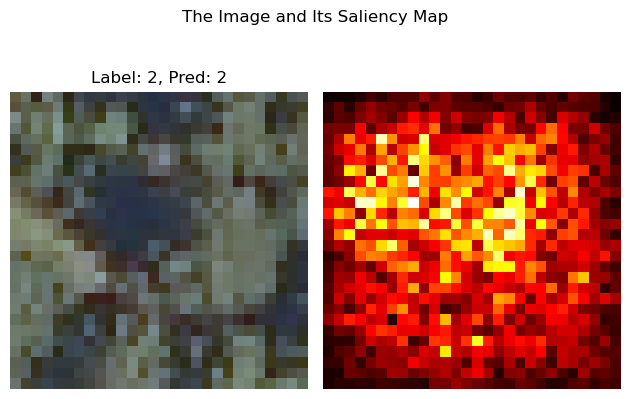

torch.Size([1, 4, 28, 28])


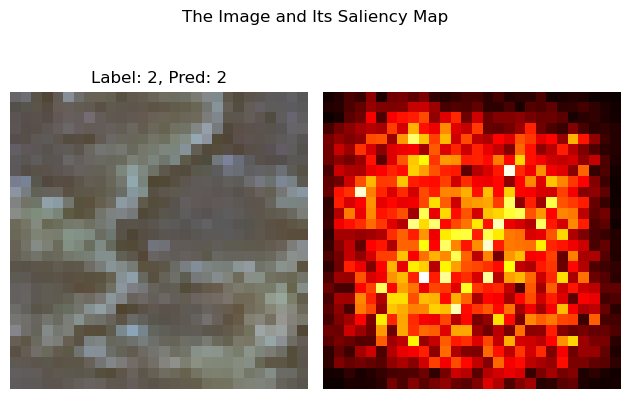

torch.Size([1, 4, 28, 28])


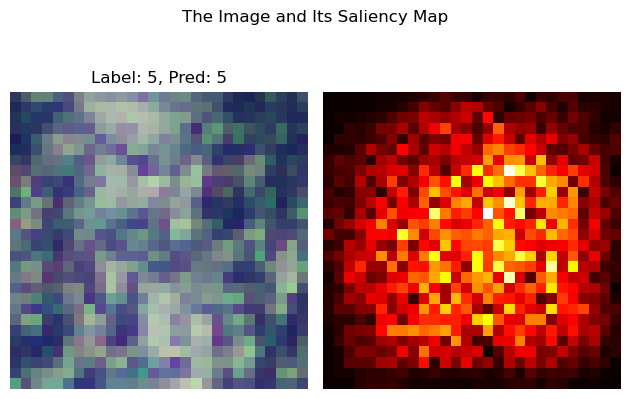

torch.Size([1, 4, 28, 28])


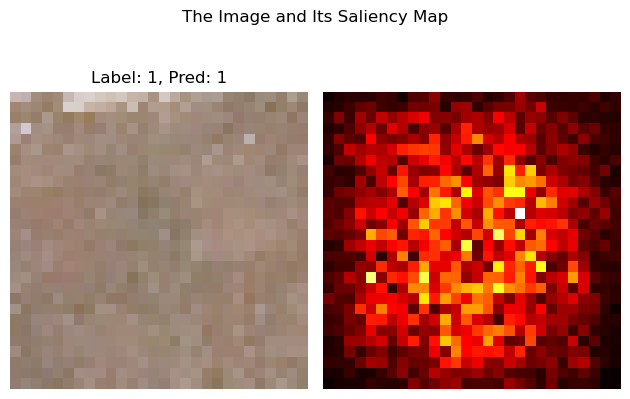

torch.Size([1, 4, 28, 28])


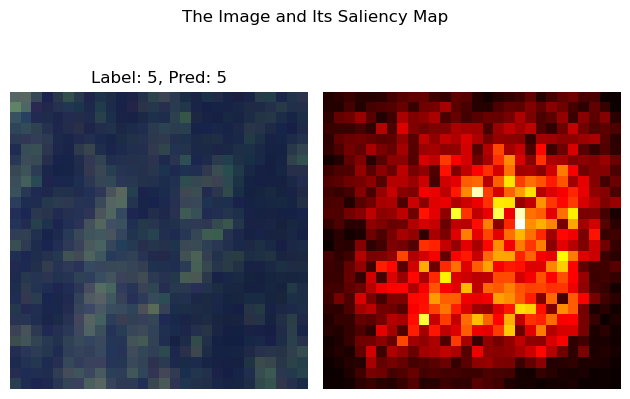

torch.Size([1, 4, 28, 28])


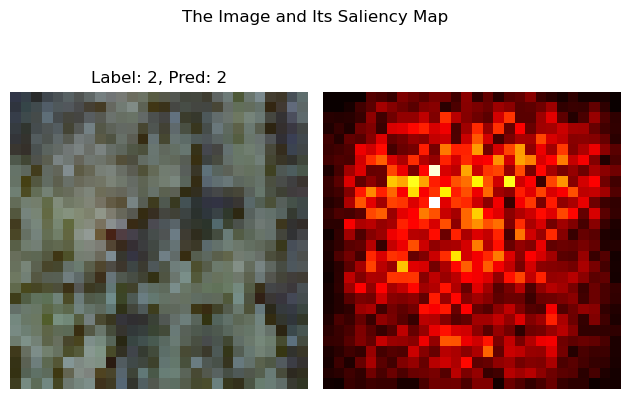

torch.Size([1, 4, 28, 28])


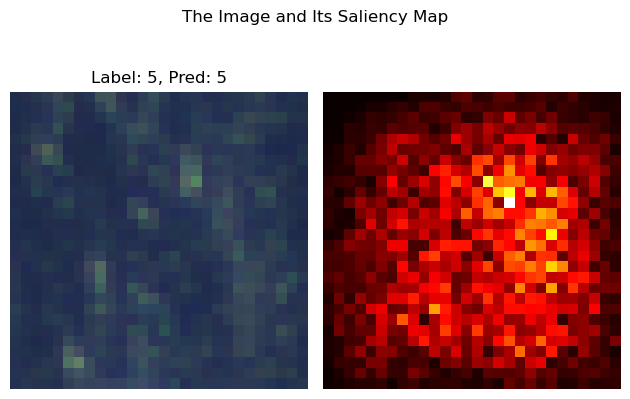

torch.Size([1, 4, 28, 28])


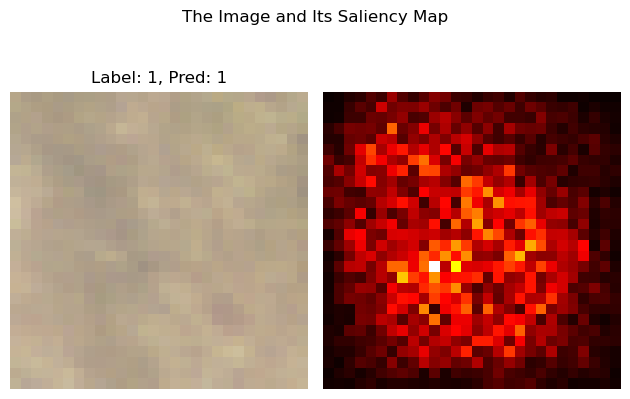

torch.Size([1, 4, 28, 28])


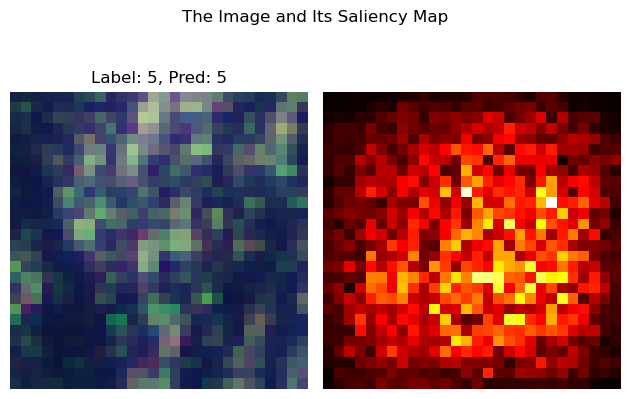

torch.Size([1, 4, 28, 28])


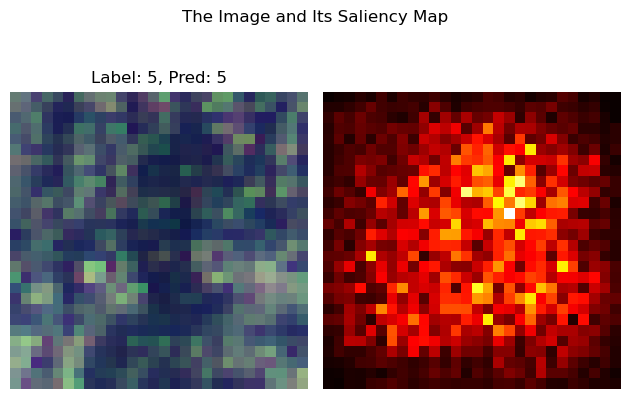

In [20]:
#Change the dimension to fit into the model
x_test = test_images.transpose(3,0,1,2)
t_test = test_labels.transpose()

model = model.to(device)
model.eval()
# with torch.no_grad():

# Retrieve output from the image
# idx_to_plot = 2
for idx_to_plot in range(10):
    image = x_test[idx_to_plot,:,:,:]
    image_orig = image.copy()
    image = torch.FloatTensor(image).permute(2, 1, 0).to(device)

    # Make input tensor require gradient
        # X.requires_grad_()
    image = image[None,:].requires_grad_()
    print(image.shape)
    output = model(image)

    # Catch the output
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Do backpropagation to get the derivative of the output based on the image
    output_max.backward()

    # Retireve the saliency map and also pick the maximum value from channels on each pixel.
    # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(28, 28)

    # # Reshape the image
    # image = image.reshape(-1, 28, 28)

    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    # x_train[count,:,:,0:3]
    # print(image.shape)
    # image = image.permute(3, 2, 1,0).squeeze()
    # print(image.shape)
    ax[0].imshow(image_orig[:,:,0:3])
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    ax[0].set_title('Label: {}, Pred: {}'.format(t_test[idx_to_plot].argmax(),output_idx.cpu()))
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()